<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Utils

In [34]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [32]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')




# Load Data

In [3]:
baseline_redcap_df = pd.read_excel("data_pull/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)

mapping_df = pd.read_csv("data_pull/Wave1LifeSenseEnroll_DATA_LABELS_2019-08-15_0929.csv")

baseline_redcap_dict = dict(zip(mapping_df['Case#:'], mapping_df['LifeSense Study App ID:    ']))

baseline_redcap_df['pid'] = baseline_redcap_df['study_id'].map(baseline_redcap_dict)

def pad_pid(row):
    if len(row['pid']) < 8:
        return ('0' * (8-len(row['pid']))) + row['pid']
    else:
        return row['pid']

baseline_redcap_df['pid'] = baseline_redcap_df['pid'].astype(str)
baseline_redcap_df['pid'] = baseline_redcap_df.apply(pad_pid, axis=1)

age_dict = dict(zip(baseline_redcap_df['pid'], baseline_redcap_df['age']))

In [11]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")
shift_df = pd.read_pickle("ls_data/phq_shift.df")
cluster_df = pd.read_pickle("ls_data/train_cluster.df").to_frame()
cluster_df = cluster_df.reset_index()

cluster_df['cluster'] = cluster_df['cluster'].map({
    0: 'no_symp',
    1: 'soc_anx',
    2: 'gen_anx',
    3: 'dep_anx'
})

In [12]:
cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

phq_df = phq_df[phq_df['pid'].isin(cluster_df['pid'])]
phq_df['baseline_cluster'] = phq_df['pid'].map(cluster_dict)

In [13]:
cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

shift_df = shift_df[shift_df['pid'].isin(cluster_df['pid'])]
shift_df['baseline_cluster'] = shift_df['pid'].map(cluster_dict)

In [37]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 4,
   "week_7_arm_1": 7,
   "week_10_arm_1": 10,
   "week_13_arm_1": 13,
   "week_16_arm_1": 16
}

survey_dict = {
   "week_1_arm_1": 0,
   "week_4_arm_1": 1,
   "week_7_arm_1": 2,
   "week_10_arm_1": 3,
   "week_13_arm_1": 4,
   "week_16_arm_1": 5
}



shift_df['study_wk'] = shift_df['redcap_event_name'].map(event_dict)
shift_df['survey_idx'] = shift_df['redcap_event_name'].map(survey_dict)

In [38]:
shift_df.head()

cluster              diff mean_phq phq01_sc phq02_sc phq03_sc phq04_sc  \
0       3               NaT  9.71429        1        2        1        2   
1       3  20 days 19:32:10  9.71429        1        2        2        2   
2       3  21 days 00:04:12  9.71429        1        1        2        1   
3       3  21 days 02:46:57  9.71429        1        1        3        2   
4       3  20 days 21:08:34  9.71429        1        1        3        3   

  phq05_sc phq06_sc phq07_sc  ...      phq_start_shift phq_total_sc       pid  \
0        0        1        0  ...                  NaT          7.0  00746649   
1        0        1        1  ...  2019-08-05 23:32:00          9.0  00746649   
2        0        1        1  ...  2019-08-26 19:04:10          7.0  00746649   
3        0        1        1  ...  2019-09-16 19:08:22          9.0  00746649   
4        1        2        2  ...  2019-10-07 21:55:19         14.0  00746649   

  redcap_event_name  phq_total_shift phq_diff baseline_cluster  study_wk  \
0      week_1_arm_1              NaN      NaN          dep_anx         1   
1      week_4_arm_1              7.0      2.0          dep_anx         4   
2      week_7_arm_1              9.0     -2.0          dep_anx         7   
3     week_10_arm_1              7.0      2.0          dep_anx        10   
4     week_13_arm_1              9.0      5.0          dep_anx        13   

      timestamp survey_idx  
0  1.565048e+09          0  
1  1.566846e+09          1  
2  1.568661e+09          2  
3  1.570485e+09          3  
4  1.572289e+09          4  

[5 rows x 23 columns]

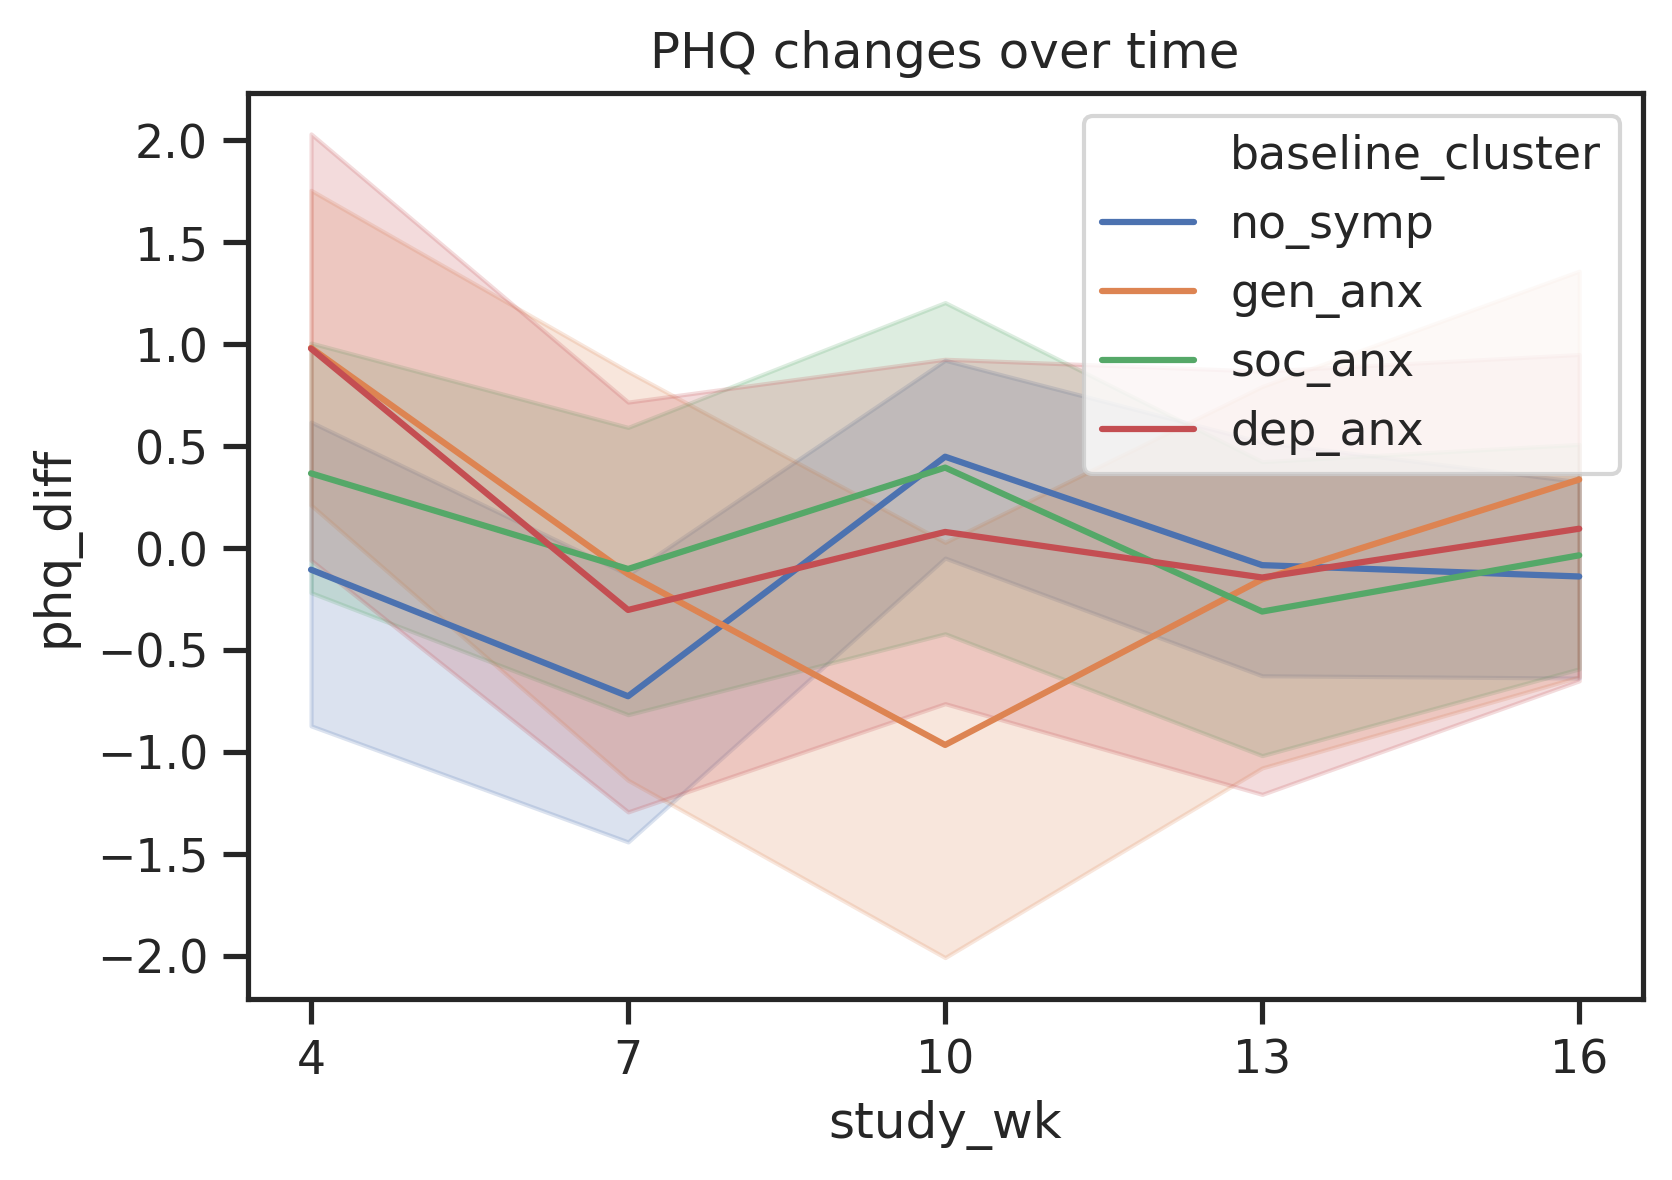

In [39]:
shift_df['phq_start'] = pd.to_datetime(shift_df['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=shift_df)
plt.xticks([4,7,10,13,16])
plt.legend(loc="upper right")
plt.title("PHQ changes over time")
plt.show()

In [40]:
shift_df['timestamp'] = (shift_df['phq_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

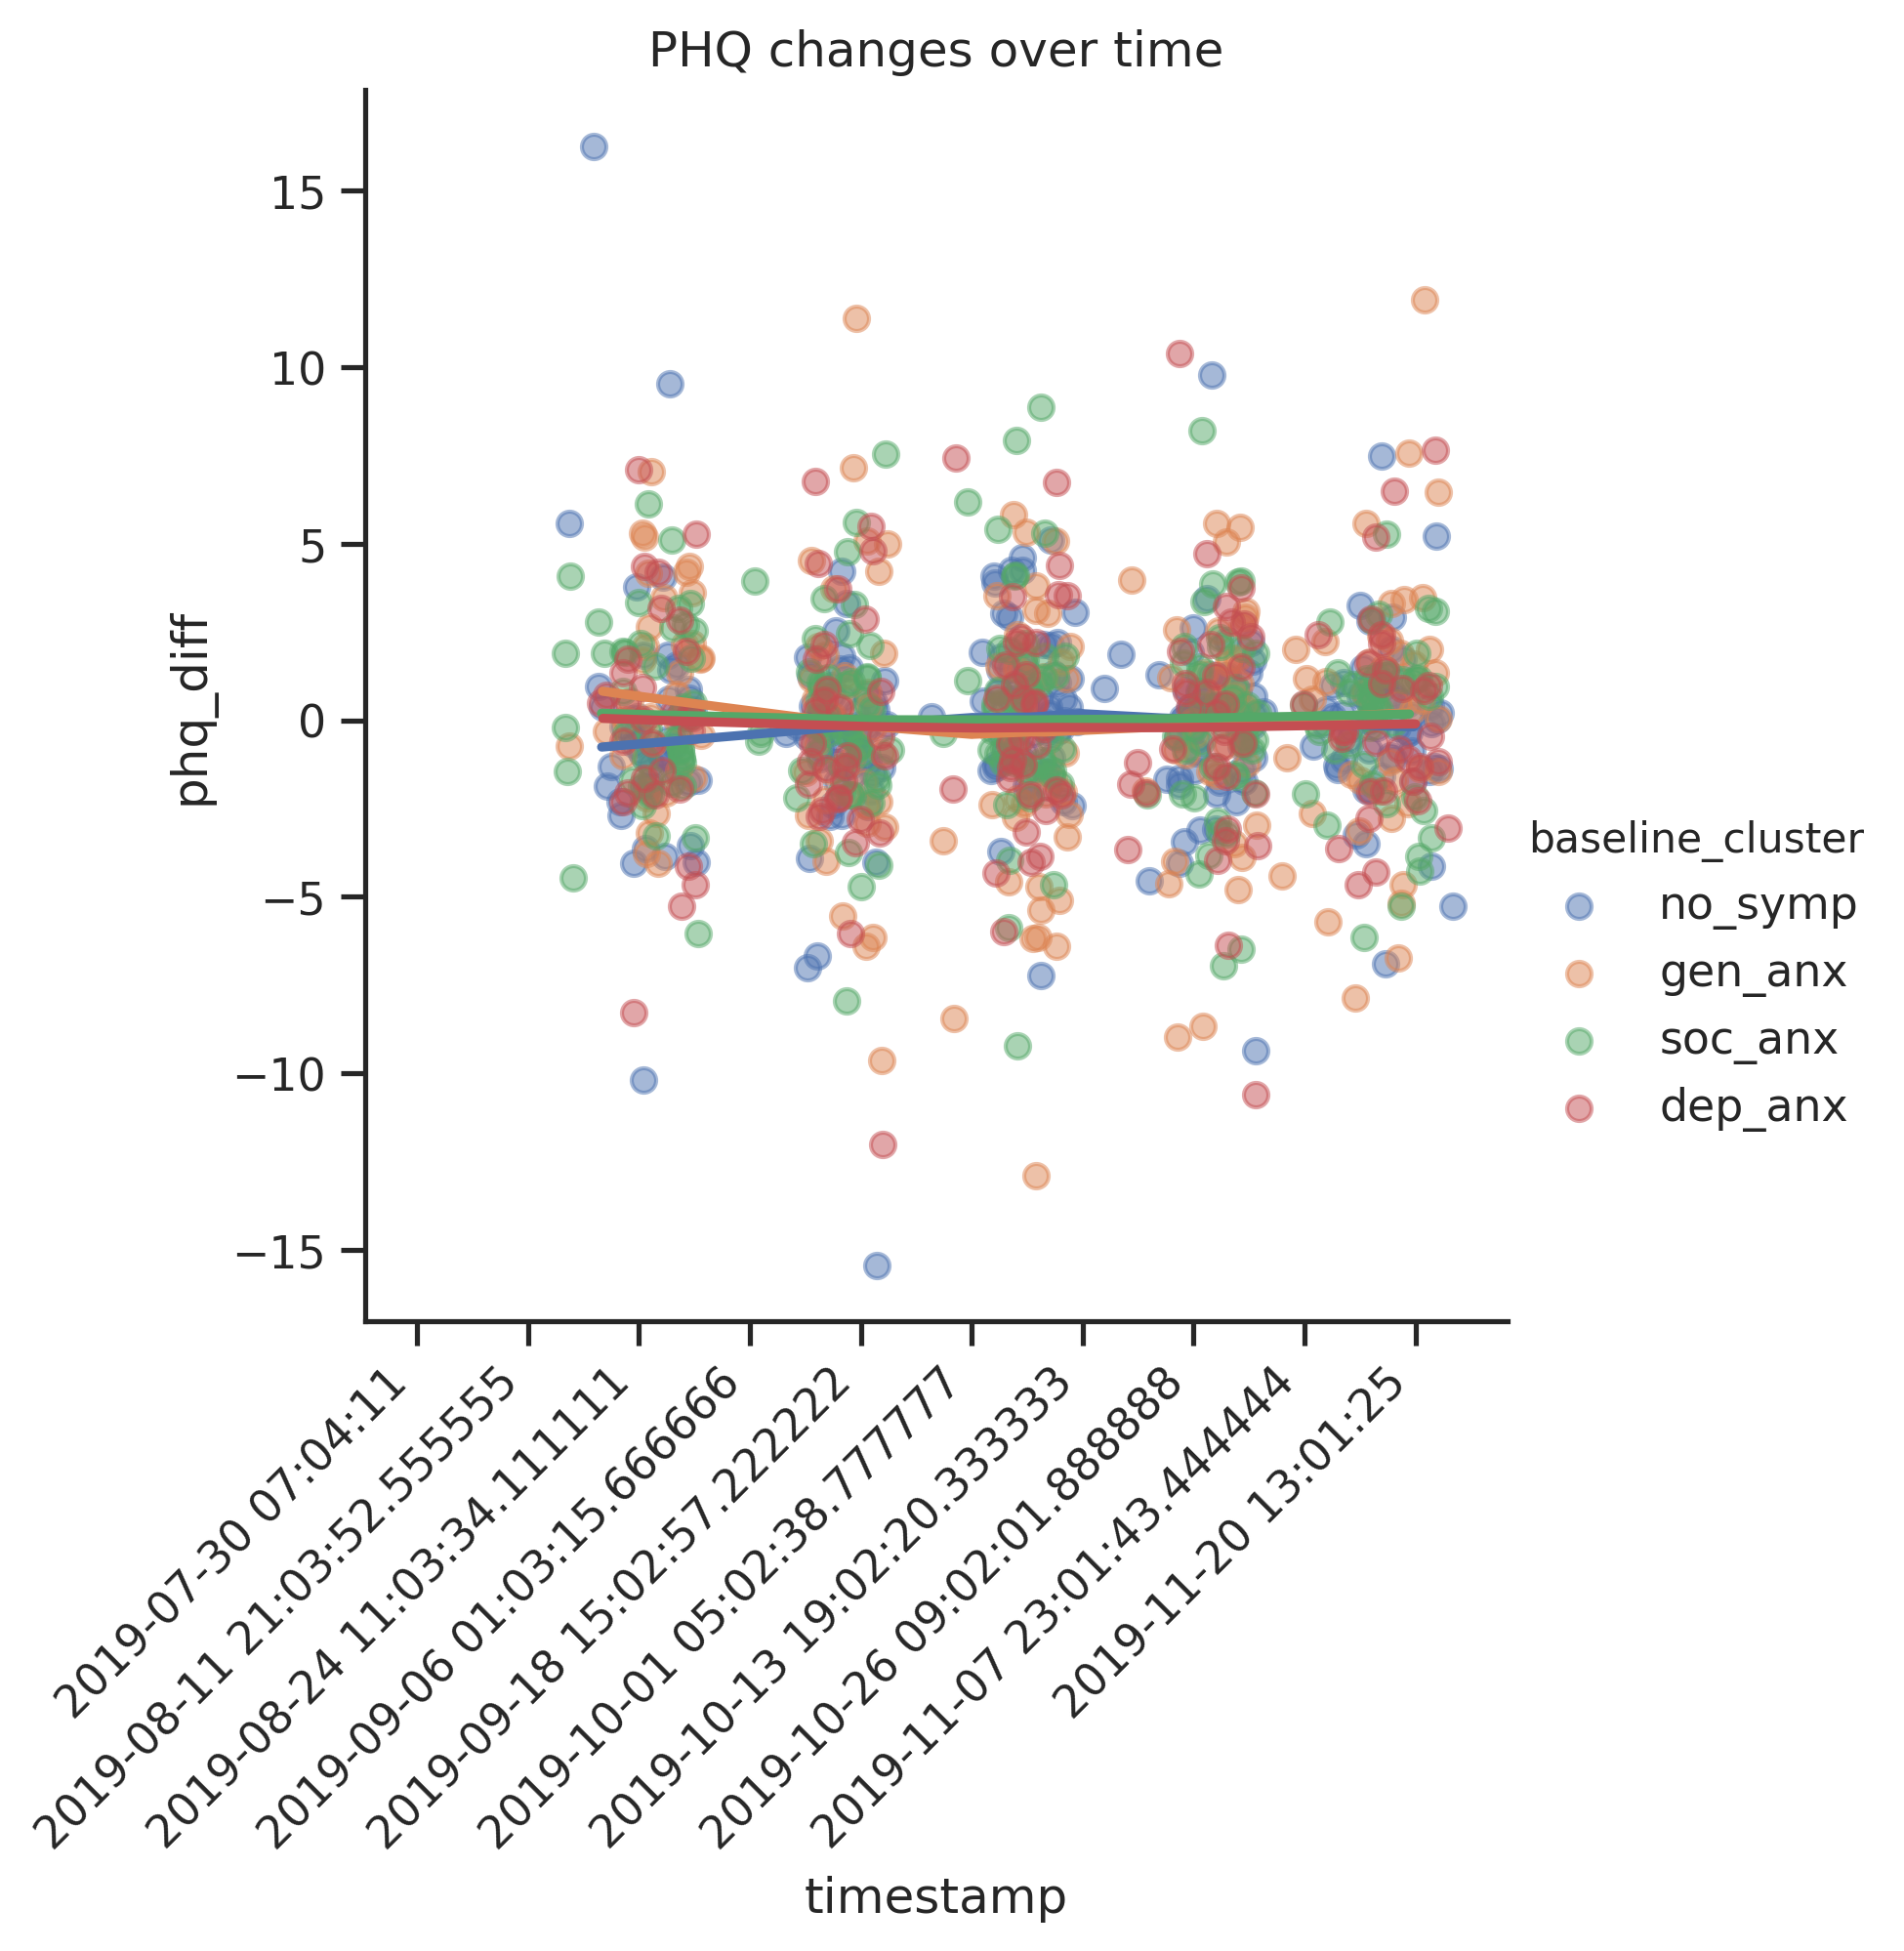

In [41]:
import matplotlib.dates as md


sns.lmplot(x='timestamp', y='phq_diff', 
           data=shift_df, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=400000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.5
           },
          )
ax=plt.gca()
ticks = np.linspace(shift_df['timestamp'].min(), shift_df['timestamp'].max(), 10)
idx = pd.date_range(shift_df['phq_start'].min(), shift_df['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("PHQ changes over time")
plt.show()

## Build Sequence DF

In [50]:
phq_df[phq_df['redcap_event_name'] == 'week_1_arm_1']['phq_start'].min()

Timestamp('2019-07-28 08:30:51')

In [51]:
survey_dates = [
    '2019-07-23',
    '2019-07-30',
    '2019-08-05', 
    '2019-08-20',
    '2019-08-26',
    '2019-09-10',
    '2019-09-16',
    '2019-10-01',
    '2019-10-07',
    '2019-10-21',
    '2019-10-29',
    '2019-11-11',
    '2019-11-19'
]

In [53]:
survey_idxs = []
phq_tots = []
phq_dates = []
baseline_clusters = []
pids = []

for pid, group in phq_df.groupby('pid', as_index=False):

    
    for idx, date in enumerate(survey_dates):
        tot = np.nan
        phq_date = np.nan        
        sel_row = group[(group['phq_start'] > (pd.to_datetime(date) - pd.Timedelta(3, unit='D'))) & 
                        (group['phq_start'] < (pd.to_datetime(date) + pd.Timedelta(5, unit='D')))]
        #print(date)
        #display(sel_row)
        if sel_row.shape[0] > 0:
            tot = sel_row['phq_total_sc'].values[0]
            phq_date = sel_row['phq_start'].values[0]
            
        phq_tots.append(tot)
        phq_dates.append(phq_date)
        baseline_clusters.append(group['baseline_cluster'].values[0])
        pids.append(pid)
        survey_idxs.append(idx)

In [55]:
phq_seq_df = pd.DataFrame()
phq_seq_df['pid'] = pids
phq_seq_df['baseline_cluster'] = baseline_clusters
phq_seq_df['survey_idx'] = survey_idxs
phq_seq_df['date'] = phq_dates
phq_seq_df['phq_tot'] = phq_tots

In [44]:
color_map = {
    'no_symp': 'blue',
    'gen_anx': 'orange',
    'soc_anx': 'green',
    'dep_anx': 'red'
}

In [42]:
shift_pivot = shift_df.pivot_table(index="pid", columns=['survey_idx'])

# need better imputation
shift_pivot = shift_pivot.T.fillna(shift_pivot.mean(axis=1)).T

In [106]:
print(color_map)

{'no_symp': 'blue', 'gen_anx': 'orange', 'soc_anx': 'green', 'dep_anx': 'red'}


In [45]:
shift_pivot

phq_diff                                            phq_total_sc  \
survey_idx         1          2          3         4          5            0   
pid                                                                            
00746649    2.000000  -2.000000   2.000000  5.000000  -4.000000         7.00   
01225297   -1.600000   0.000000  -1.400000  0.000000   1.000000        10.00   
01254121   -1.000000   0.000000   1.000000  1.000000  -2.000000         1.00   
01495950    3.000000   4.000000  -5.000000  2.000000   0.000000         5.00   
01766910   -1.000000   0.000000   1.000000 -3.000000   3.000000        13.00   
02970060   -6.000000  -1.000000   9.000000 -7.000000   3.000000        12.00   
03233601   -3.000000   1.000000  -1.000000  2.000000  -0.833333        16.00   
03578019    4.000000   1.000000  -2.500000 -4.500000   3.000000         5.00   
03939827   -3.500000  -4.500000   4.000000  0.000000   1.000000         8.00   
04133537    4.000000  11.000000 -13.000000  1.000000  12.000000         9.00   
04918121    1.000000   3.000000   0.000000 -1.000000   0.000000         6.00   
06400675   -1.000000  -2.000000  -5.000000  5.000000  -3.000000        16.00   
06638392    0.000000  -2.000000   4.000000 -4.000000   1.000000        15.00   
07974290    3.000000   2.000000  -3.000000  3.000000  -3.000000         7.00   
08007167   -2.000000  -4.000000   2.000000 -1.000000   2.000000        10.00   
08103884    0.000000   0.000000   1.000000 -2.000000  -1.000000         9.00   
09489685   -2.000000   3.666667  -1.666667  1.000000   0.000000         3.00   
09611865    0.000000   7.000000  -4.000000  2.000000  -2.000000        15.00   
10099555   -2.000000  -3.000000   4.000000  1.000000  -5.000000        21.00   
10285142    1.000000   7.000000  -8.000000 -1.000000   8.000000        11.00   
11770862    0.000000   0.166667  -0.166667  1.000000  -1.000000         0.00   
11927637    5.000000   2.000000  -6.000000  0.000000   1.166667         2.00   
12807049    4.000000   1.000000   5.000000  0.000000  -8.000000         7.00   
13051775   -1.000000   1.000000  -1.000000  4.000000  -1.000000         4.00   
13250317    7.000000  -2.000000   4.000000 -1.000000   2.000000        13.00   
14113160    2.000000  -8.000000   1.000000  4.000000   3.000000         9.00   
14196469    1.000000   1.000000   0.000000  0.000000   0.000000         7.00   
14549710   -1.000000   4.000000  -1.000000 -1.000000   2.000000        14.00   
14753485   -2.000000   1.000000  -1.000000  0.000000   0.000000         4.00   
16777771    0.500000   1.500000  -5.000000  5.000000  -5.000000         3.00   
...              ...        ...        ...       ...        ...          ...   
81249330   -2.000000   0.000000   0.000000  0.333333  -0.333333         2.00   
81720300   -2.000000   1.000000   1.000000 -1.000000   0.000000         7.00   
81729157    2.000000   0.000000  -2.000000  1.000000   0.000000         3.00   
82727218   -5.000000   4.000000  -2.000000 -1.000000   1.000000        10.00   
83056303   -3.000000   1.000000  -2.000000  0.000000   1.000000        12.00   
83085276   -0.833333   0.833333  -1.000000  0.000000  -3.000000         6.00   
83275234    2.000000   0.000000  -7.000000  7.000000   0.000000         5.00   
84877086    0.000000  -1.000000   1.000000 -2.000000   1.000000         9.00   
84902402    5.000000   4.000000  -2.000000  1.000000   0.000000         1.00   
85752121    1.000000  -2.000000   0.000000  0.000000   0.000000         2.00   
86283726    0.000000   0.000000  -1.750000  2.000000  -2.000000         6.75   
86756971    4.000000  -2.000000   4.000000 -4.000000   3.000000         3.00   
87400142    1.000000   0.000000  -1.000000  0.000000   0.000000         1.00   
87485171   -2.000000   1.000000   0.000000  3.000000   1.000000         5.00   
89057862    0.000000   0.000000   1.000000 -1.000000   1.000000         1.00   
89434074    0.000000   0.000000   2.000000  0.000000   2.000000         1.00   
90229239   -

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


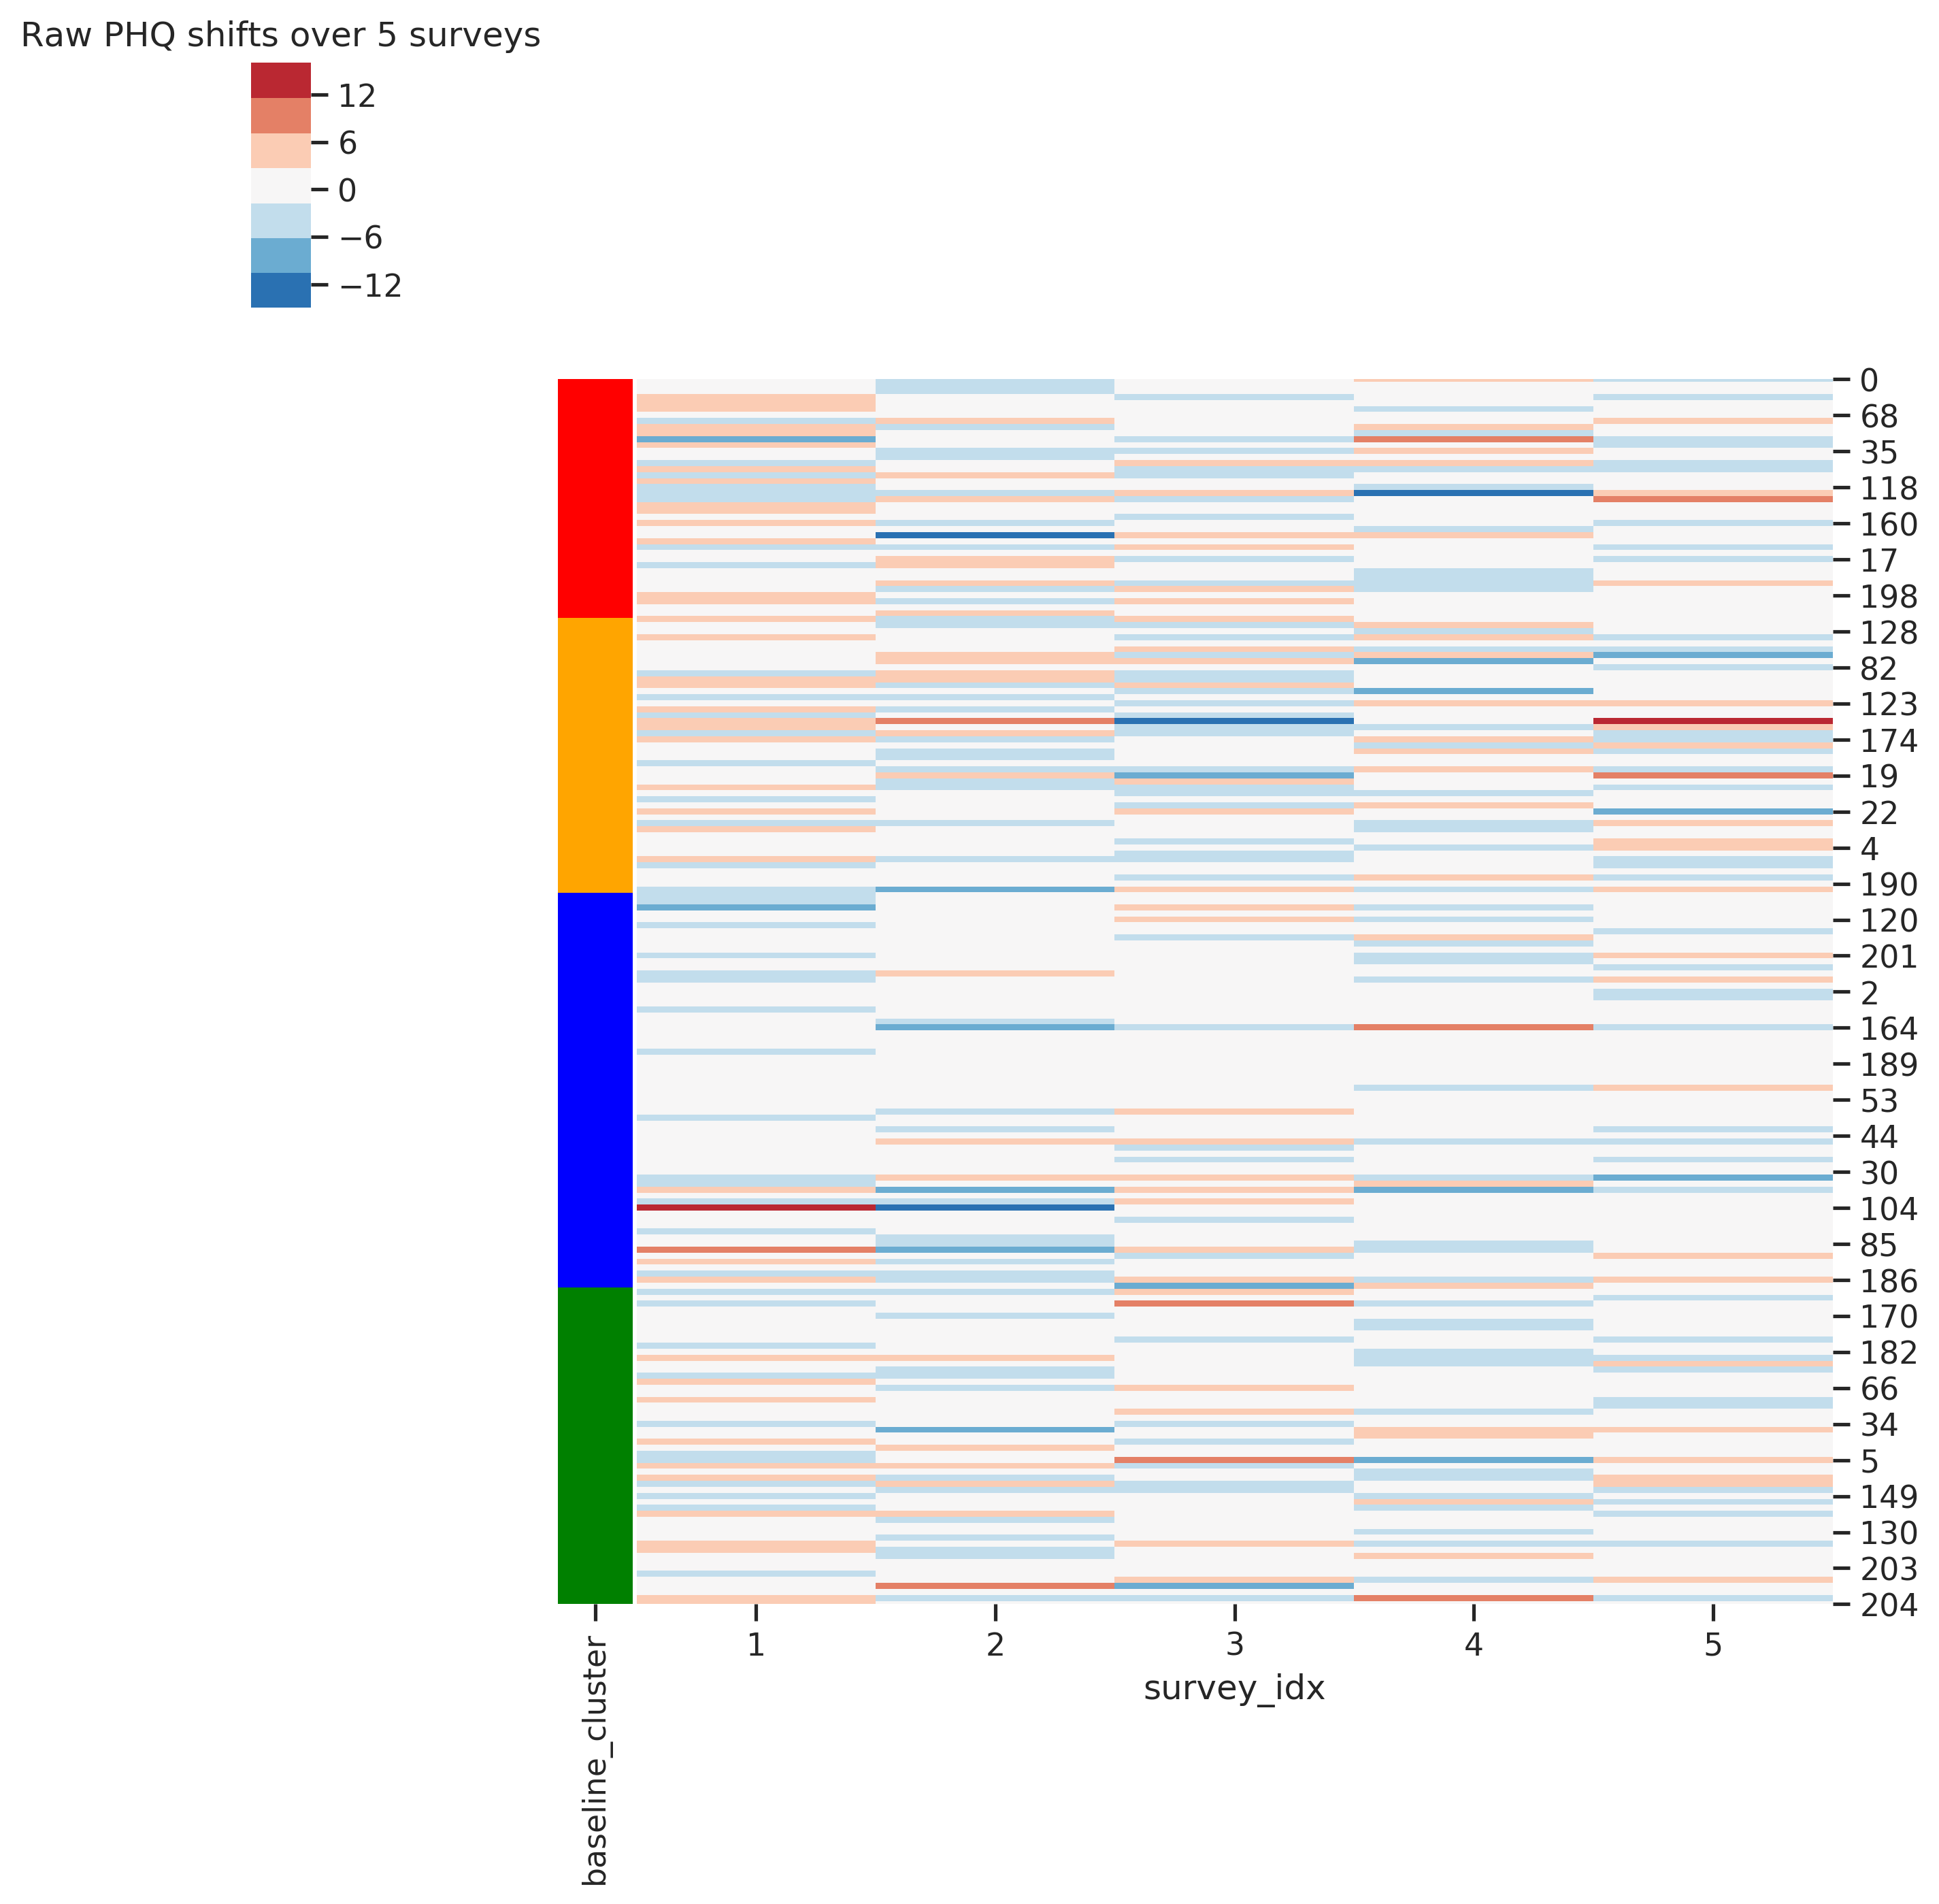

In [49]:
shift_pivot_cluster = shift_pivot.copy()
shift_pivot_cluster = shift_pivot_cluster.reset_index()
shift_pivot_cluster['baseline_cluster'] = shift_pivot_cluster['pid'].map(cluster_dict)
shift_pivot_cluster = shift_pivot_cluster.drop('pid', axis='columns')
shift_pivot_cluster = shift_pivot_cluster.sort_values(by=['baseline_cluster'])

cluster = shift_pivot_cluster.pop("baseline_cluster")
row_colors = cluster.map(color_map)
cmap = sns.color_palette("RdBu_r", 7)

sns.clustermap(shift_pivot_cluster['phq_diff'], cmap=cmap, figsize=(10,10), 
               col_cluster=False, row_cluster=False, row_colors=row_colors)
#plt.ylabel("Participants")
plt.title("Raw PHQ shifts over 5 surveys")
plt.show()

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


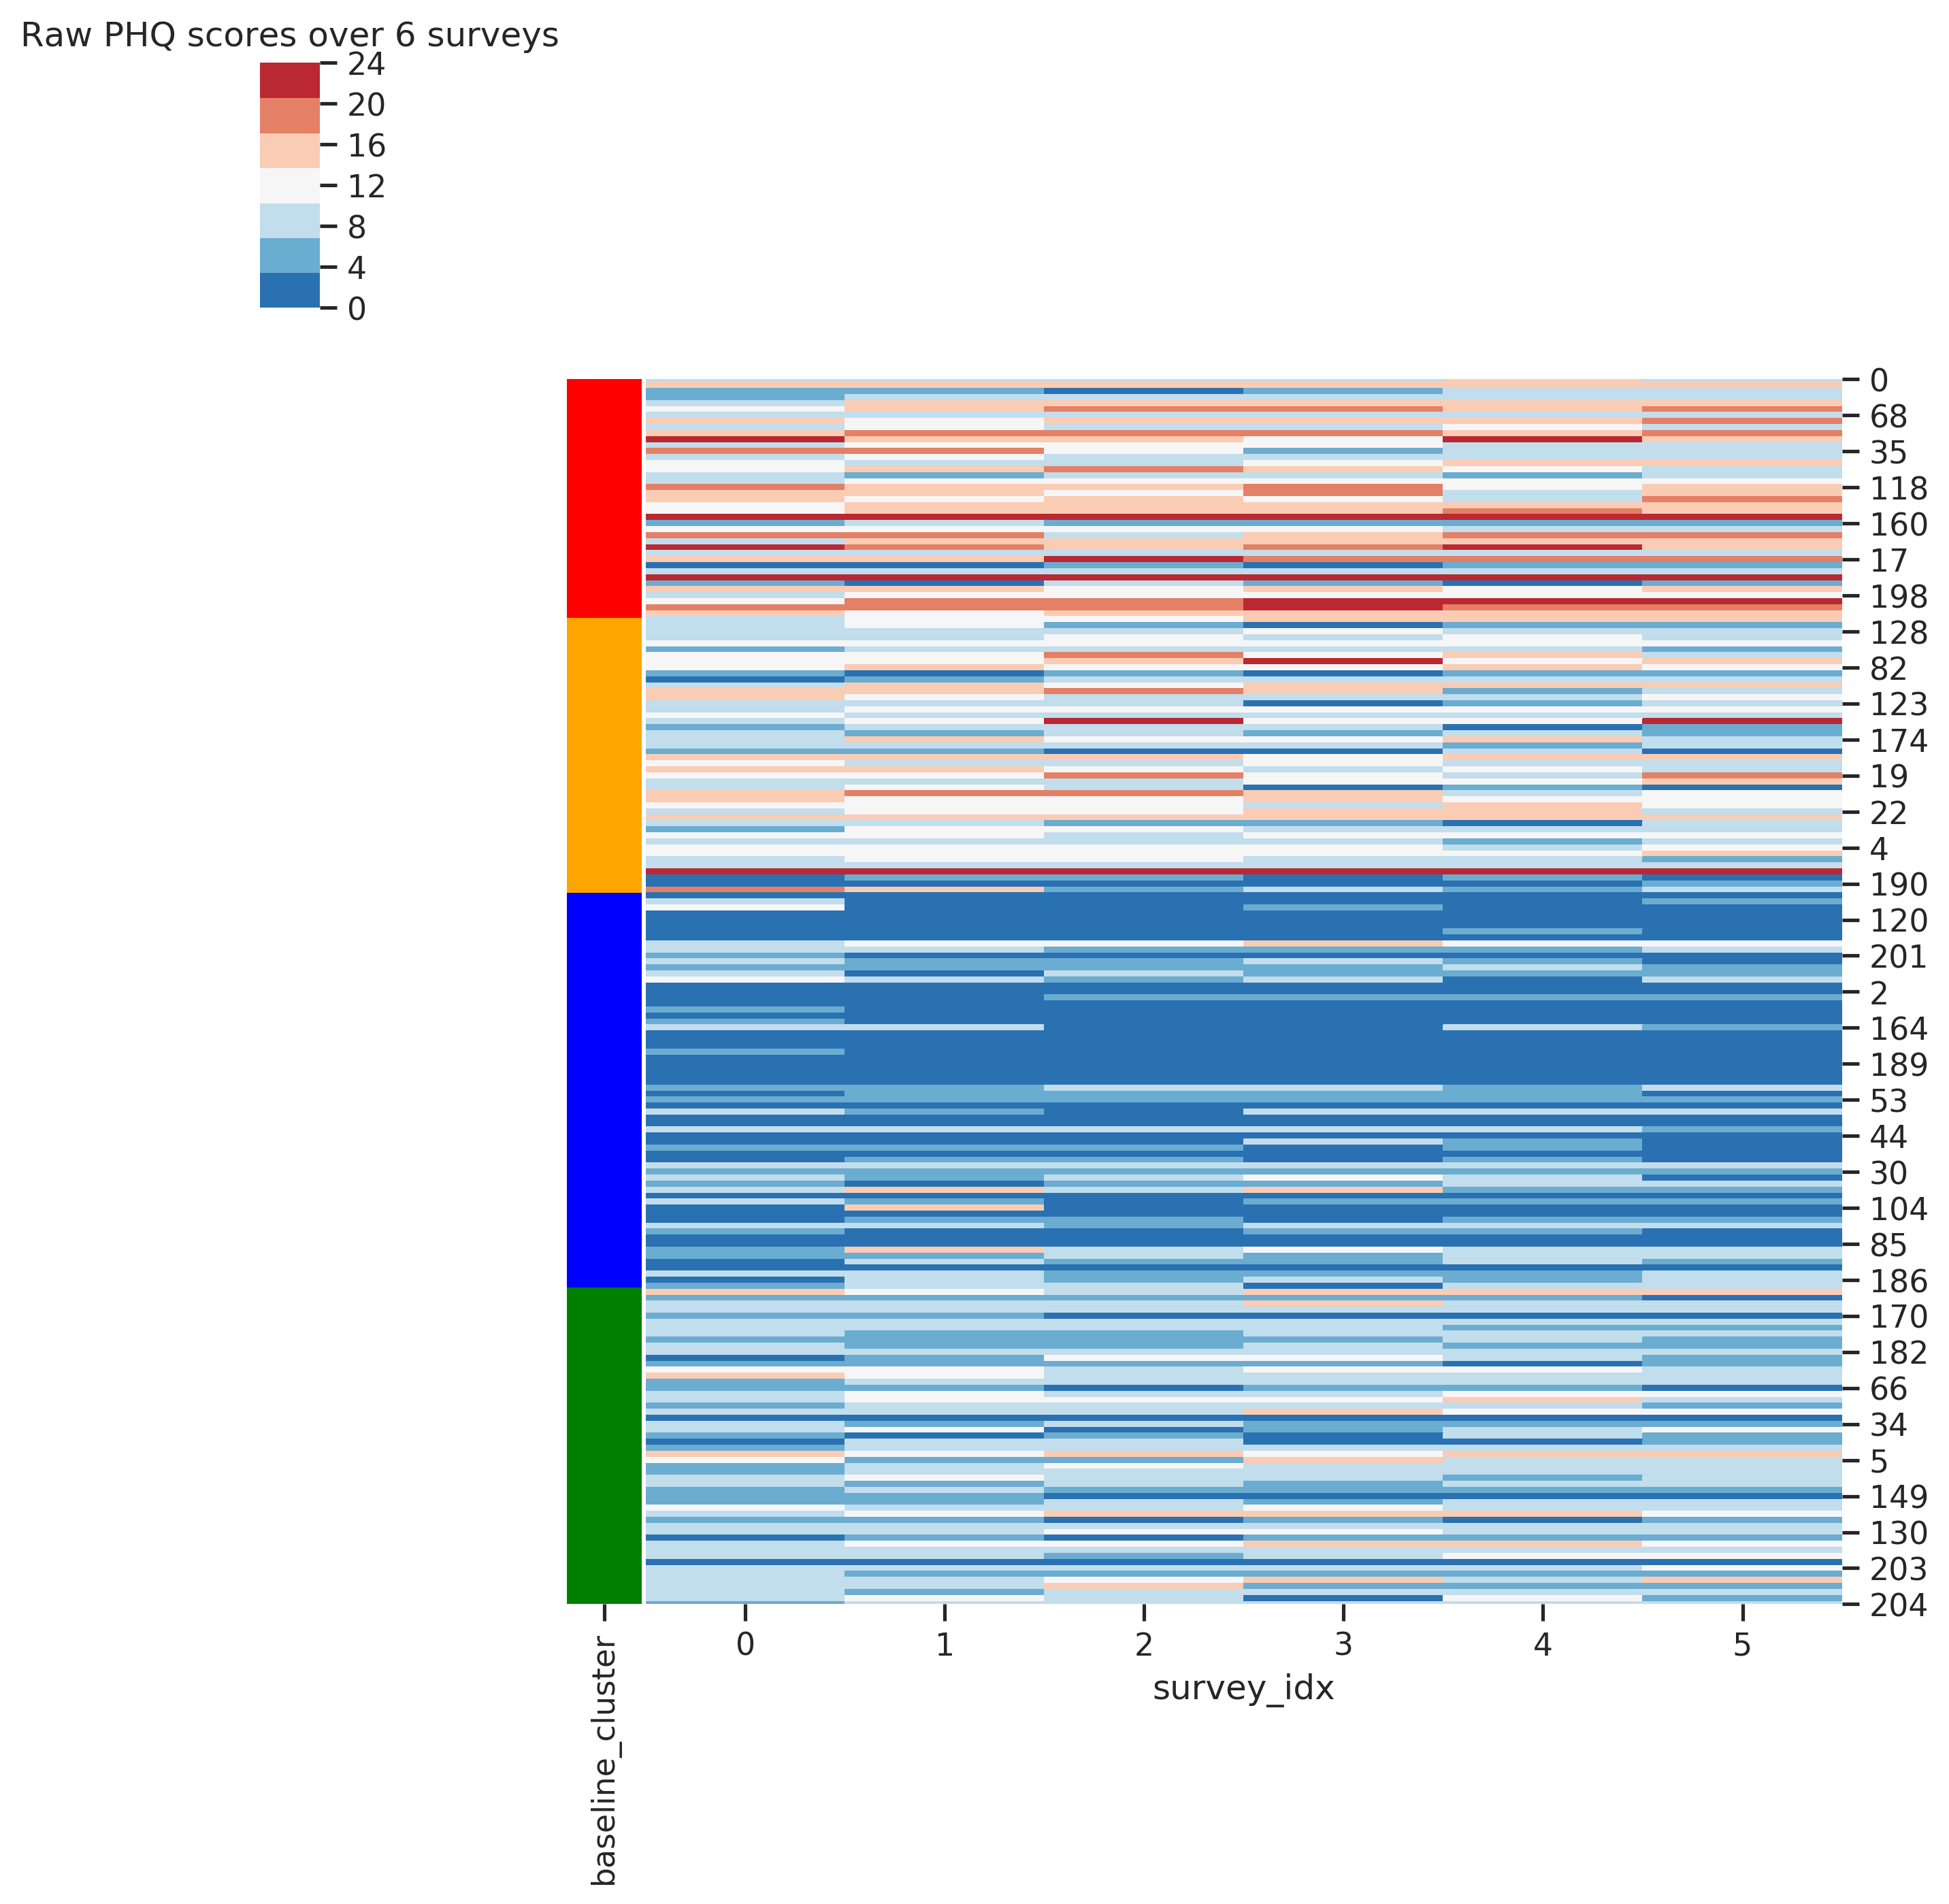

In [107]:
shift_pivot_cluster = shift_pivot.copy()
shift_pivot_cluster = shift_pivot_cluster.reset_index()
shift_pivot_cluster['baseline_cluster'] = shift_pivot_cluster['pid'].map(cluster_dict)
shift_pivot_cluster = shift_pivot_cluster.drop('pid', axis='columns')
shift_pivot_cluster = shift_pivot_cluster.sort_values(by=['baseline_cluster'])

cluster = shift_pivot_cluster.pop("baseline_cluster")
row_colors = cluster.map(color_map)
cmap = sns.color_palette("RdBu_r", 7)

sns.clustermap(shift_pivot_cluster['phq_total_sc'], cmap=cmap, figsize=(10,10), 
               col_cluster=False, row_cluster=False, row_colors=row_colors)
#plt.ylabel("Participants")
plt.title("Raw PHQ scores over 6 surveys")
plt.show()

Text(0.5, 1.0, 'Within individual PHQ shift variance')

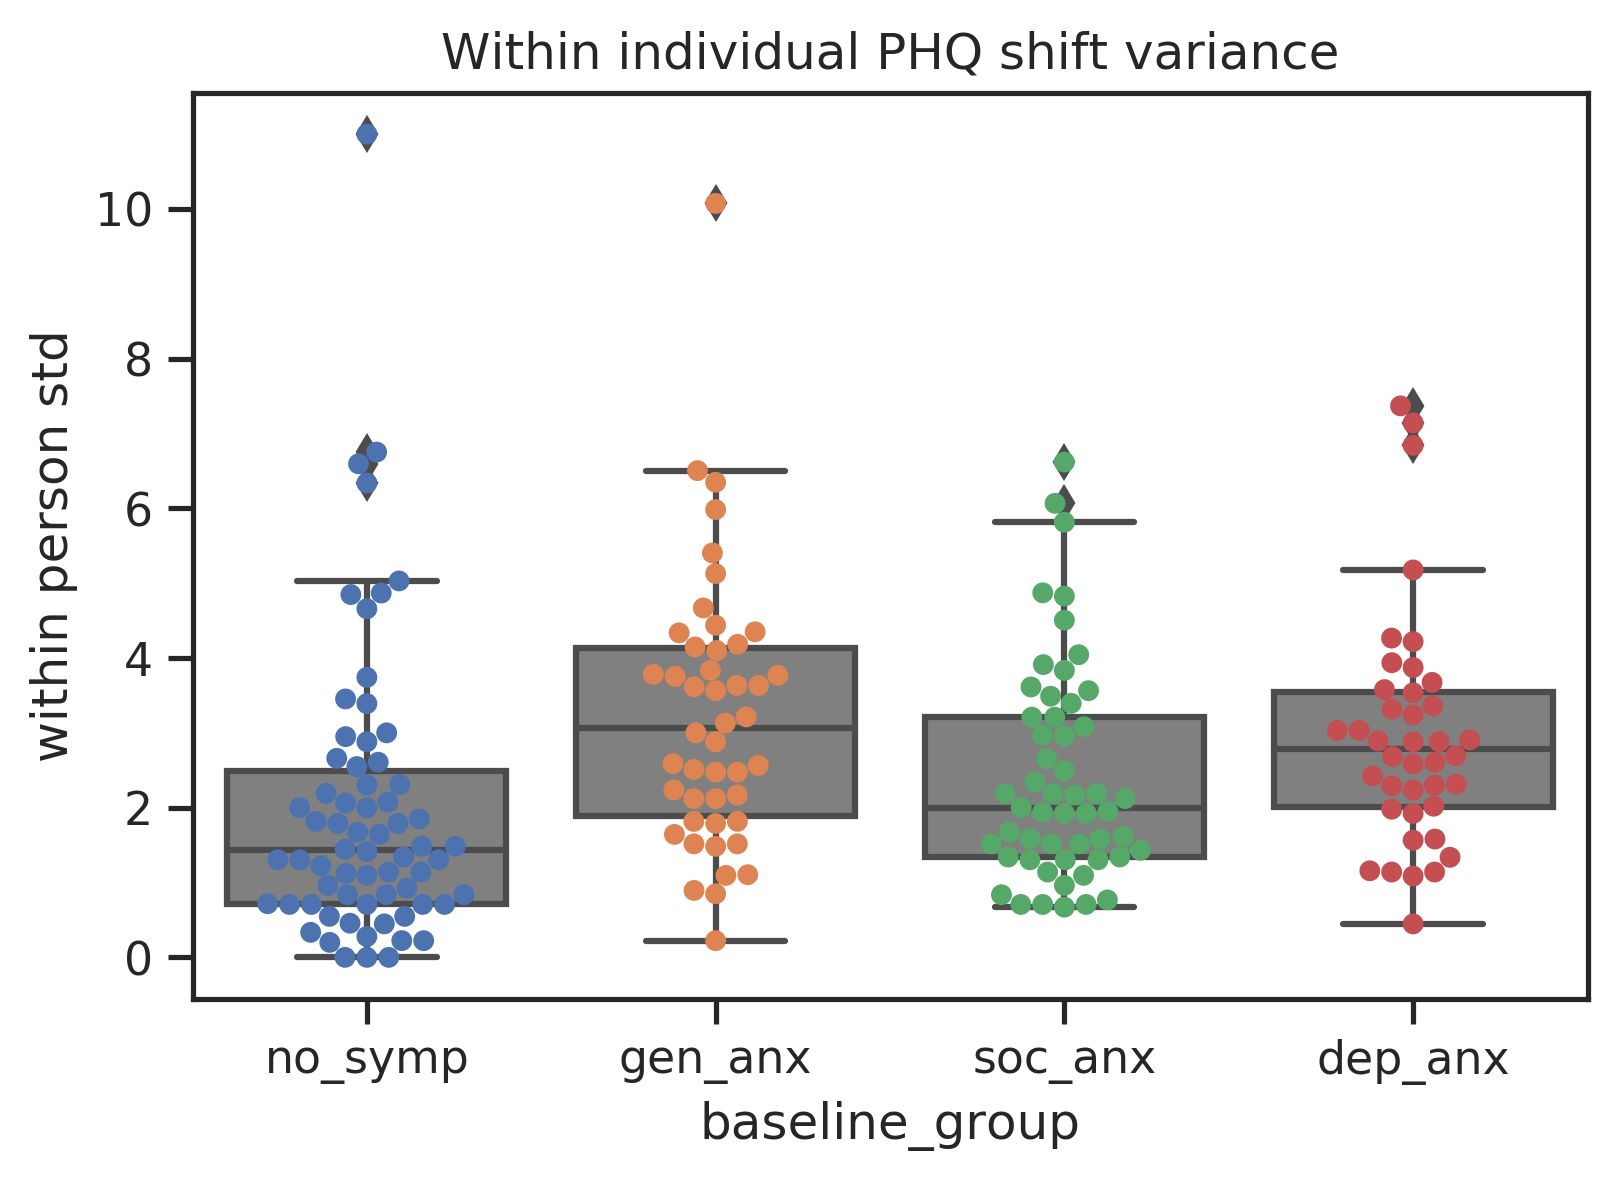

In [52]:
phq_std = shift_df.groupby('pid')['phq_diff'].std()
phq_std = phq_std.to_frame().reset_index()
phq_std['baseline_group'] = phq_std['pid'].map(cluster_dict)
phq_std = phq_std.rename(columns={'phq_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=phq_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=phq_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual PHQ shift variance")

# Correlates Over Time

## Load data

In [53]:
# load cal data
all_cal = pd.read_pickle("ls_data/all_cal.df")
all_cal = all_cal.rename(columns={'call_hour': 'hour'})
all_cal.head()
all_cal = all_cal[(all_cal['hour'] < '2019-08-13') & (all_cal['hour'] >= '2019-07-20')]

wk4_cal = pd.read_pickle("ls_data/wk4/cal_hr.df")
wk7_cal = pd.read_pickle("ls_data/wk7/cal_hr.df")
wk10_cal = pd.read_pickle("ls_data/wk10/cal_hr.df")
wk13_cal = pd.read_pickle("ls_data/wk13/cal_hr.df")
wk16_cal = pd.read_pickle("ls_data/wk16/cal_hr.df")


all_cal = all_cal.append(wk4_cal)
all_cal = all_cal.append(wk7_cal)
all_cal = all_cal.append(wk10_cal)
all_cal = all_cal.append(wk13_cal)
all_cal = all_cal.append(wk16_cal)


# build cal_daily
all_cal['date'] = all_cal['hour'].dt.floor('d')
cal_daily = all_cal.groupby(['pid', 'date']).sum()
cal_daily = cal_daily.reset_index()
cal_daily["is_wkday"] = (pd.to_datetime(cal_daily['date']).dt.dayofweek < 5).astype(float)

display(cal_daily.head())

pid       date  tot_call_count  tot_call_duration  is_wkday
0  00746649 2019-07-23              12               1814       1.0
1  00746649 2019-07-24              15               4572       1.0
2  00746649 2019-07-25              20               2363       1.0
3  00746649 2019-07-26              15               8063       1.0
4  00746649 2019-07-27              10               1748       0.0

In [54]:
# load sms data
all_sms = pd.read_pickle("ls_data/all_sms.df")
all_sms = all_sms.rename(columns={'sms_hour': 'hour'})
all_sms = all_sms[(all_sms['hour'] < '2019-08-13') & (all_sms['hour'] >= '2019-07-20')]

wk4_sms = pd.read_pickle("ls_data/wk4/sms_hr.df")
wk7_sms = pd.read_pickle("ls_data/wk7/sms_hr.df")
wk10_sms = pd.read_pickle("ls_data/wk10/sms_hr.df")
wk13_sms = pd.read_pickle("ls_data/wk13/sms_hr.df")
wk16_sms = pd.read_pickle("ls_data/wk16/sms_hr.df")

all_sms = all_sms.append(wk4_sms)
all_sms = all_sms.append(wk7_sms)
all_sms = all_sms.append(wk10_sms)
all_sms = all_sms.append(wk13_sms)
all_sms = all_sms.append(wk16_sms)

display(all_sms.head())

# build sms_daily
all_sms['date'] = all_sms['hour'].dt.floor('d')
sms_daily = all_sms.groupby(['pid', 'date']).sum()
sms_daily = sms_daily.reset_index()
sms_daily["is_wkday"] = (pd.to_datetime(sms_daily['date']).dt.dayofweek < 5).astype(float)

display(sms_daily.head())

hour  tot_sms_count  tot_sms_length  in_sms_count  \
0 2019-07-27 21:00:00              6             192           4.0   
1 2019-07-27 22:00:00              0               0           0.0   
2 2019-07-27 23:00:00              0               0           0.0   
3 2019-07-28 00:00:00              0               0           0.0   
4 2019-07-28 01:00:00              0               0           0.0   

   in_sms_length  out_sms_count  out_sms_length       pid  
0          105.0            2.0            87.0  08343773  
1            0.0            0.0             0.0  08343773  
2            0.0            0.0             0.0  08343773  
3            0.0            0.0             0.0  08343773  
4            0.0            0.0             0.0  08343773

pid       date  tot_sms_count  tot_sms_length  in_sms_count  \
0  00746649 2019-07-23             22            1738          22.0   
1  00746649 2019-07-24             24            1464          24.0   
2  00746649 2019-07-25             14             936          14.0   
3  00746649 2019-07-26             23            2135          23.0   
4  00746649 2019-07-27             21             990          21.0   

   in_sms_length  out_sms_count  out_sms_length  is_wkday  
0         1738.0            0.0             0.0       1.0  
1         1464.0            0.0             0.0       1.0  
2          936.0            0.0             0.0       1.0  
3         2135.0            0.0             0.0       1.0  
4          990.0            0.0             0.0       0.0

In [55]:
# load fga data
all_fga = pd.read_pickle("ls_data/all_fga.df")
all_fga = all_fga[(all_fga['hr'] < '2019-08-13') & (all_fga['hr'] >= '2019-07-20')]

wk4_fga = pd.read_pickle("ls_data/wk4/fga_hr.df")
wk7_fga = pd.read_pickle("ls_data/wk7/fga_hr.df")
wk10_fga = pd.read_pickle("ls_data/wk10/fga_hr.df")
wk13_fga = pd.read_pickle("ls_data/wk13/fga_hr.df")
wk16_fga = pd.read_pickle("ls_data/wk16/fga_hr.df")

all_fga = all_fga.append(wk4_fga)
all_fga = all_fga.append(wk7_fga)
all_fga = all_fga.append(wk10_fga)
all_fga = all_fga.append(wk13_fga)
all_fga = all_fga.append(wk16_fga)

display(all_fga.head())

# build fga_daily
all_fga['all_browser'] = all_fga['browser'] + all_fga['chrome']
all_fga['date'] = all_fga['hr'].dt.floor('d')
fga_daily = all_fga.groupby(['pid', 'date']).sum()
fga_daily = fga_daily.reset_index()
fga_daily["is_wkday"] = (pd.to_datetime(fga_daily['date']).dt.dayofweek < 5).astype(float)

display(fga_daily.head())

hr  katana  orca  messaging  launcher  chrome  email  \
0 2019-07-27 12:00:00  1771.0   0.0        0.0     105.0     0.0    0.0   
1 2019-07-27 13:00:00  1336.0   0.0        0.0     255.0   315.0    0.0   
2 2019-07-27 14:00:00  1666.0   0.0        0.0     180.0     0.0    0.0   
3 2019-07-27 15:00:00  1997.0   0.0        0.0     309.0   165.0    0.0   
4 2019-07-27 16:00:00  1289.0   0.0        0.0     379.0     0.0    0.0   

   instagram  youtube  maps  snapchat  browser       pid  
0      405.0      0.0   0.0       0.0      0.0  08343773  
1      195.0      0.0   0.0       0.0      0.0  08343773  
2      330.0      0.0   0.0       0.0      0.0  08343773  
3      195.0      0.0  60.0       0.0      0.0  08343773  
4       75.0      0.0   0.0       0.0      0.0  08343773

pid       date  katana   orca  messaging  launcher  chrome   email  \
0  00746649 2019-07-23     0.0    0.0     3380.0    1753.0  1490.0  1113.0   
1  00746649 2019-07-24     0.0  105.0     1888.0    2831.0   965.0   713.0   
2  00746649 2019-07-25     0.0  135.0     5835.0    1826.0    98.0   770.0   
3  00746649 2019-07-26     0.0  301.0     5288.0    1986.0   195.0  1362.0   
4  00746649 2019-07-27     0.0    0.0     3166.0     686.0     0.0   110.0   

   instagram  youtube    maps  snapchat  browser  all_browser  is_wkday  
0      211.0   1080.0   240.0       0.0    165.0       1655.0       1.0  
1     1203.0      0.0     0.0       0.0    931.0       1896.0       1.0  
2      368.0      0.0    73.0       0.0    509.0        607.0       1.0  
3      842.0      0.0  1410.0       0.0   1065.0       1260.0       1.0  
4     3310.0      0.0   847.0       0.0      0.0          0.0       0.0

In [56]:
# load fus data
all_fus = pd.read_pickle("ls_data/fus_daily.df")
display(all_fus.head())
all_fus = all_fus[(all_fus['date'] < '2019-08-13') & (all_fus['date'] >= '2019-07-20')]

wk4_fus = pd.read_pickle("ls_data/wk4/fus_daily.df")
wk7_fus = pd.read_pickle("ls_data/wk7/fus_daily.df")
wk10_fus = pd.read_pickle("ls_data/wk10/fus_daily.df")
wk13_fus = pd.read_pickle("ls_data/wk13/fus_daily.df")
wk16_fus = pd.read_pickle("ls_data/wk16/fus_daily.df")


all_fus = all_fus.append(wk4_fus)
all_fus = all_fus.append(wk7_fus)
all_fus = all_fus.append(wk10_fus)
all_fus = all_fus.append(wk13_fus)
all_fus = all_fus.append(wk16_fus)

display(all_fus.head())

# build fus_daily
fus_daily = all_fus.copy()
fus_daily["is_wkday"] = (pd.to_datetime(fus_daily['date']).dt.dayofweek < 5).astype(float)

pid       date       dist   entropy  cluster   loc_var  velocity  \
3  08343773 2019-07-30  85.911460  0.929294        3 -6.661614  5.252450   
4  08343773 2019-07-31  36.688011  0.692502        3 -6.661614  1.730937   
5  08343773 2019-08-01  29.716842  0.689384        3 -6.661614  1.890282   
6  08343773 2019-08-02  35.859320  0.187561        3 -6.661614  1.915279   
7  08343773 2019-08-03  18.821381 -0.000000        3 -6.661614  0.968159   

   norm_entropy  is_wkday  
3      0.670344       1.0  
4      0.499535       1.0  
5      0.497286       1.0  
6      0.135296       1.0  
7     -0.000000       0.0

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


cluster       date       dist   entropy  is_wkday   loc_var  norm_entropy  \
3        3 2019-07-30  85.911460  0.929294       1.0 -6.661614      0.670344   
4        3 2019-07-31  36.688011  0.692502       1.0 -6.661614      0.499535   
5        3 2019-08-01  29.716842  0.689384       1.0 -6.661614      0.497286   
6        3 2019-08-02  35.859320  0.187561       1.0 -6.661614      0.135296   
7        3 2019-08-03  18.821381 -0.000000       0.0 -6.661614     -0.000000   

        pid  velocity  
3  08343773  5.252450  
4  08343773  1.730937  
5  08343773  1.890282  
6  08343773  1.915279  
7  08343773  0.968159

In [197]:
# load circ data
"""
all_circ = pd.read_pickle("ls_data/circ_movt.df")
display(all_circ.head())
#all_circ = all_circ[(all_circ['date'] < '2019-08-13') & (all_circ['date'] >= '2019-07-20')]
all_circ['wk_idx'] = 0

wk4_circ = pd.read_pickle("ls_data/wk4/circ_movt.df")
wk7_circ = pd.read_pickle("ls_data/wk7/circ_movt.df")
wk10_circ = pd.read_pickle("ls_data/wk10/circ_movt.df")
wk13_circ = pd.read_pickle("ls_data/wk13/circ_movt.df")
wk16_circ = pd.read_pickle("ls_data/wk16/circ_movt.df")

circ_dfs = [wk4_circ, 
            wk7_circ,
            wk10_circ,
            wk13_circ,
            wk16_circ]

for idx, df in enumerate(circ_dfs):
    df['wk_idx'] = idx+1
    all_circ = all_circ.append(df)

#all_circ = all_circ.append(wk4_circ)
#all_circ = all_circ.append(wk7_circ)
#all_circ = all_circ.append(wk10_circ)

display(all_circ.tail())
"""


In [59]:
%%time

# load sloc data
all_sloc = pd.read_pickle("ls_data/all_sloc_hr.df")
print(all_sloc.columns.values)
all_sloc = all_sloc.rename(columns={'hr': 'hour'})
all_sloc.head()
all_sloc = all_sloc[(all_sloc['hour'] < '2019-08-13') & (all_sloc['hour'] >= '2019-07-20')]

wk4_sloc = pd.read_pickle("ls_data/wk4/sloc_hr.df")
wk7_sloc = pd.read_pickle("ls_data/wk7/sloc_hr.df")
wk10_sloc = pd.read_pickle("ls_data/wk10/sloc_hr.df")
wk13_sloc = pd.read_pickle("ls_data/wk13/sloc_hr.df")
wk16_sloc = pd.read_pickle("ls_data/wk16/sloc_hr.df")


all_sloc = all_sloc.append(wk4_sloc)
all_sloc = all_sloc.append(wk7_sloc)
all_sloc = all_sloc.append(wk10_sloc)
all_sloc = all_sloc.append(wk13_sloc)
all_sloc = all_sloc.append(wk16_sloc)


# build sloc_daily
all_sloc['date'] = all_sloc['hour'].dt.floor('d')
sloc_daily = all_sloc.groupby(['pid', 'date']).sum()
sloc_daily = sloc_daily.reset_index()
sloc_daily["is_wkday"] = (pd.to_datetime(sloc_daily['date']).dt.dayofweek < 5).astype(float)

#display(sloc_daily.head())

['hr' 'food_dur' 'home_dur' 'work_dur' 'exercise_dur' 'anothers_home_dur'
 'religion_dur' 'travel_dur' 'other_dur' 'food_home' 'food_work'
 'food_exercise' 'food_anothers_home' 'food_religion' 'food_travel'
 'food_other' 'home_food' 'home_work' 'home_exercise' 'home_anothers_home'
 'home_religion' 'home_travel' 'home_other' 'work_food' 'work_home'
 'work_exercise' 'work_anothers_home' 'work_religion' 'work_travel'
 'work_other' 'exercise_food' 'exercise_home' 'exercise_work'
 'exercise_anothers_home' 'exercise_religion' 'exercise_travel'
 'exercise_other' 'anothers_home_food' 'anothers_home_home'
 'anothers_home_work' 'anothers_home_exercise' 'anothers_home_religion'
 'anothers_home_travel' 'anothers_home_other' 'religion_food'
 'religion_home' 'religion_work' 'religion_exercise'
 'religion_anothers_home' 'religion_travel' 'religion_other' 'travel_food'
 'travel_home' 'travel_work' 'travel_exercise' 'travel_anothers_home'
 'travel_religion' 'travel_other' 'other_food' 'other_home' 'oth

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


CPU times: user 17min 4s, sys: 18min 30s, total: 35min 35s
Wall time: 11min 29s


## Build Sequence DF

In [205]:
def build_col_dict(cols, feat_df, seq_df, target, transform_log=False, pre_days=3, post_days=3):
    """Builds a (col, [vals]) dictionary for the given features.
    
    """
    col_dict = {}

    for col in cols:
        col_dict[col] = []

    for idx, row in seq_df.iterrows():
        if pd.isna(row[target]):
            for col in cols:
                col_dict[col].append(np.nan)
            continue
        else:
            date = row['date']
            pid = row['pid']
            sel_df =  feat_df[(feat_df['pid'] == pid) &
                              # TODO double check that this is the date range we want
                             (feat_df['date'] >= (date.floor('D') - pd.Timedelta(pre_days, unit='D'))) & 
                             (feat_df['date'] <= (date.floor('D') + pd.Timedelta(post_days, unit='D')))]
            sel_mean = sel_df.mean()
            
            if transform_log: sel_mean = np.log(sel_mean + 1)
            for col in cols:
                col_dict[col].append(sel_mean[col])
                
    return col_dict

# Build Digital Marker Sequence Frame

In [424]:
# load circ and fus data
shift_fus_df= pd.read_pickle("ls_data/shift_fus.df")
circ_dict = pickle.load(open("ls_data/shift_circ.dict", "rb"))

In [425]:
# columns
sms_cols = ['tot_sms_count', 'tot_sms_length', 'in_sms_count', 'in_sms_length', 'out_sms_count', 'out_sms_length']
cal_cols = ['tot_call_count', 'tot_call_duration']
#fus_cols = ['cluster', 'dist', 'entropy', 'loc_var', 'norm_entropy', 'velocity']
fga_cols = ['katana', 'orca', 'messaging', 'email', 'instagram', 'youtube', 'maps', 'snapchat', 'browser', 'chrome']
circ_cols = ['circ_movt_tot', 'circ_movt_wkday', 'circ_movt_wkend']
fus_cols = list(shift_fus_df.columns[shift_fus_df.columns.str.endswith('total') | shift_fus_df.columns.str.endswith('wkend') | shift_fus_df.columns.str.endswith('wkday')])
sloc_cols = list(sloc_daily.columns[sloc_daily.columns.str.endswith('dur')])

## Digital Markers to State

In [325]:
shift_df['date'] = shift_df['phq_start'].dt.normalize()

In [326]:
#shift_df.to_pickle("ls_data/phq_cluster_shift.df")

In [327]:
%%time

sms_dict = build_col_dict(sms_cols, sms_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
cal_dict = build_col_dict(cal_cols, cal_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
#fus_dict = build_col_dict(fus_cols, fus_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
fga_dict = build_col_dict(fga_cols, fga_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)
sloc_dict = build_col_dict(sloc_cols, sloc_daily, shift_df, 'phq_start', pre_days=14, post_days=-1)

CPU times: user 45.3 s, sys: 25.2 ms, total: 45.3 s
Wall time: 45.3 s


In [328]:
dig_state_df['pid'].isna().sum()

0

In [488]:
dig_state_df = shift_df.copy()

sensor_dicts = [sms_dict, cal_dict, fga_dict, sloc_dict, circ_dict]
#sensor_dicts = [sms_dict, cal_dict, fus_dict, fga_dict, sloc_dict]
sensor_cols = sms_cols + cal_cols + fga_cols + sloc_cols + circ_cols

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        dig_state_df[col] = vals
dig_state_df = dig_state_df.merge(shift_fus_df, how='left', on=['pid', 'study_wk'])
dig_state_df = dig_state_df.replace([np.inf, -np.inf], np.nan)

dig_state_df.head()
#dig_state_df = dig_state_df[dig_state_df['survey_idx'] != 0]

cluster              diff  mean_phq phq01_sc phq02_sc phq03_sc phq04_sc  \
0      3.0               NaT  9.714286        1        2        1        2   
1      3.0  20 days 19:32:10  9.714286        1        2        2        2   
2      3.0  21 days 00:04:12  9.714286        1        1        2        1   
3      3.0  21 days 02:46:57  9.714286        1        1        3        2   
4      3.0  20 days 21:08:34  9.714286        1        1        3        3   

  phq05_sc phq06_sc phq07_sc  ... entropy_wkend loc_var_total loc_var_wkday  \
0        0        1        0  ...      0.475579     -3.270545     -2.933953   
1        0        1        1  ...      0.316461     -3.986872     -3.516939   
2        0        1        1  ...      0.614245     -4.418339     -4.288757   
3        0        1        1  ...      0.313577     -4.972921     -4.787633   
4        1        2        2  ...      0.602098     -3.694956     -4.624267   

  loc_var_wkend  norm_entropy_total norm_entropy_wkday norm_entropy_wkend  \
0     -5.241677            0.276144           0.301766           0.265426   
1     -6.091229            0.231021           0.250936           0.196628   
2     -4.855950            0.256915           0.213276           0.315659   
3     -5.919636            0.254961           0.277693           0.194837   
4     -3.103347            0.280747           0.268581           0.336037   

   velocity_total  velocity_wkday velocity_wkend  
0        7.228884        8.305369       4.826638  
1        5.541537        6.825922       2.649001  
2        5.444952        4.830548       6.839301  
3        3.882769        3.884264       3.825982  
4        4.885764        4.661415       5.398051  

[5 rows x 77 columns]

# Feature Aggregation

In [592]:
def ortho_rotation(components, method='varimax', tol=1e-6, max_iter=100):
    """Return rotated components.
    
    https://github.com/scikit-learn/scikit-learn/pull/11064/files
    """
    nrow, ncol = components.shape
    rotation_matrix = np.eye(ncol)
    var = 0

    for _ in range(max_iter):
        comp_rot = np.dot(components, rotation_matrix)
        if method == "varimax":
            tmp = np.diag((comp_rot ** 2).sum(axis=0)) / nrow
            tmp = np.dot(comp_rot, tmp)
        elif method == "quartimax":
            tmp = 0
        u, s, v = np.linalg.svd(
            np.dot(components.T, comp_rot ** 3 - tmp))
        rotation_matrix = np.dot(u, v)
        var_new = np.sum(s)
        if var != 0 and var_new < var * (1 + tol):
            break
        var = var_new

    return np.dot(components, rotation_matrix).T


def plot_PCA_components(pca_transformer, n_comps, cols, title):
    """Plots PCA components"""
    n_cols = len(cols)
    
    sns.heatmap(np.transpose(pca_transformer.components_), annot=True, vmin=-1, vmax=1, cmap="coolwarm")
    plt.ylim(0,n_cols)
    plt.xlim(0,n_comps)
    plt.yticks(np.arange(0.5,n_cols), cols, rotation='horizontal')
    plt.xticks(np.arange(0.5, n_comps), np.arange(n_comps))
    plt.xlabel("Components")
    plt.title(title)
    plt.show()
    
def plot_varimax(pca_transformer, n_comps, cols, title):
    """Plots varimax rotation"""
    varimax = ortho_rotation(pca_transformer.components_.T)

    plt.rcParams["figure.figsize"] = [20,12]
    sns.heatmap(np.transpose(varimax), annot=True, vmin=-1, vmax=1, cmap="coolwarm")
    plt.ylim(0,n_cols)
    plt.xlim(0,n_comps)
    plt.yticks(np.arange(0.5,n_cols), cols, rotation='horizontal')
    plt.xticks(np.arange(0.5, n_comps), np.arange(n_comps))
    plt.xlabel("Components")
    plt.title(title)
    plt.show()
    
def get_var_explained(pca_transformer):
    var_df = pd.Series(pca_transformer.explained_variance_ratio_).to_frame()
    var_df.columns = ['var_explained']
    return var_df

## Foreground Application Aggregation

- "active apps": orca, messaging, email, maps, snapchat
- "passive apps": katana, chrome, instagram, youtube, browser

In [593]:
active_apps = ['orca', 'messaging', 'email', 'maps']
passive_apps = ['katana', 'chrome', 'instagram', 'youtube', 'snapchat', 'browser']
social_apps = ['orca', 'katana', 'instagram', 'snapchat']

### Unit Weighting

In [682]:
"""
verified this produces the same result
from sklearn.preprocessing import StandardScaler

test = dig_state_df.copy()
test[fga_cols] = StandardScaler().fit_transform(test[fga_cols])
test[fga_cols].head(100)
"""

agg_df = dig_state_df.copy()
agg_df[fga_cols] = (agg_df[fga_cols] - agg_df[fga_cols].mean()) / agg_df[fga_cols].std()
agg_df['active_apps_agg'] = agg_df[active_apps].mean(axis=1)
agg_df['passive_apps_agg'] = agg_df[passive_apps].mean(axis=1)
agg_df['social_apps_agg'] = agg_df[social_apps].mean(axis=1)

### PCA

In [683]:
from sklearn.decomposition import PCA
fga_pca_df = dig_state_df.copy()

# fillna with 0
#fga_pca_df[fga_cols] = fga_pca_df.groupby('pid')[fga_cols].transform(lambda x: x.fillna(0))

fga_pca_df[fga_cols] = StandardScaler().fit_transform(fga_pca_df[fga_cols])

fga_pca_df = fga_pca_df.dropna(how='any', subset=fga_cols)

n_comps = 5
n_cols = len(fga_cols)
fga_transformer = PCA(n_components=n_comps, random_state=0)
fga_transformed = fga_transformer.fit_transform(fga_pca_df[fga_cols])

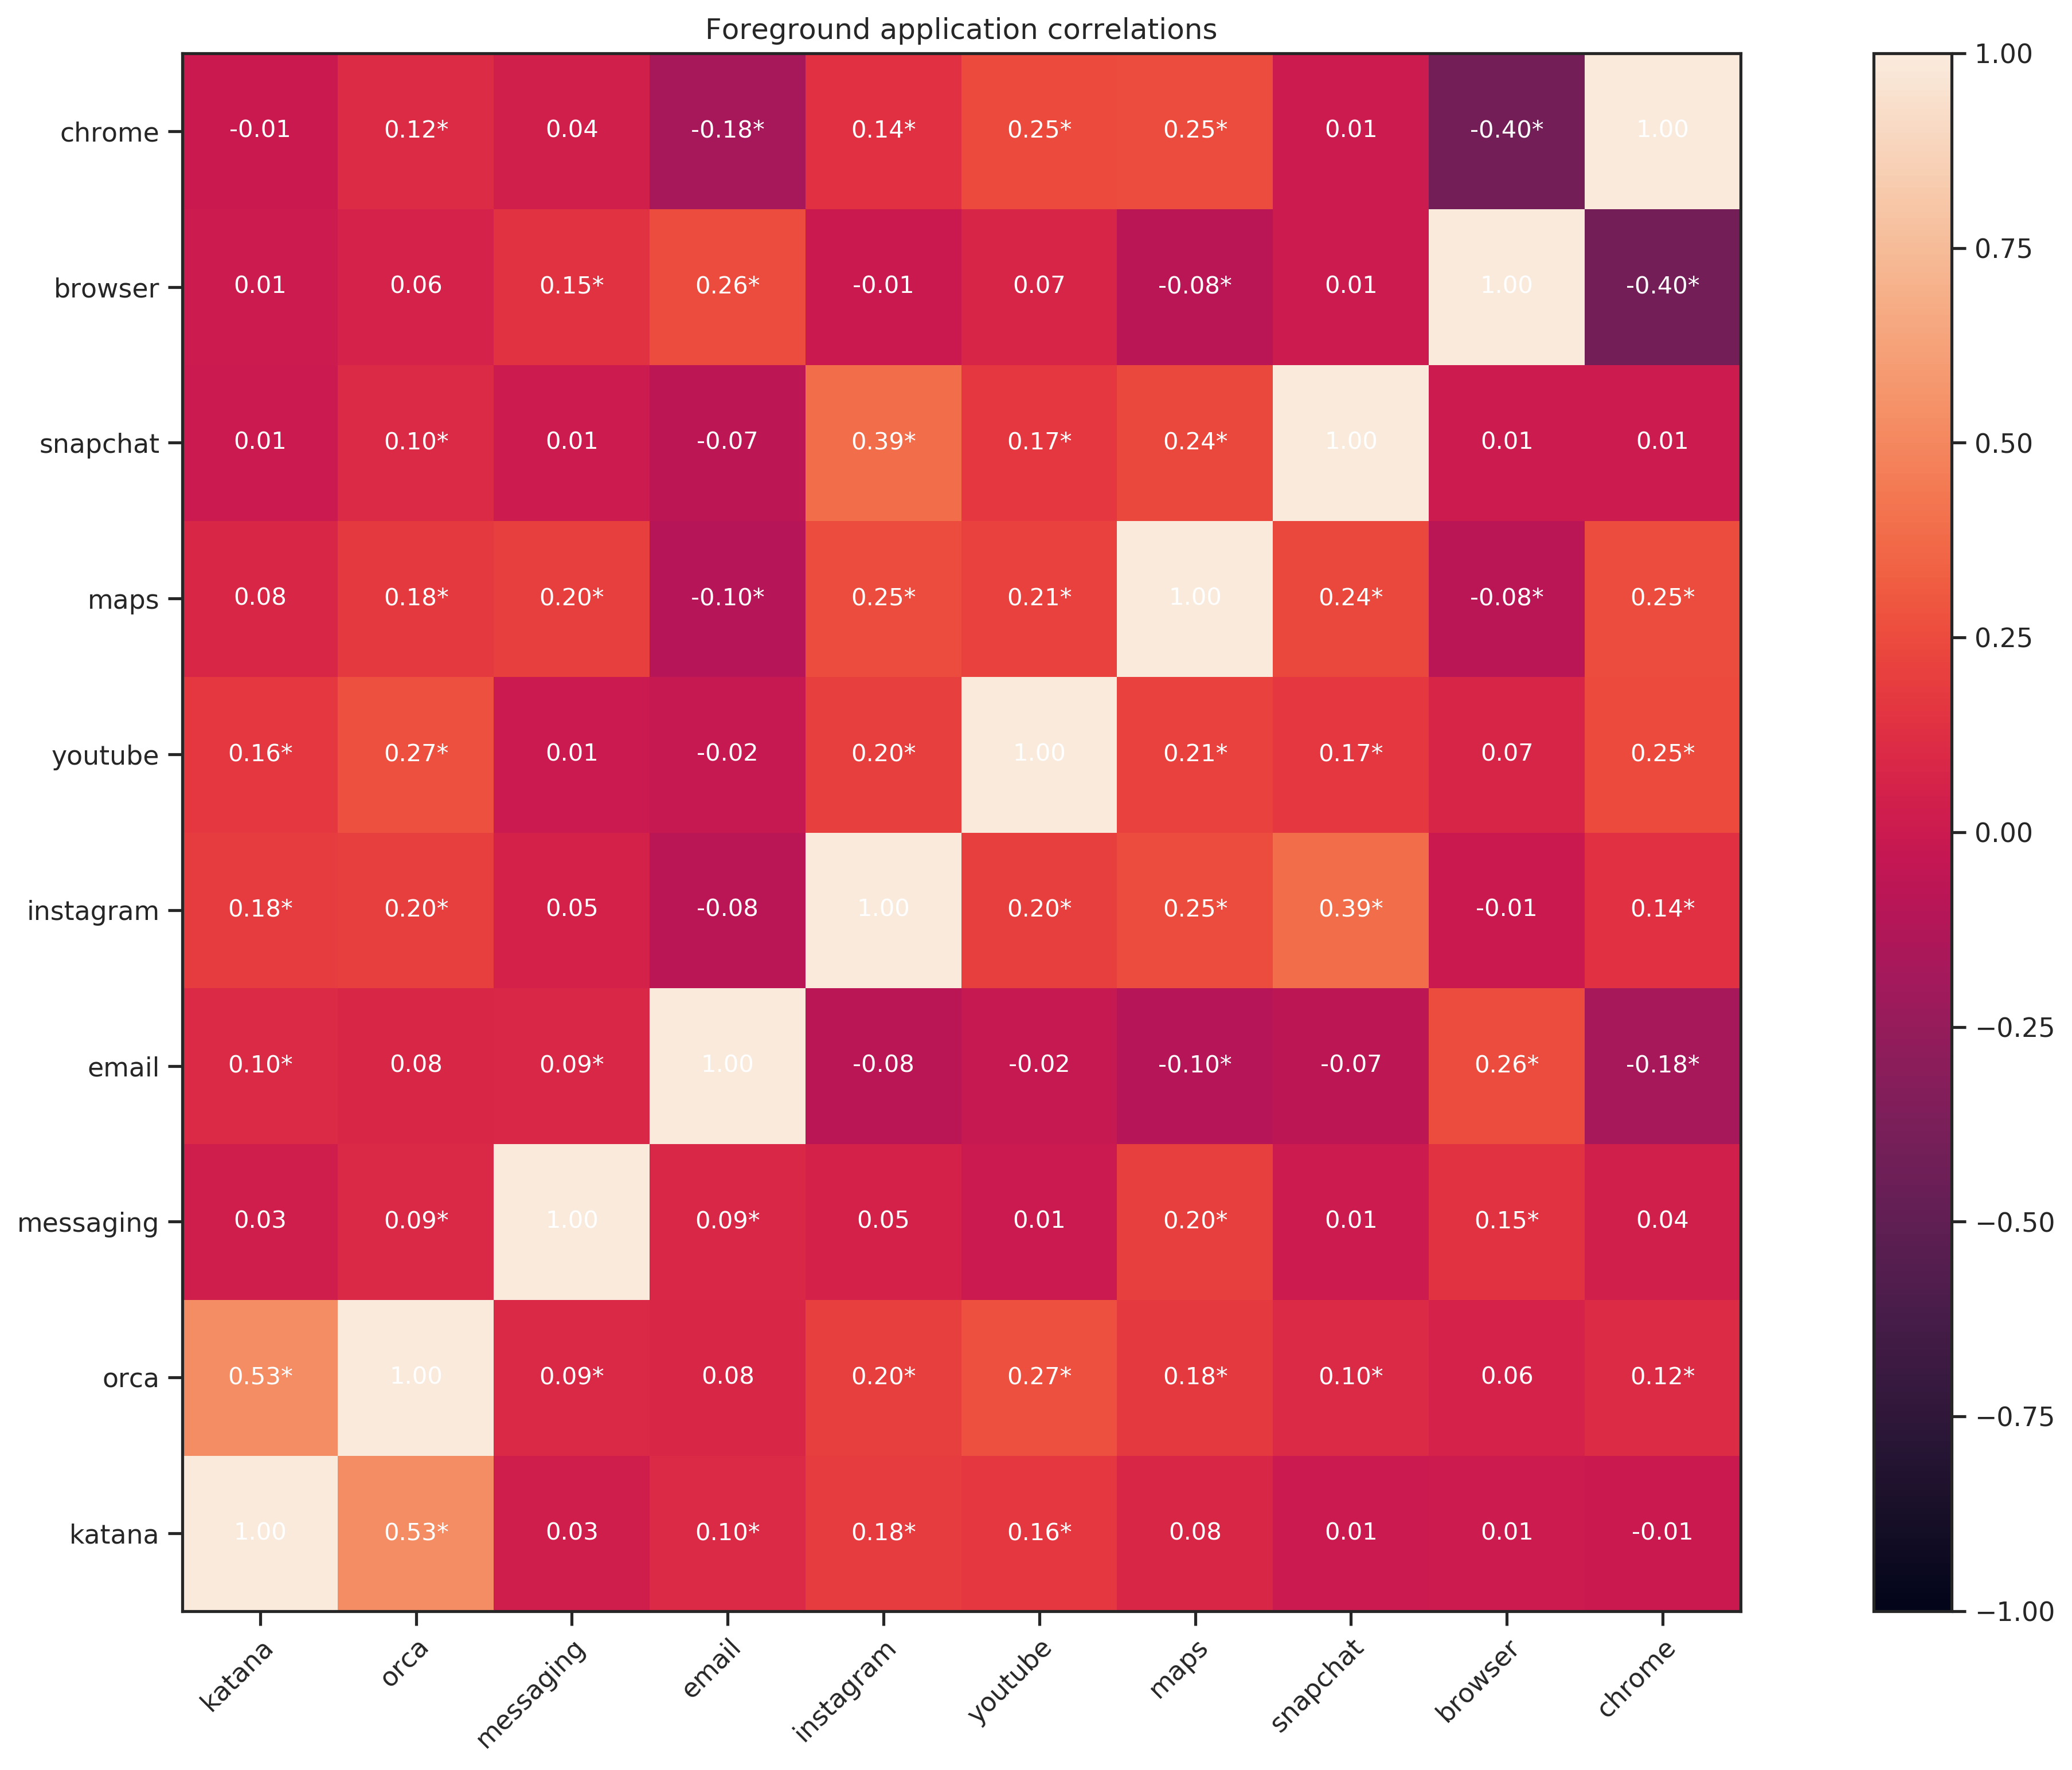

In [684]:
corr_df = fga_pca_df[fga_cols].copy()
corr_df = corr_df.dropna()

corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Foreground application correlations', 0.01, figsize=[20,12])
plt.show()

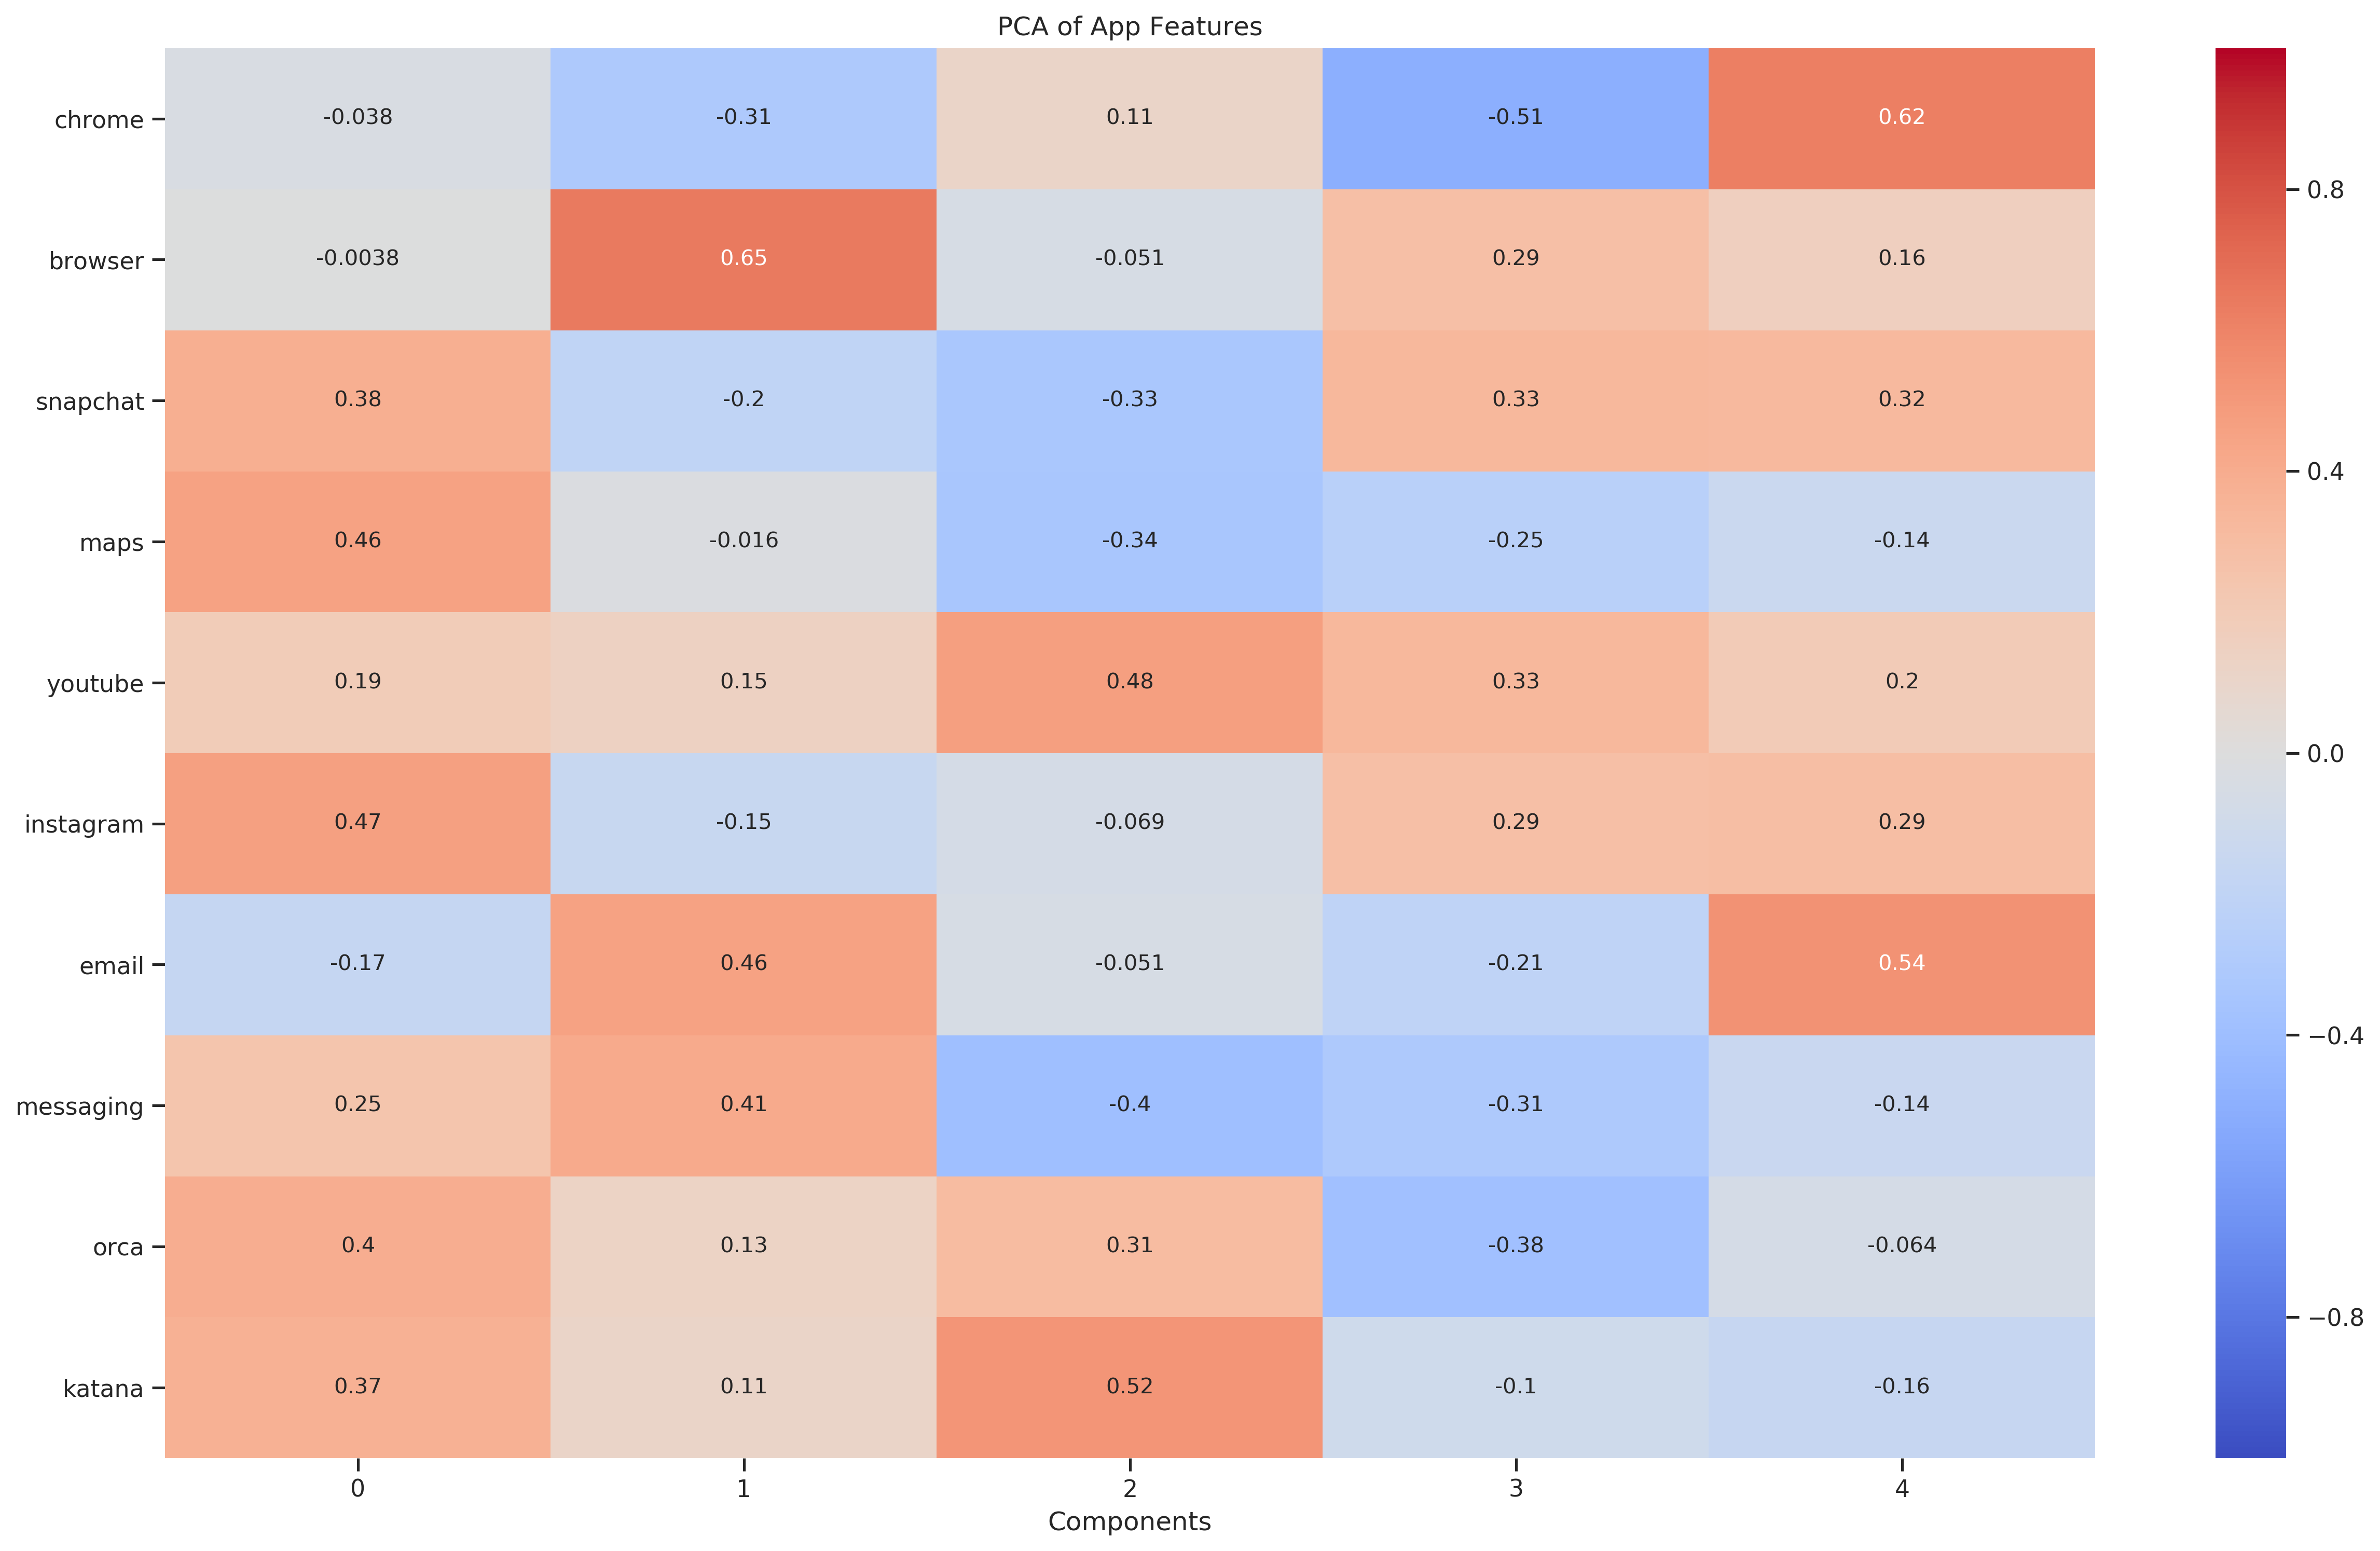

In [685]:
plot_PCA_components(fga_transformer, n_comps, fga_cols, "PCA of App Features")

In [686]:
var_df = pd.Series(fga_transformer.explained_variance_ratio_).to_frame()
var_df.columns = ['var_explained']
var_df

var_explained
0       0.145631
1       0.130001
2       0.122616
3       0.112503
4       0.098359

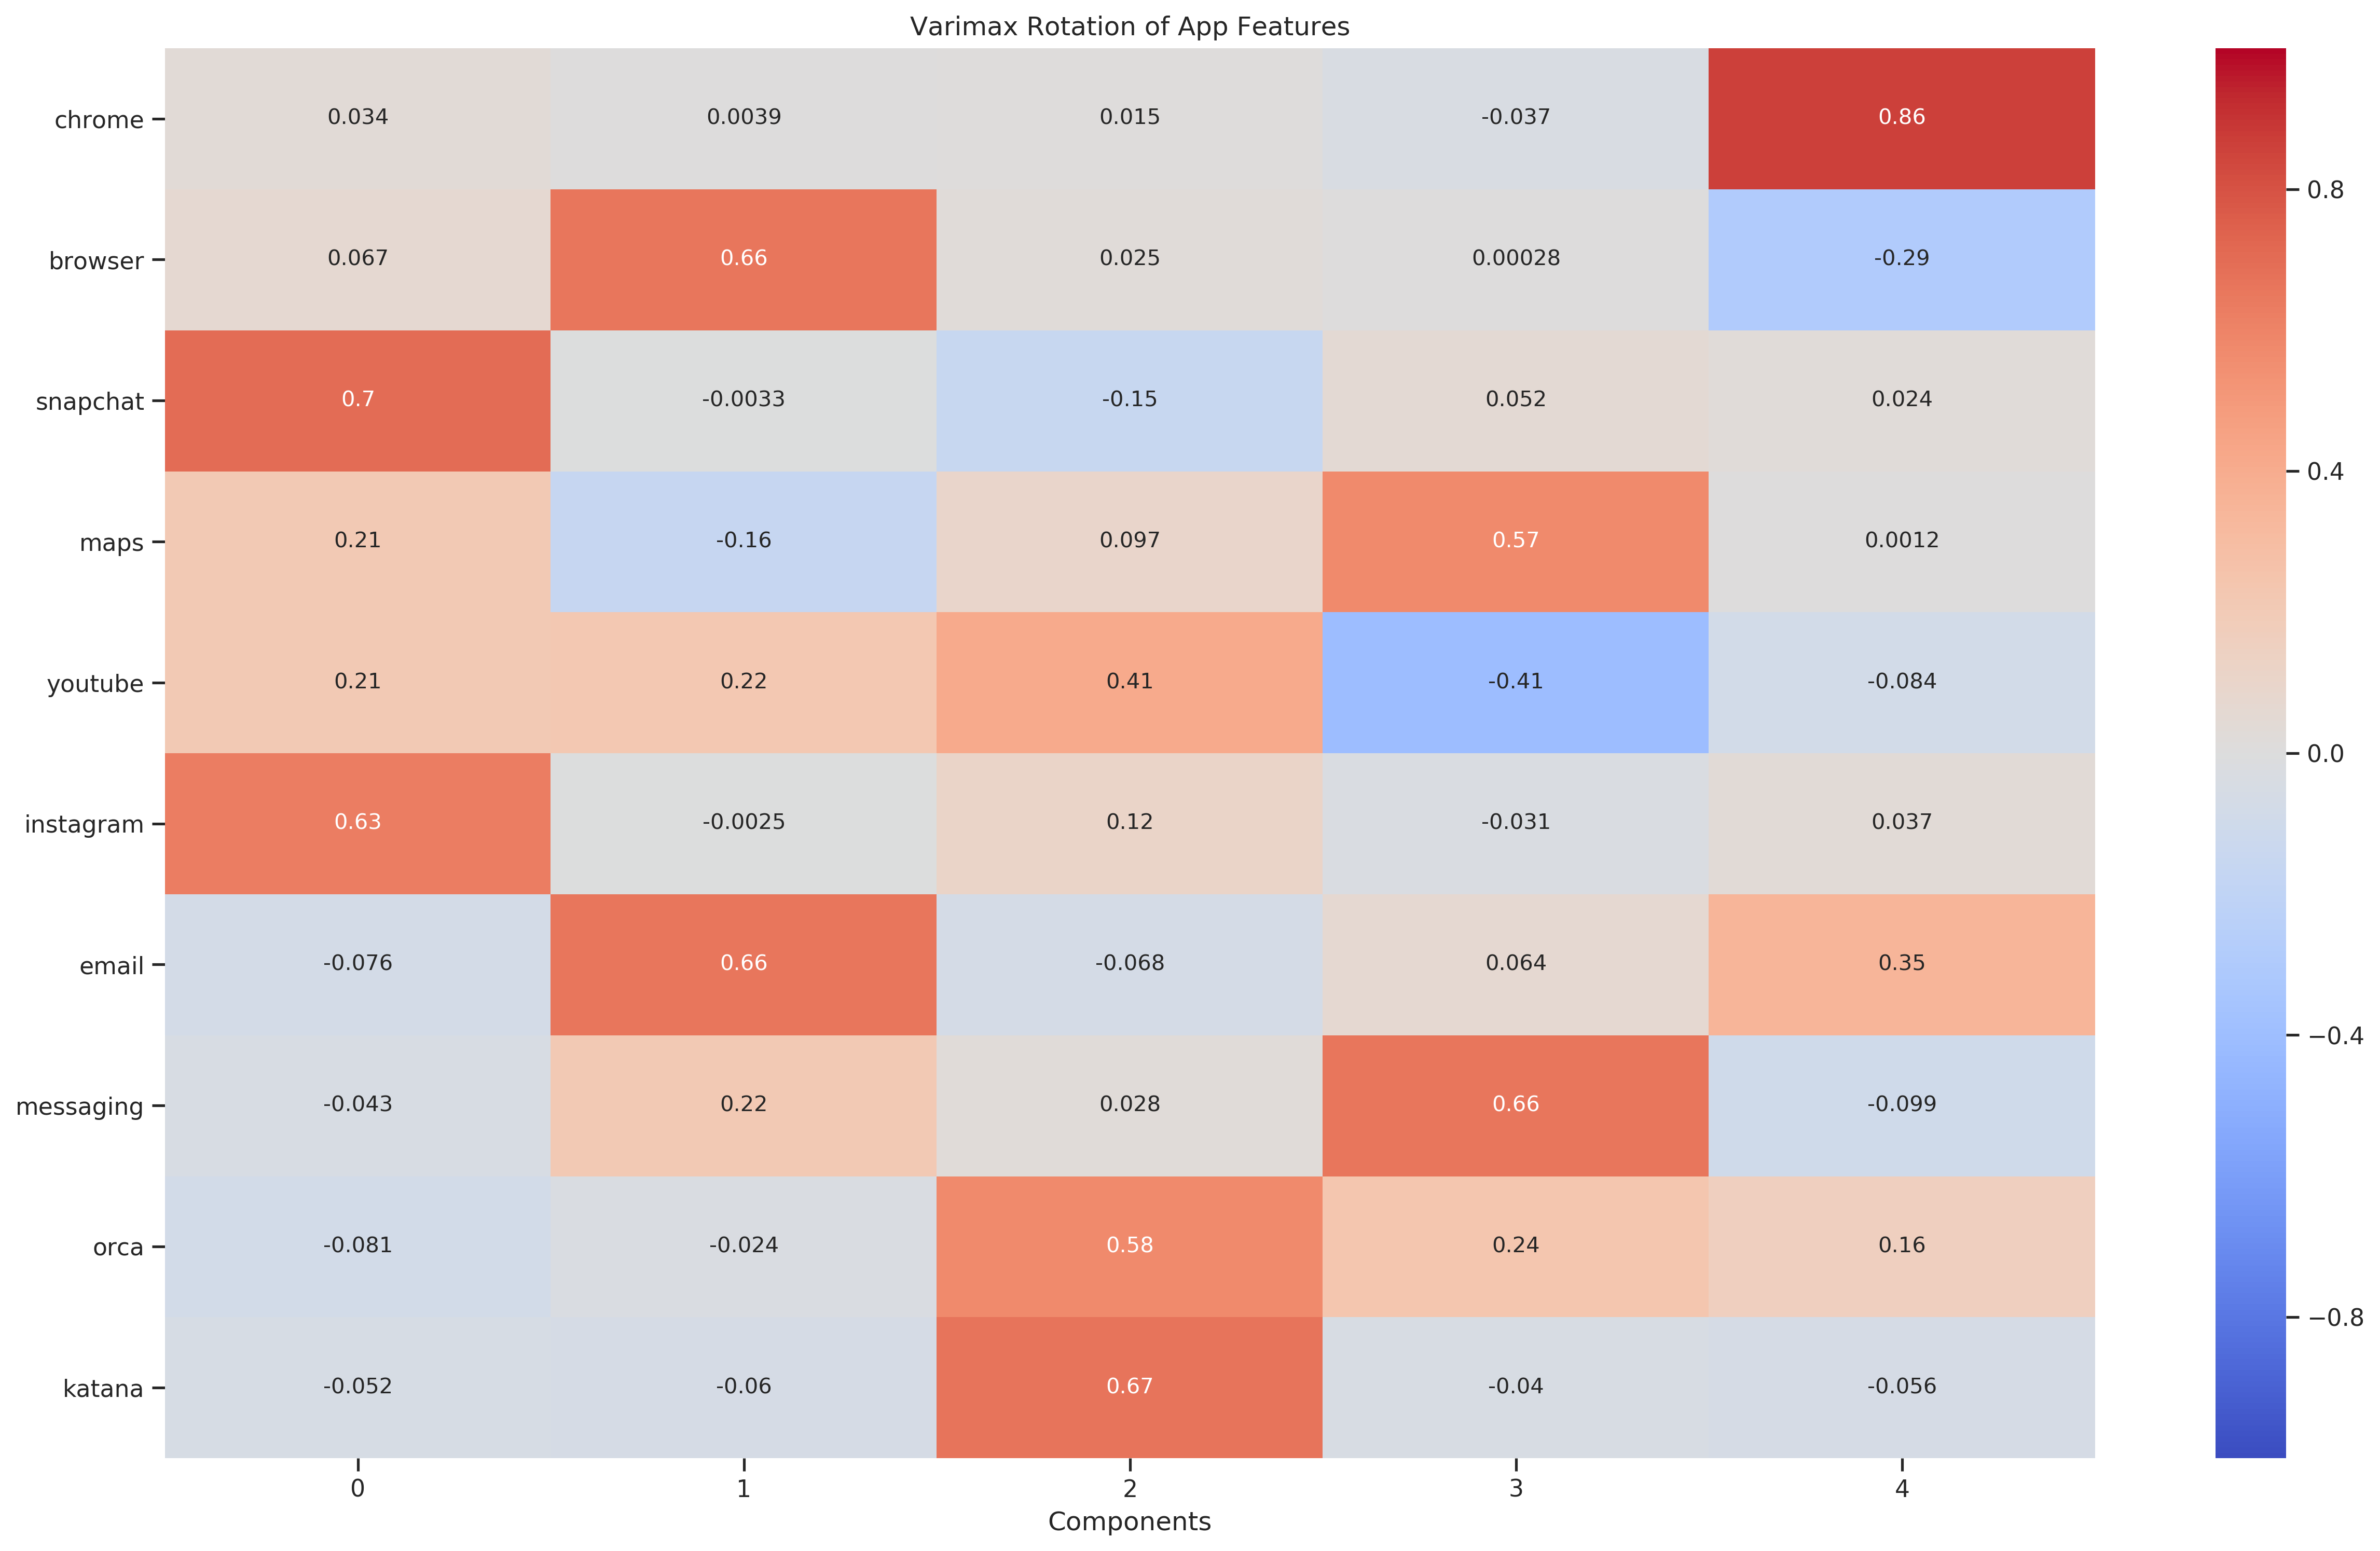

In [687]:
plot_varimax(fga_transformer, n_comps, fga_cols, "Varimax Rotation of App Features")

In [688]:
id_cols = ['pid', 'study_wk']
pc_cols = ['fga_pc{}_agg'.format(i) for i in range(n_comps)]
fga_pc = pd.DataFrame(fga_transformed,
                      columns=pc_cols)
fga_pca_df = fga_pca_df.reset_index(drop=True)
fga_pca_df = pd.concat([fga_pca_df, fga_pc], axis=1)
agg_df = agg_df.merge(fga_pca_df[id_cols + pc_cols], how='left', on=id_cols)

## Semantic Location

In [689]:
sloc_pca_df = dig_state_df.copy()
#sloc_cols = list(sloc_daily.columns[sloc_daily.columns.str.endswith('dur')])
sloc_cols = ['work_dur', 'other_dur', 'home_dur', 'food_dur', 'exercise_dur', 'anothers_home_dur']
# fillna with participant mean
#sloc_pca_df[sloc_cols] = sloc_pca_df.groupby('pid')[sloc_cols].transform(lambda x: x.fillna(x.mean()))

sloc_pca_df[sloc_cols] = StandardScaler().fit_transform(sloc_pca_df[sloc_cols])

#sloc_pca_df[sloc_cols] = (sloc_pca_df[sloc_cols] - sloc_pca_df[sloc_cols].mean()) / sloc_pca_df[sloc_cols].std()
sloc_pca_df = sloc_pca_df.dropna(how='any', subset=sloc_cols)

n_comps = 4

n_cols = len(sloc_cols)
sloc_transformer = PCA(n_components=n_comps, random_state=0)
sloc_transformed = sloc_transformer.fit_transform(sloc_pca_df[sloc_cols])

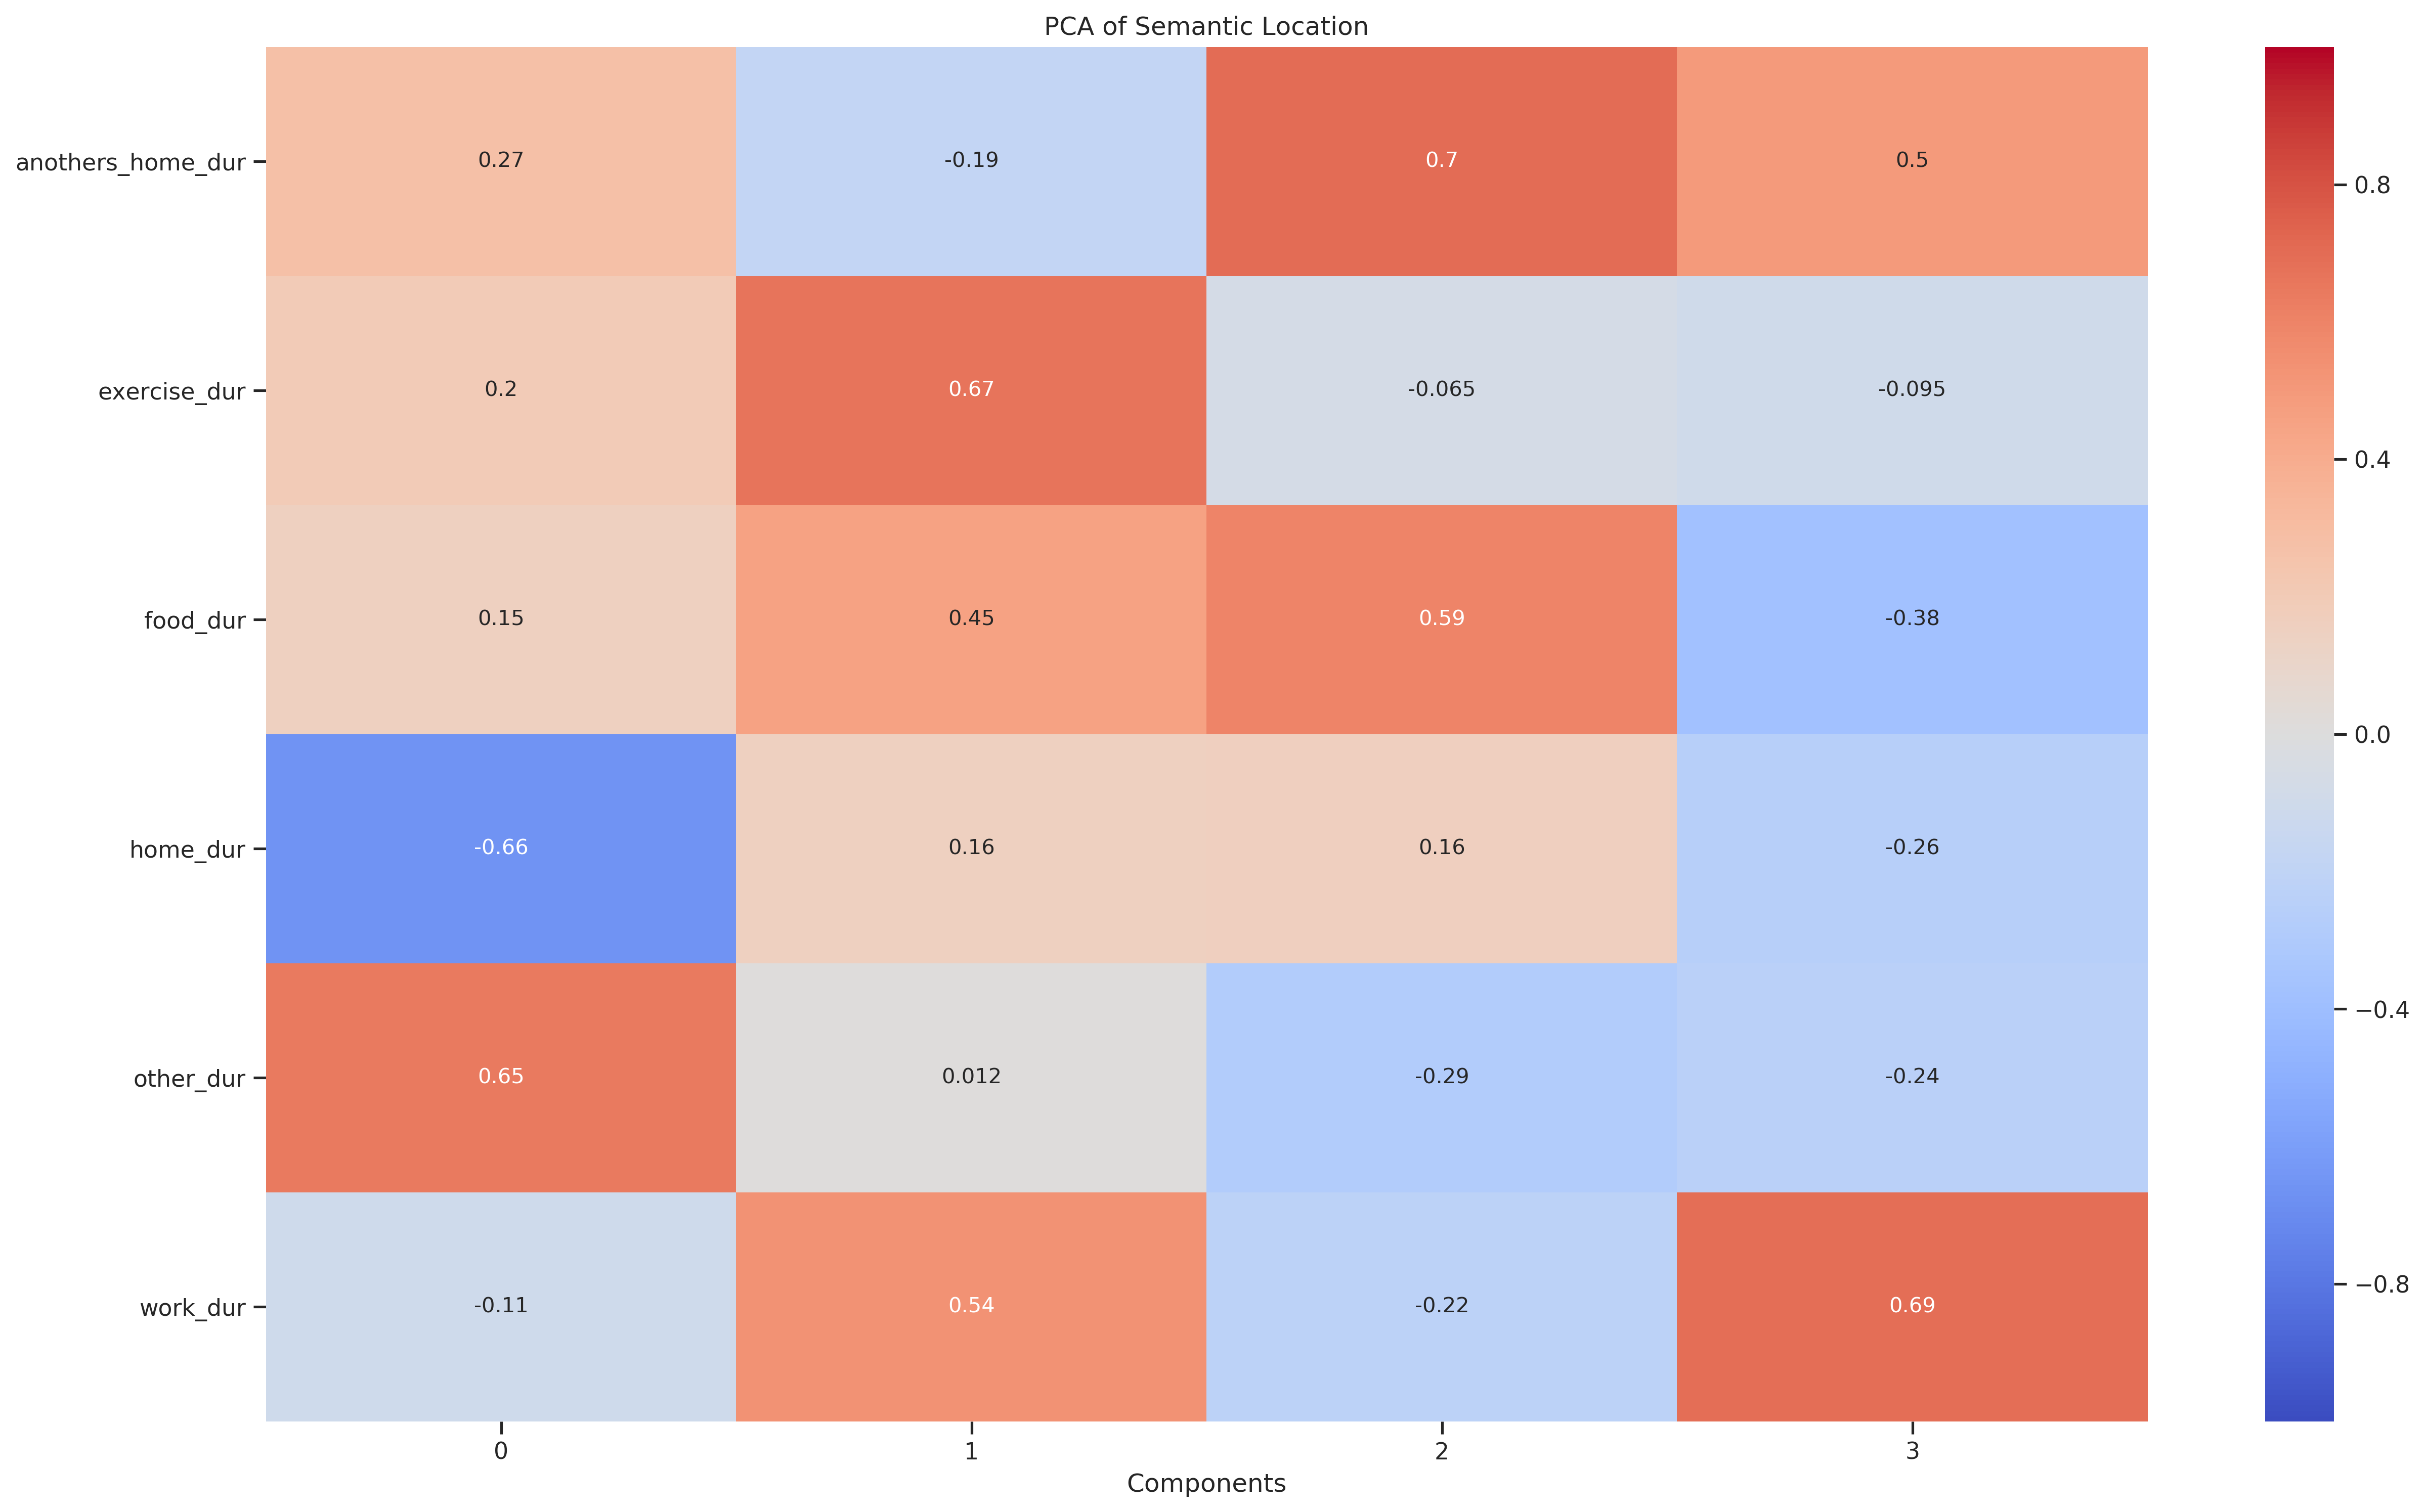

In [690]:
plot_PCA_components(sloc_transformer, n_comps, sloc_cols, "PCA of Semantic Location")

In [691]:
get_var_explained(sloc_transformer)

var_explained
0       0.234097
1       0.207238
2       0.177291
3       0.155272

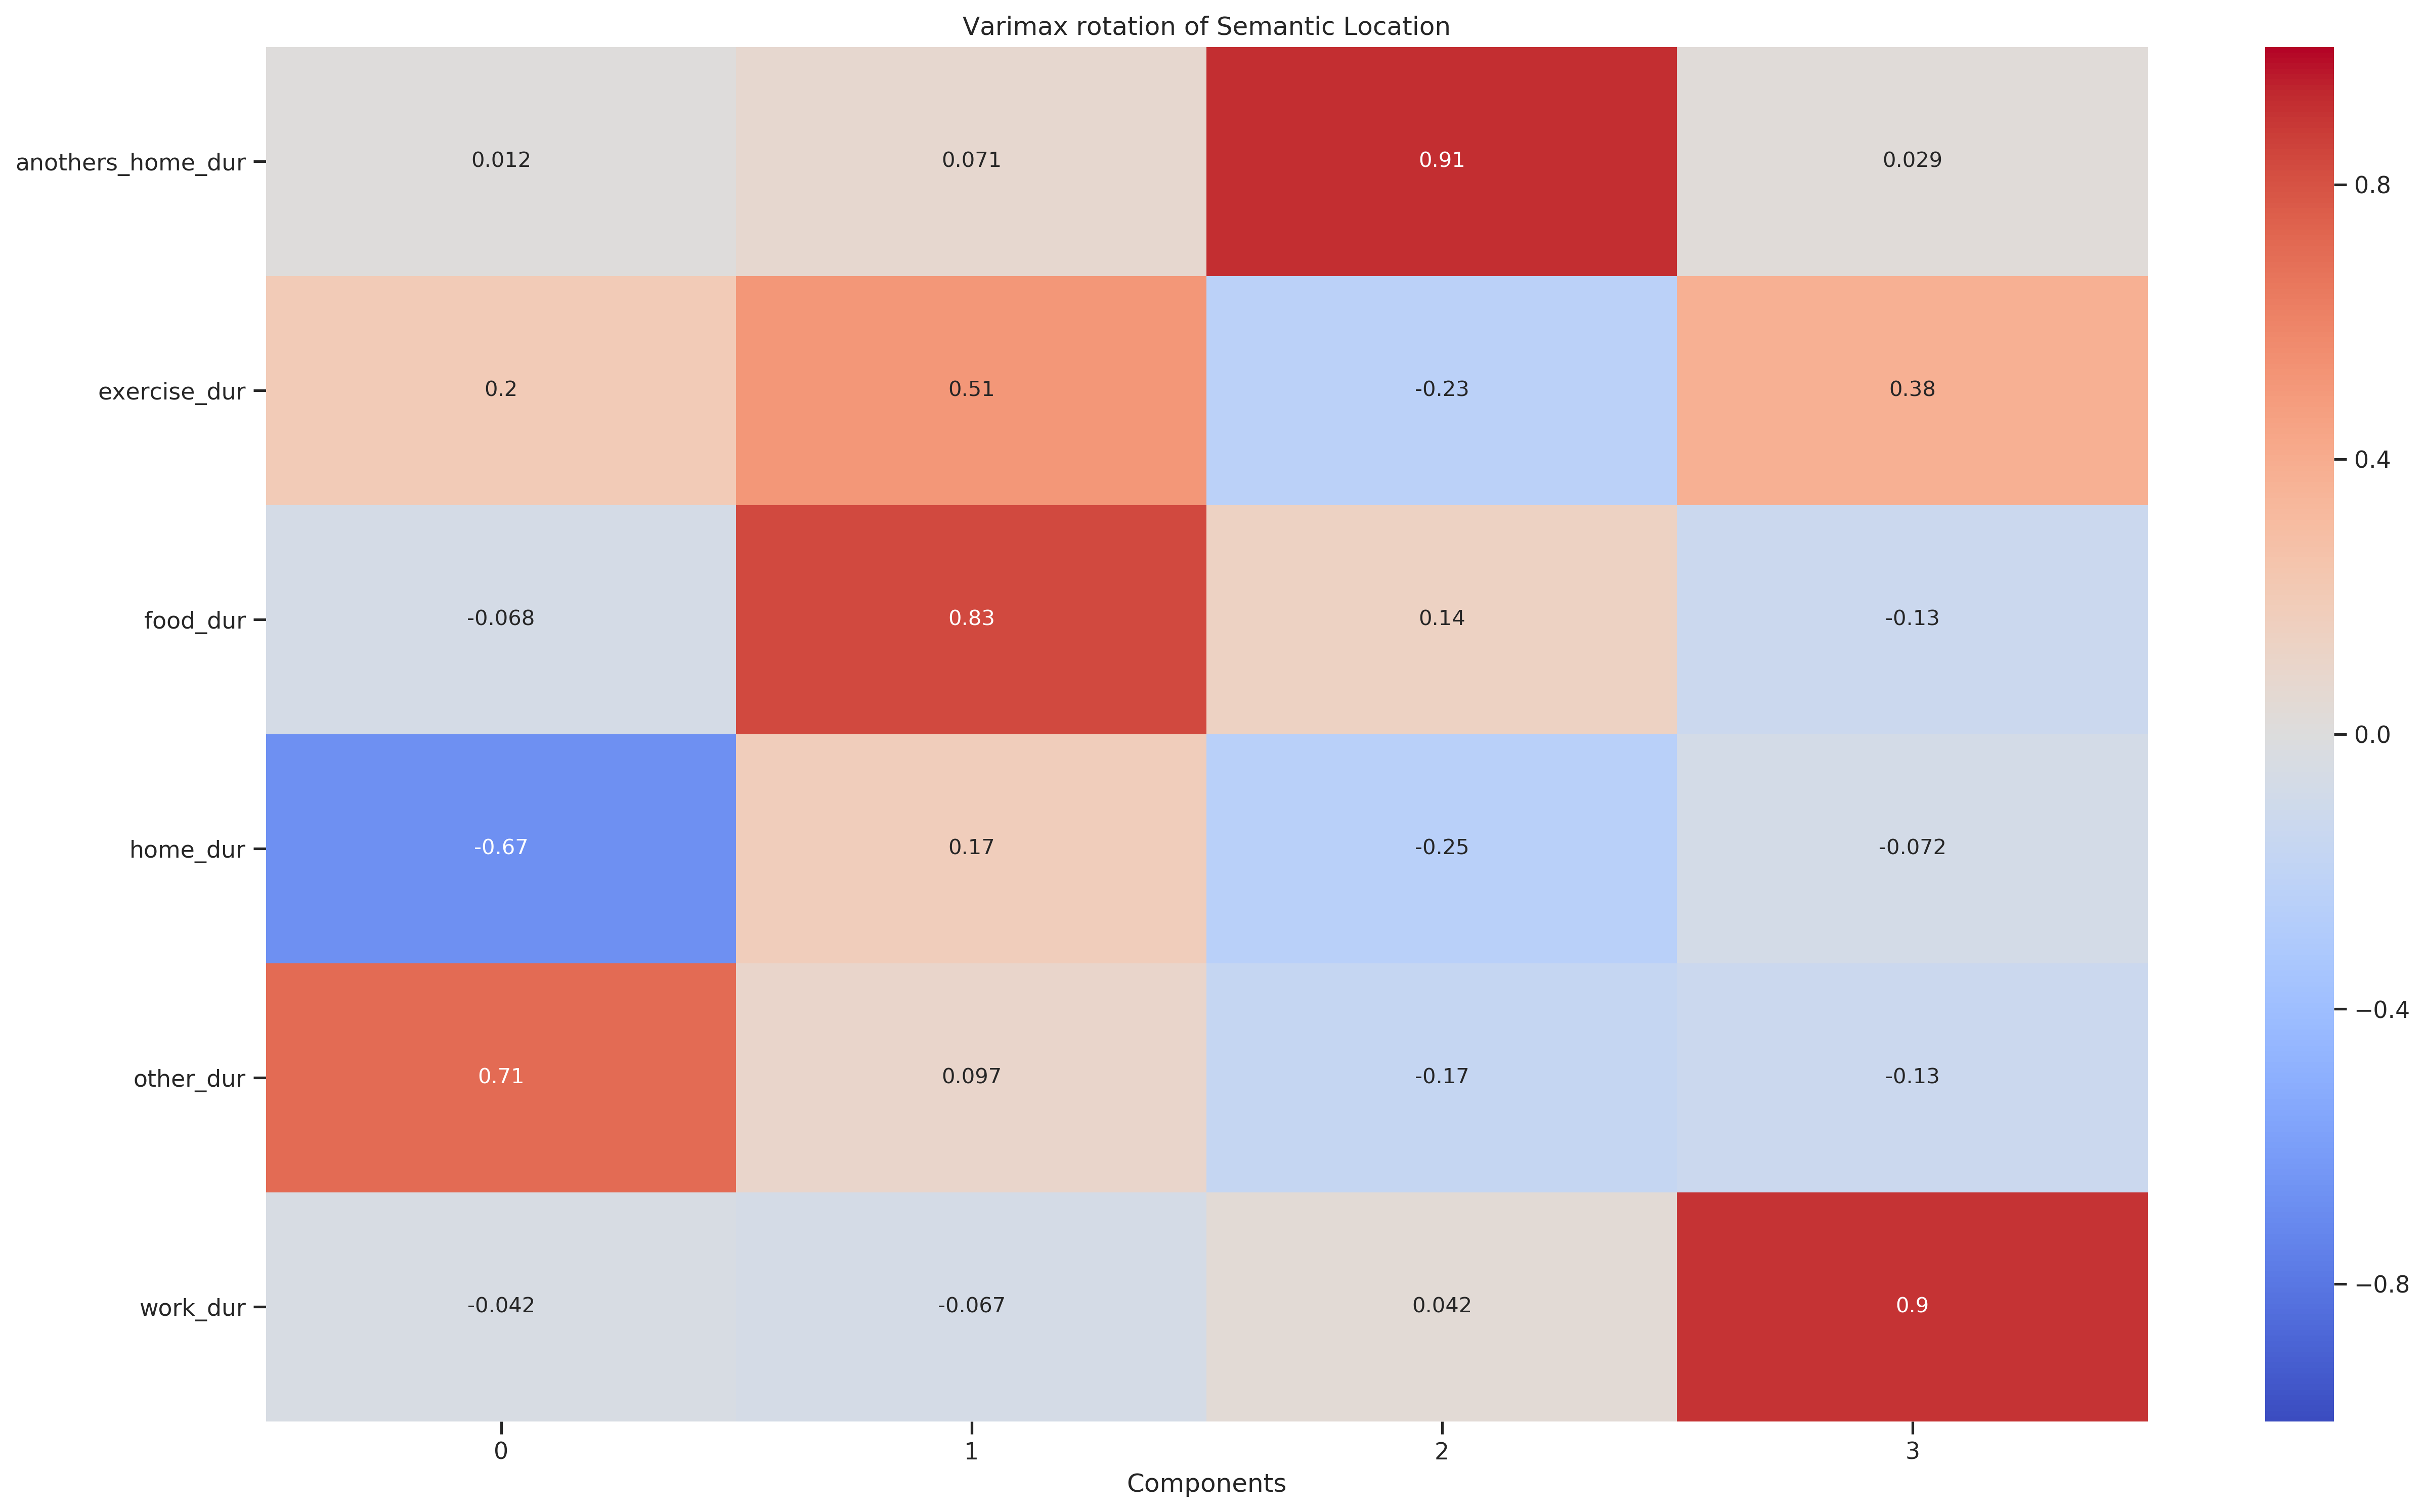

In [692]:
plot_varimax(sloc_transformer, n_comps, sloc_cols, "Varimax rotation of Semantic Location")

In [693]:
pc_cols = ['sloc_pc{}_agg'.format(i) for i in range(n_comps)]
sloc_pc = pd.DataFrame(sloc_transformed,
                      columns=pc_cols)
sloc_pca_df = sloc_pca_df.reset_index(drop=True)
sloc_pca_df = pd.concat([sloc_pca_df, sloc_pc], axis=1)
agg_df = agg_df.merge(sloc_pca_df[id_cols + pc_cols], how='left', on=id_cols)

## Communication

In [696]:
comm_pca_df = dig_state_df.copy()
comm_cols = cal_cols + sms_cols

# fillna with participant mean
#comm_pca_df[comm_cols] = comm_pca_df.groupby('pid')[comm_cols].transform(lambda x: x.fillna(x.mean()))

comm_pca_df[comm_cols] = StandardScaler().fit_transform(comm_pca_df[comm_cols])


#comm_pca_df[comm_cols] = (comm_pca_df[comm_cols] - comm_pca_df[comm_cols].mean()) / comm_pca_df[comm_cols].std()
comm_pca_df = comm_pca_df.dropna(how='any', subset=comm_cols)

#comm_pca_df = comm_pca_df[~comm_pca_df['katana'].isna()]

n_comps = 2

n_cols = len(comm_cols)
comm_transformer = PCA(n_components=n_comps, random_state=0)
comm_transformed = comm_transformer.fit_transform(comm_pca_df[comm_cols])

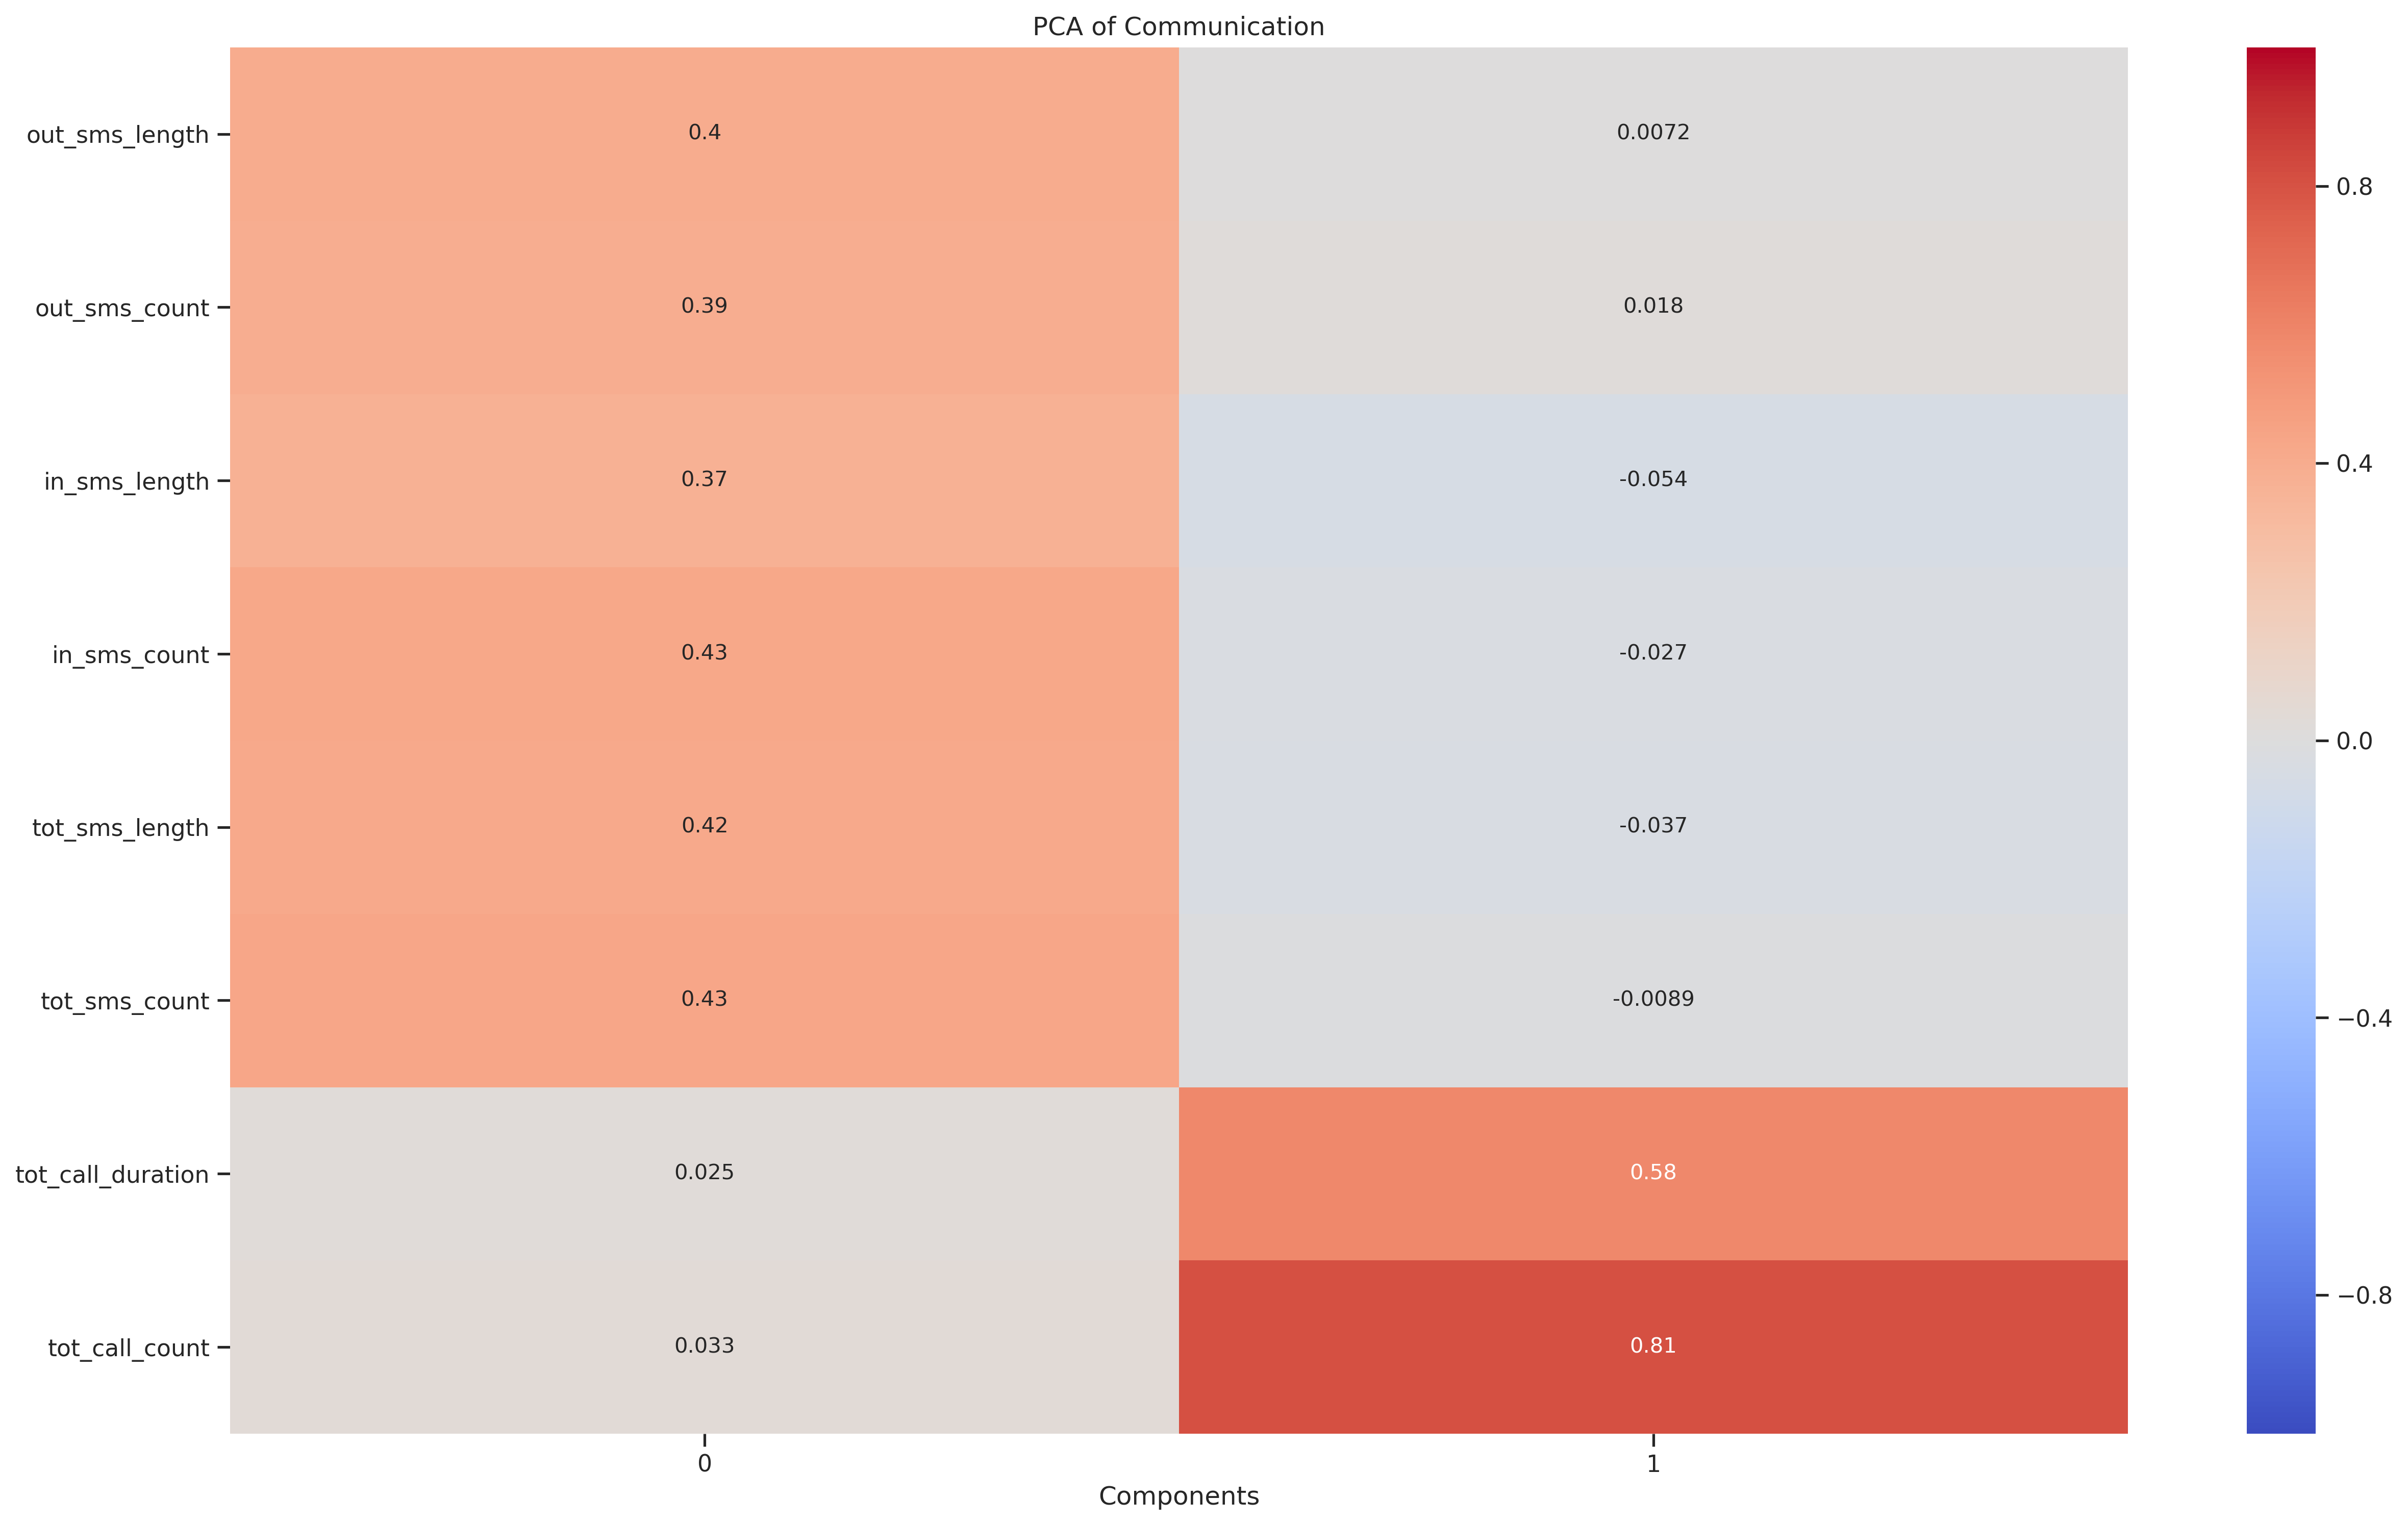

In [697]:
plot_PCA_components(comm_transformer, n_comps, comm_cols, "PCA of Communication")

In [698]:
get_var_explained(comm_transformer)

var_explained
0       0.696221
1       0.185280

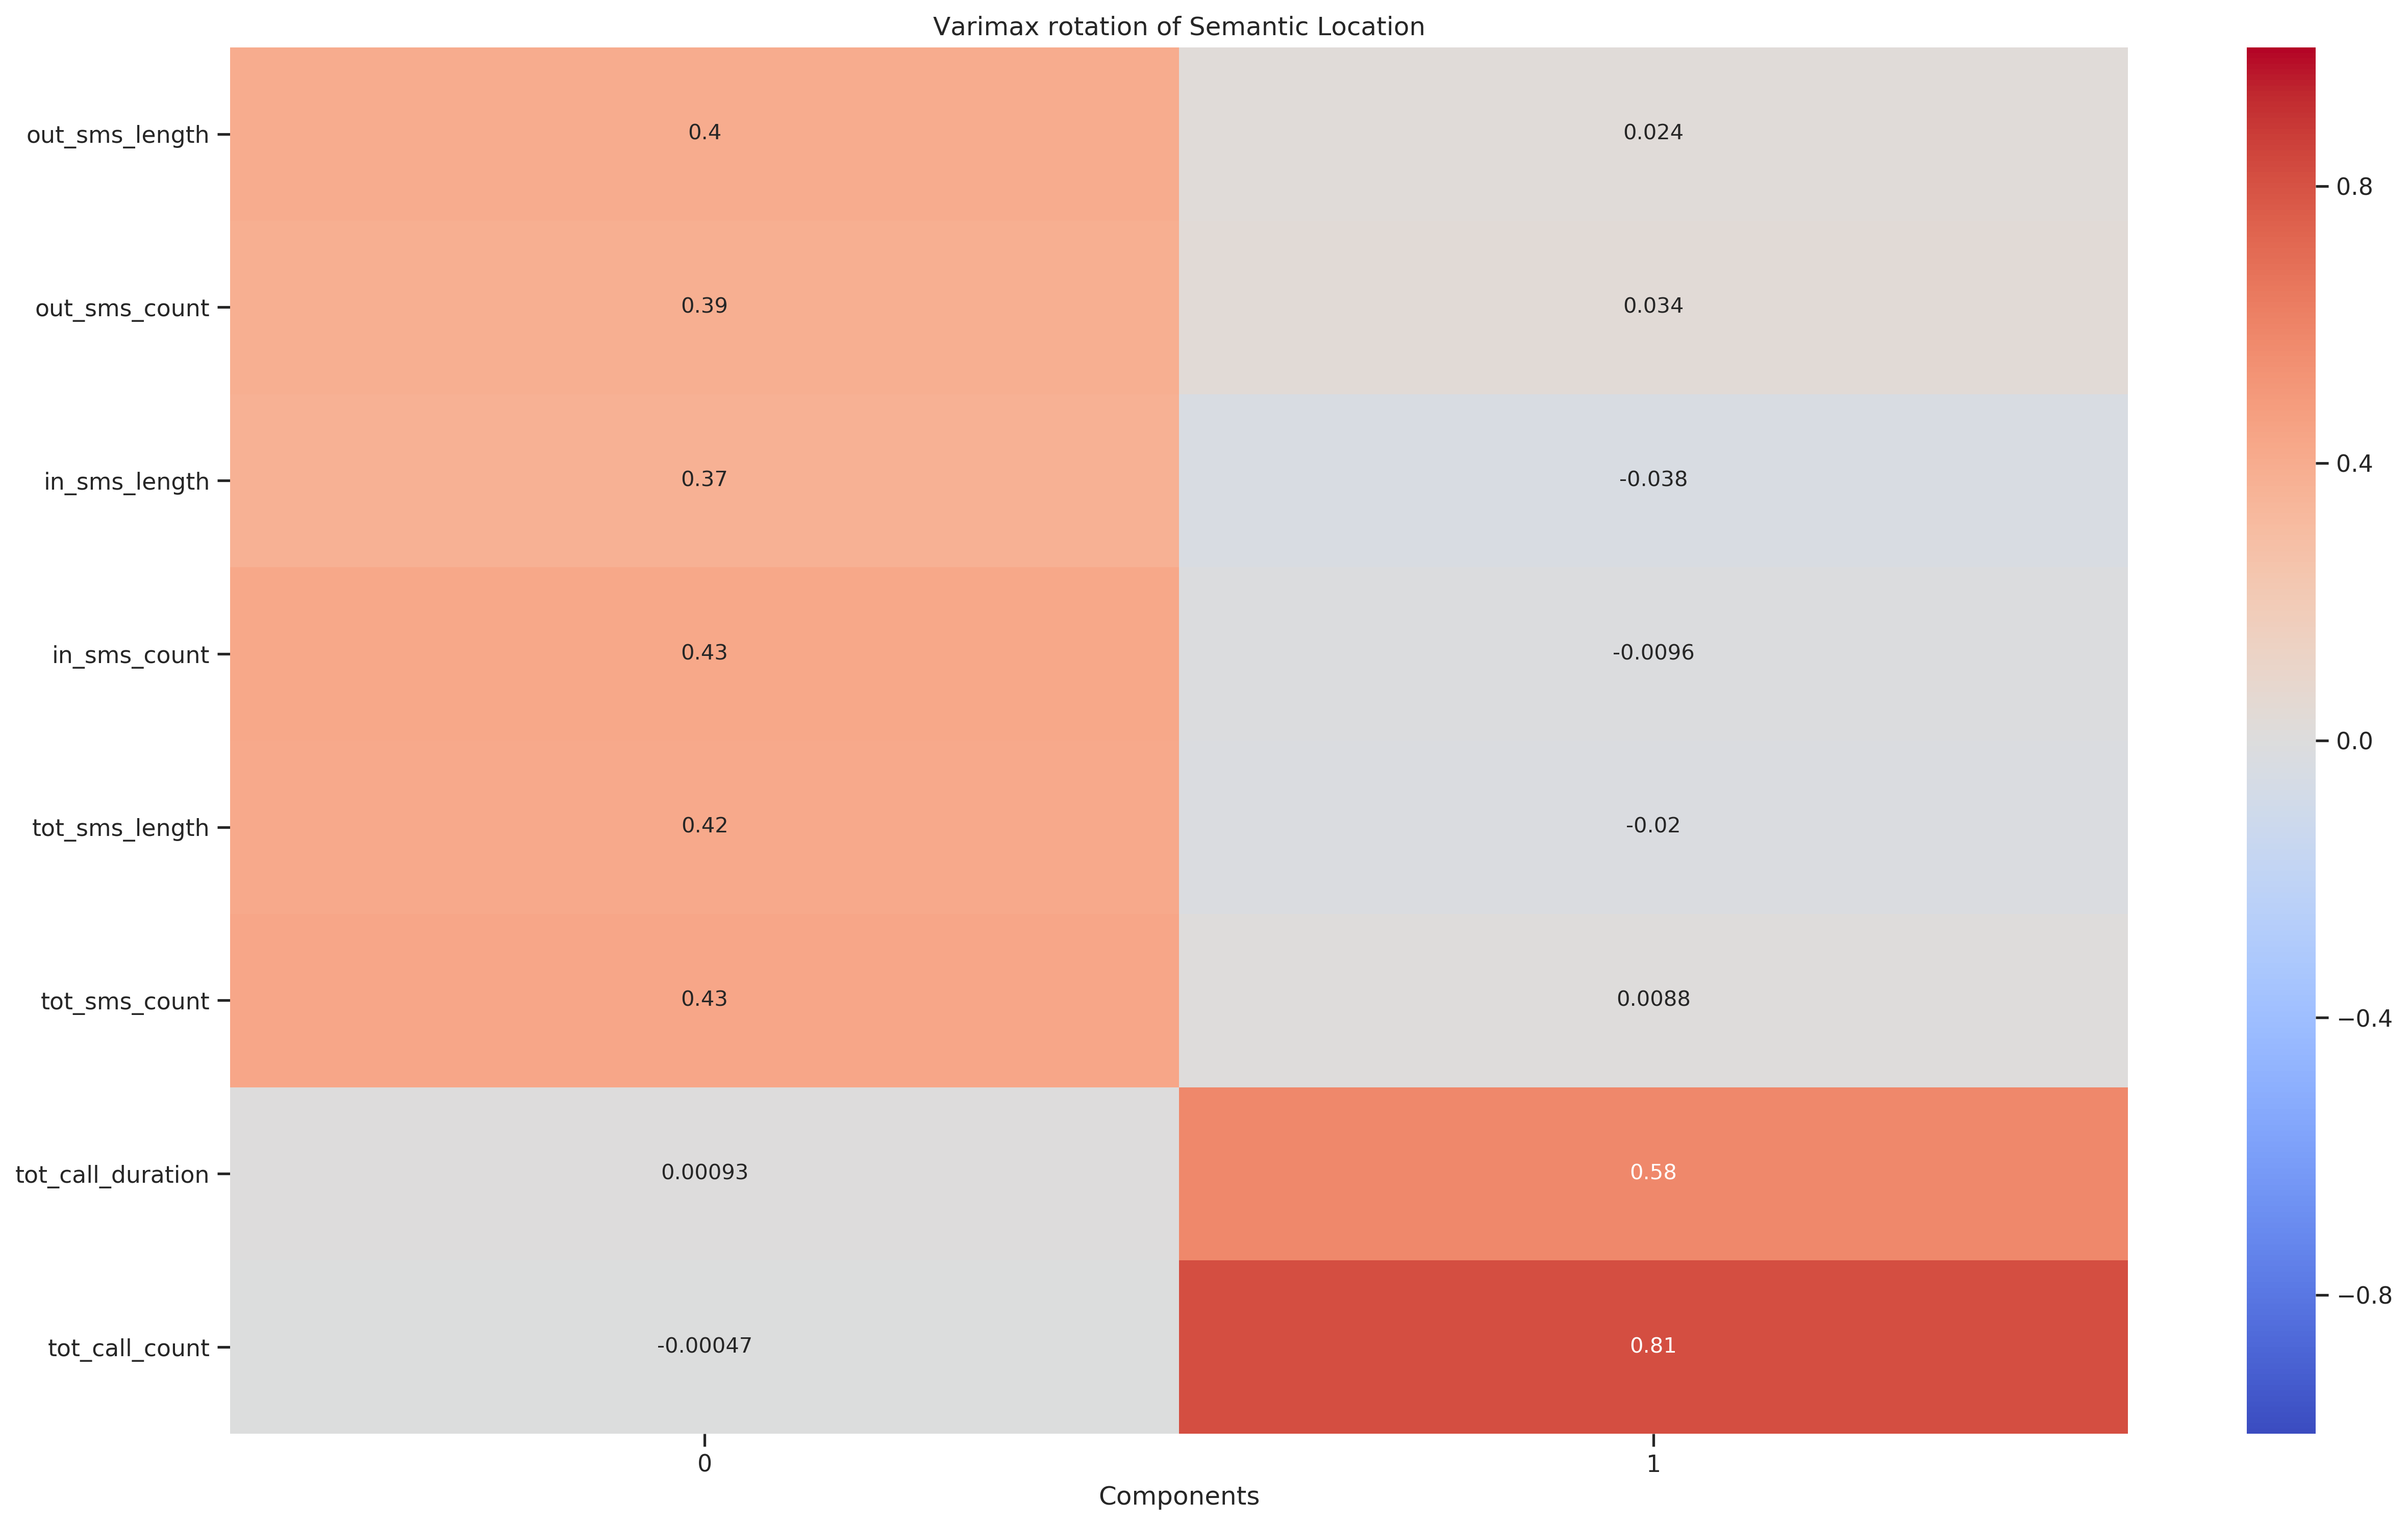

In [699]:
plot_varimax(comm_transformer, n_comps, comm_cols, "Varimax rotation of Semantic Location")

In [700]:
agg_df[sms_cols] = (agg_df[sms_cols] - agg_df[sms_cols].mean()) / agg_df[sms_cols].std()
agg_df[cal_cols] = (agg_df[cal_cols] - agg_df[cal_cols].mean()) / agg_df[cal_cols].std()
agg_df['sms_agg'] = agg_df[sms_cols].mean(axis=1)
agg_df['cal_agg'] = agg_df[cal_cols].mean(axis=1)

## Fused Location

In [701]:
loc_pca_df = dig_state_df.copy()
loc_cols = circ_cols + fus_cols

# fillna with participant mean
#loc_pca_df[loc_cols] = loc_pca_df.groupby('pid')[loc_cols].transform(lambda x: x.fillna(x.mean()))

loc_pca_df[loc_cols] = StandardScaler().fit_transform(loc_pca_df[loc_cols])


#loc_pca_df[loc_cols] = (loc_pca_df[loc_cols] - loc_pca_df[loc_cols].mean()) / loc_pca_df[loc_cols].std()

loc_pca_df = loc_pca_df.dropna(how='any', subset=loc_cols)
#loc_pca_df = loc_pca_df[~loc_pca_df['katana'].isna()]

n_comps = 3

n_cols = len(loc_cols)
loc_transformer = PCA(n_components=n_comps, random_state=0)
loc_transformed = loc_transformer.fit_transform(loc_pca_df[loc_cols])

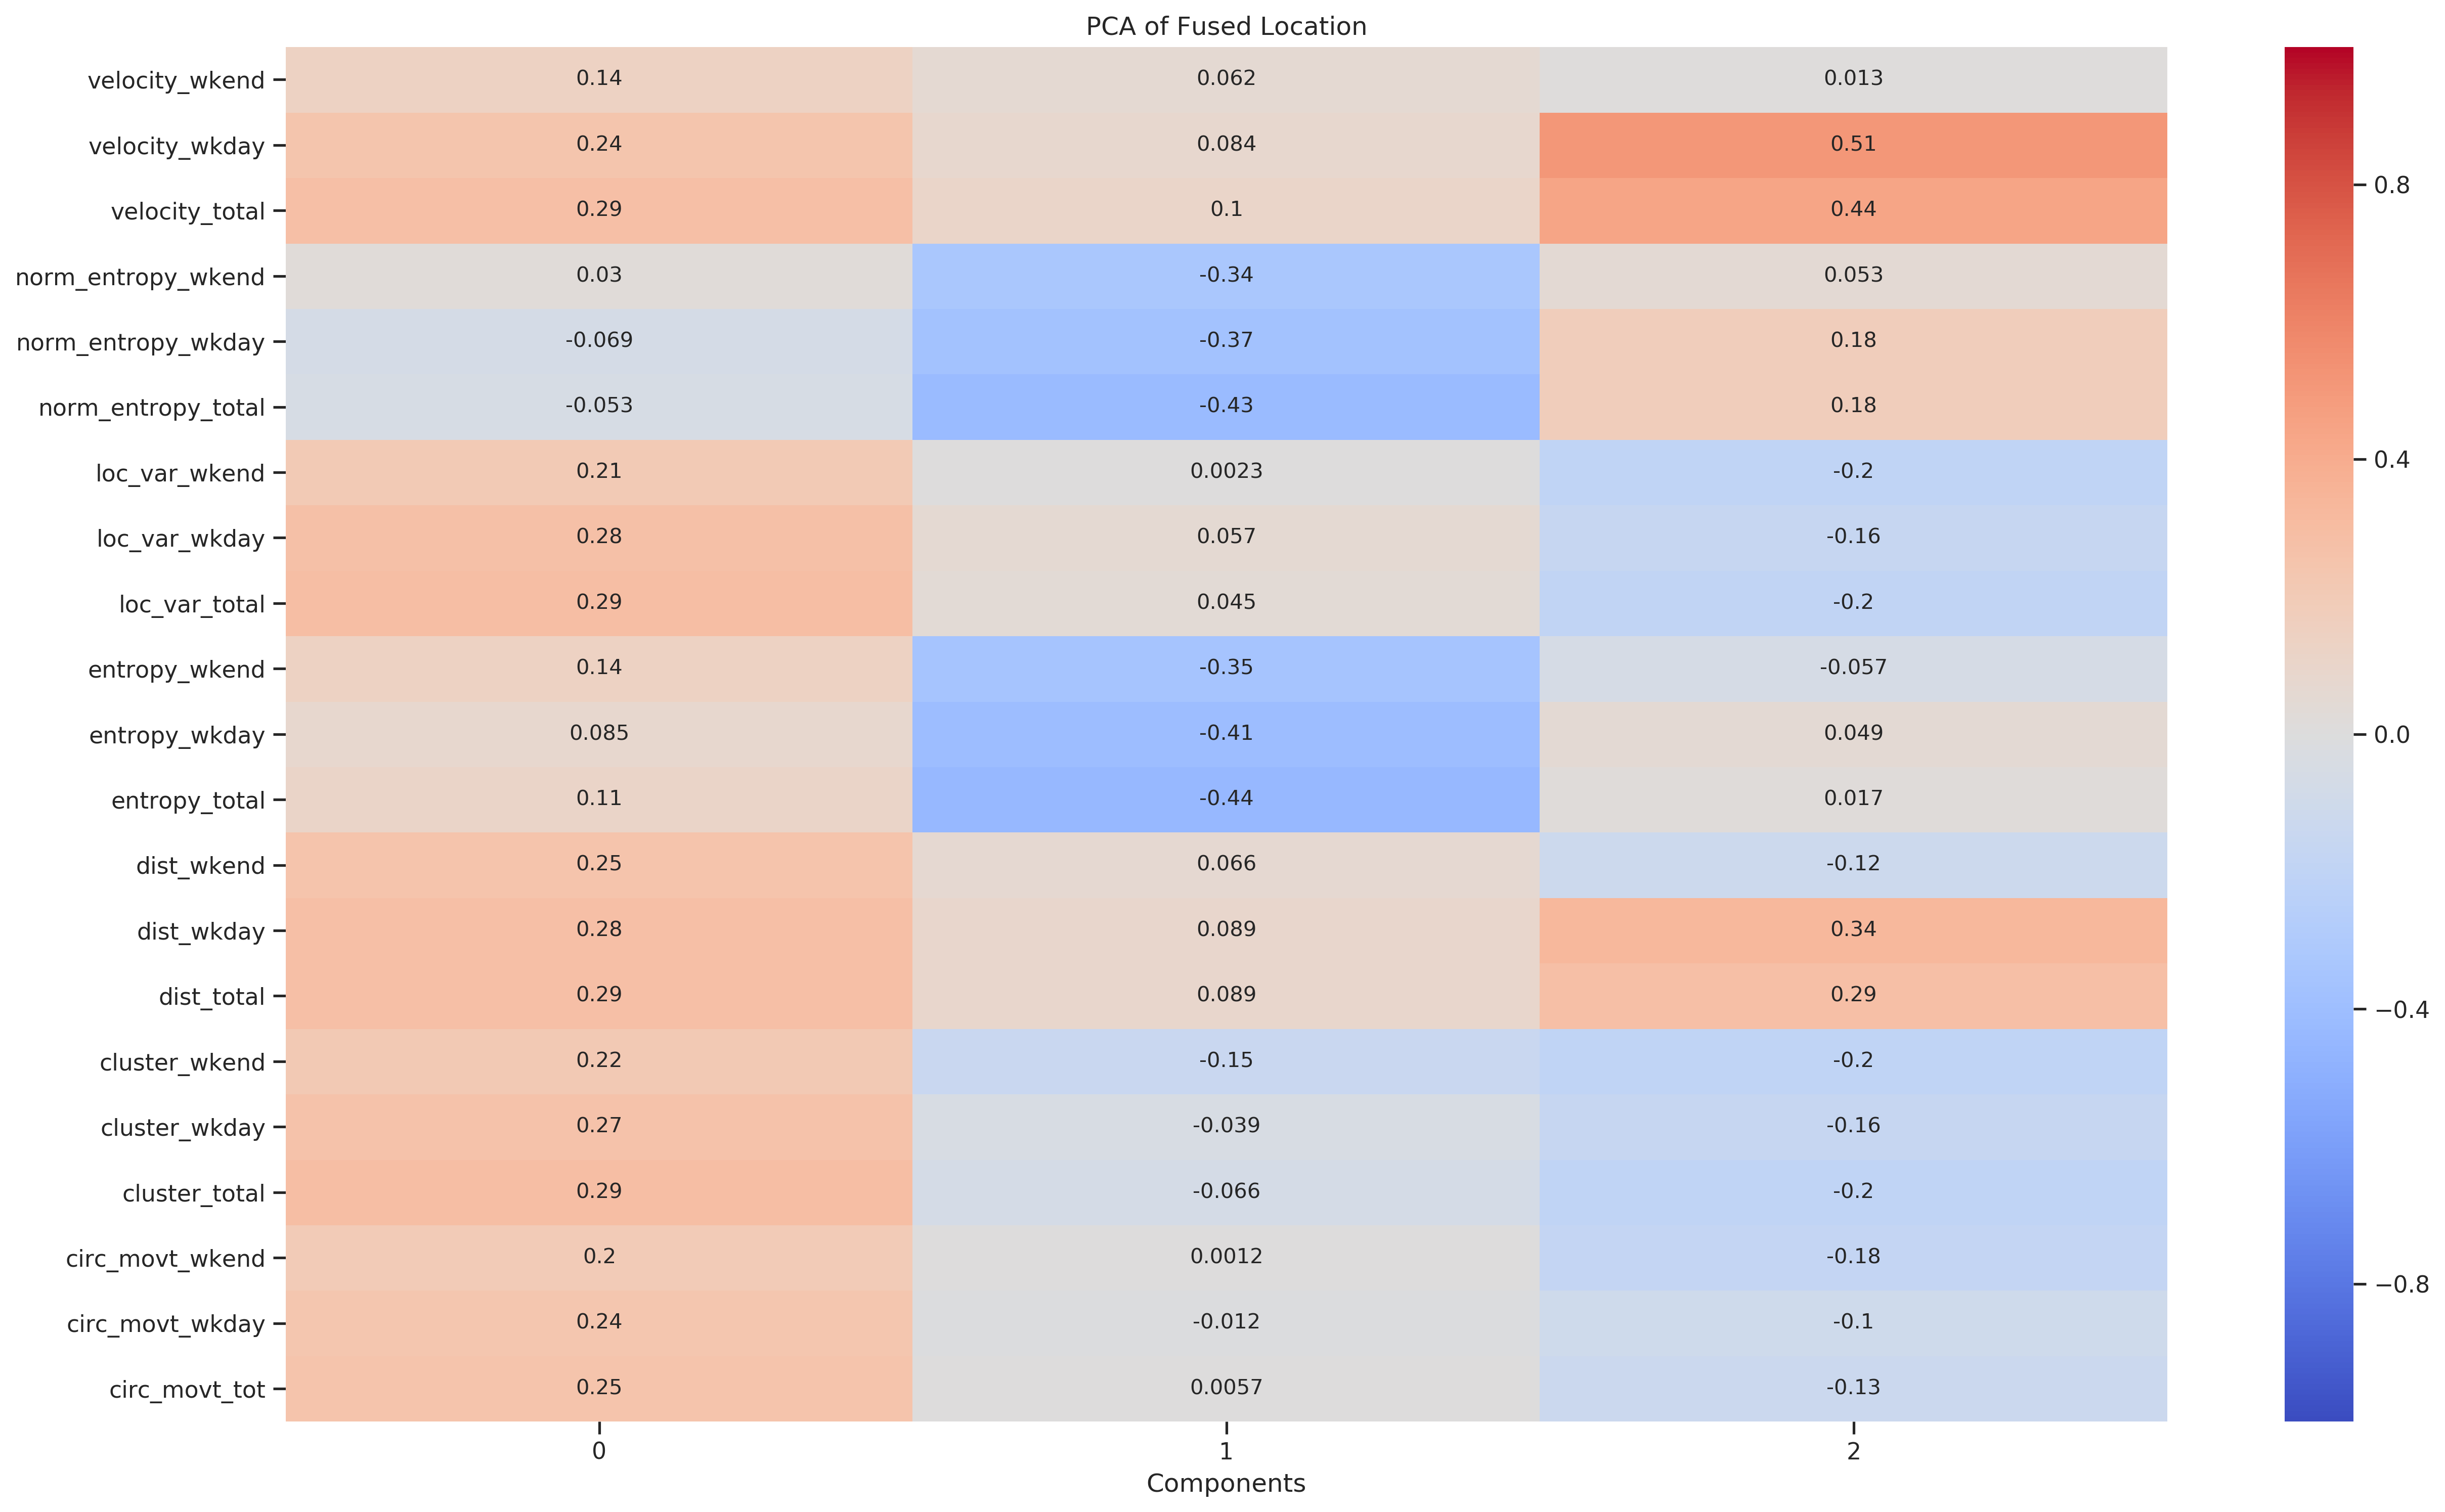

In [702]:
plot_PCA_components(loc_transformer, n_comps, loc_cols, "PCA of Fused Location")

In [703]:
get_var_explained(loc_transformer)

var_explained
0       0.376982
1       0.171600
2       0.134069

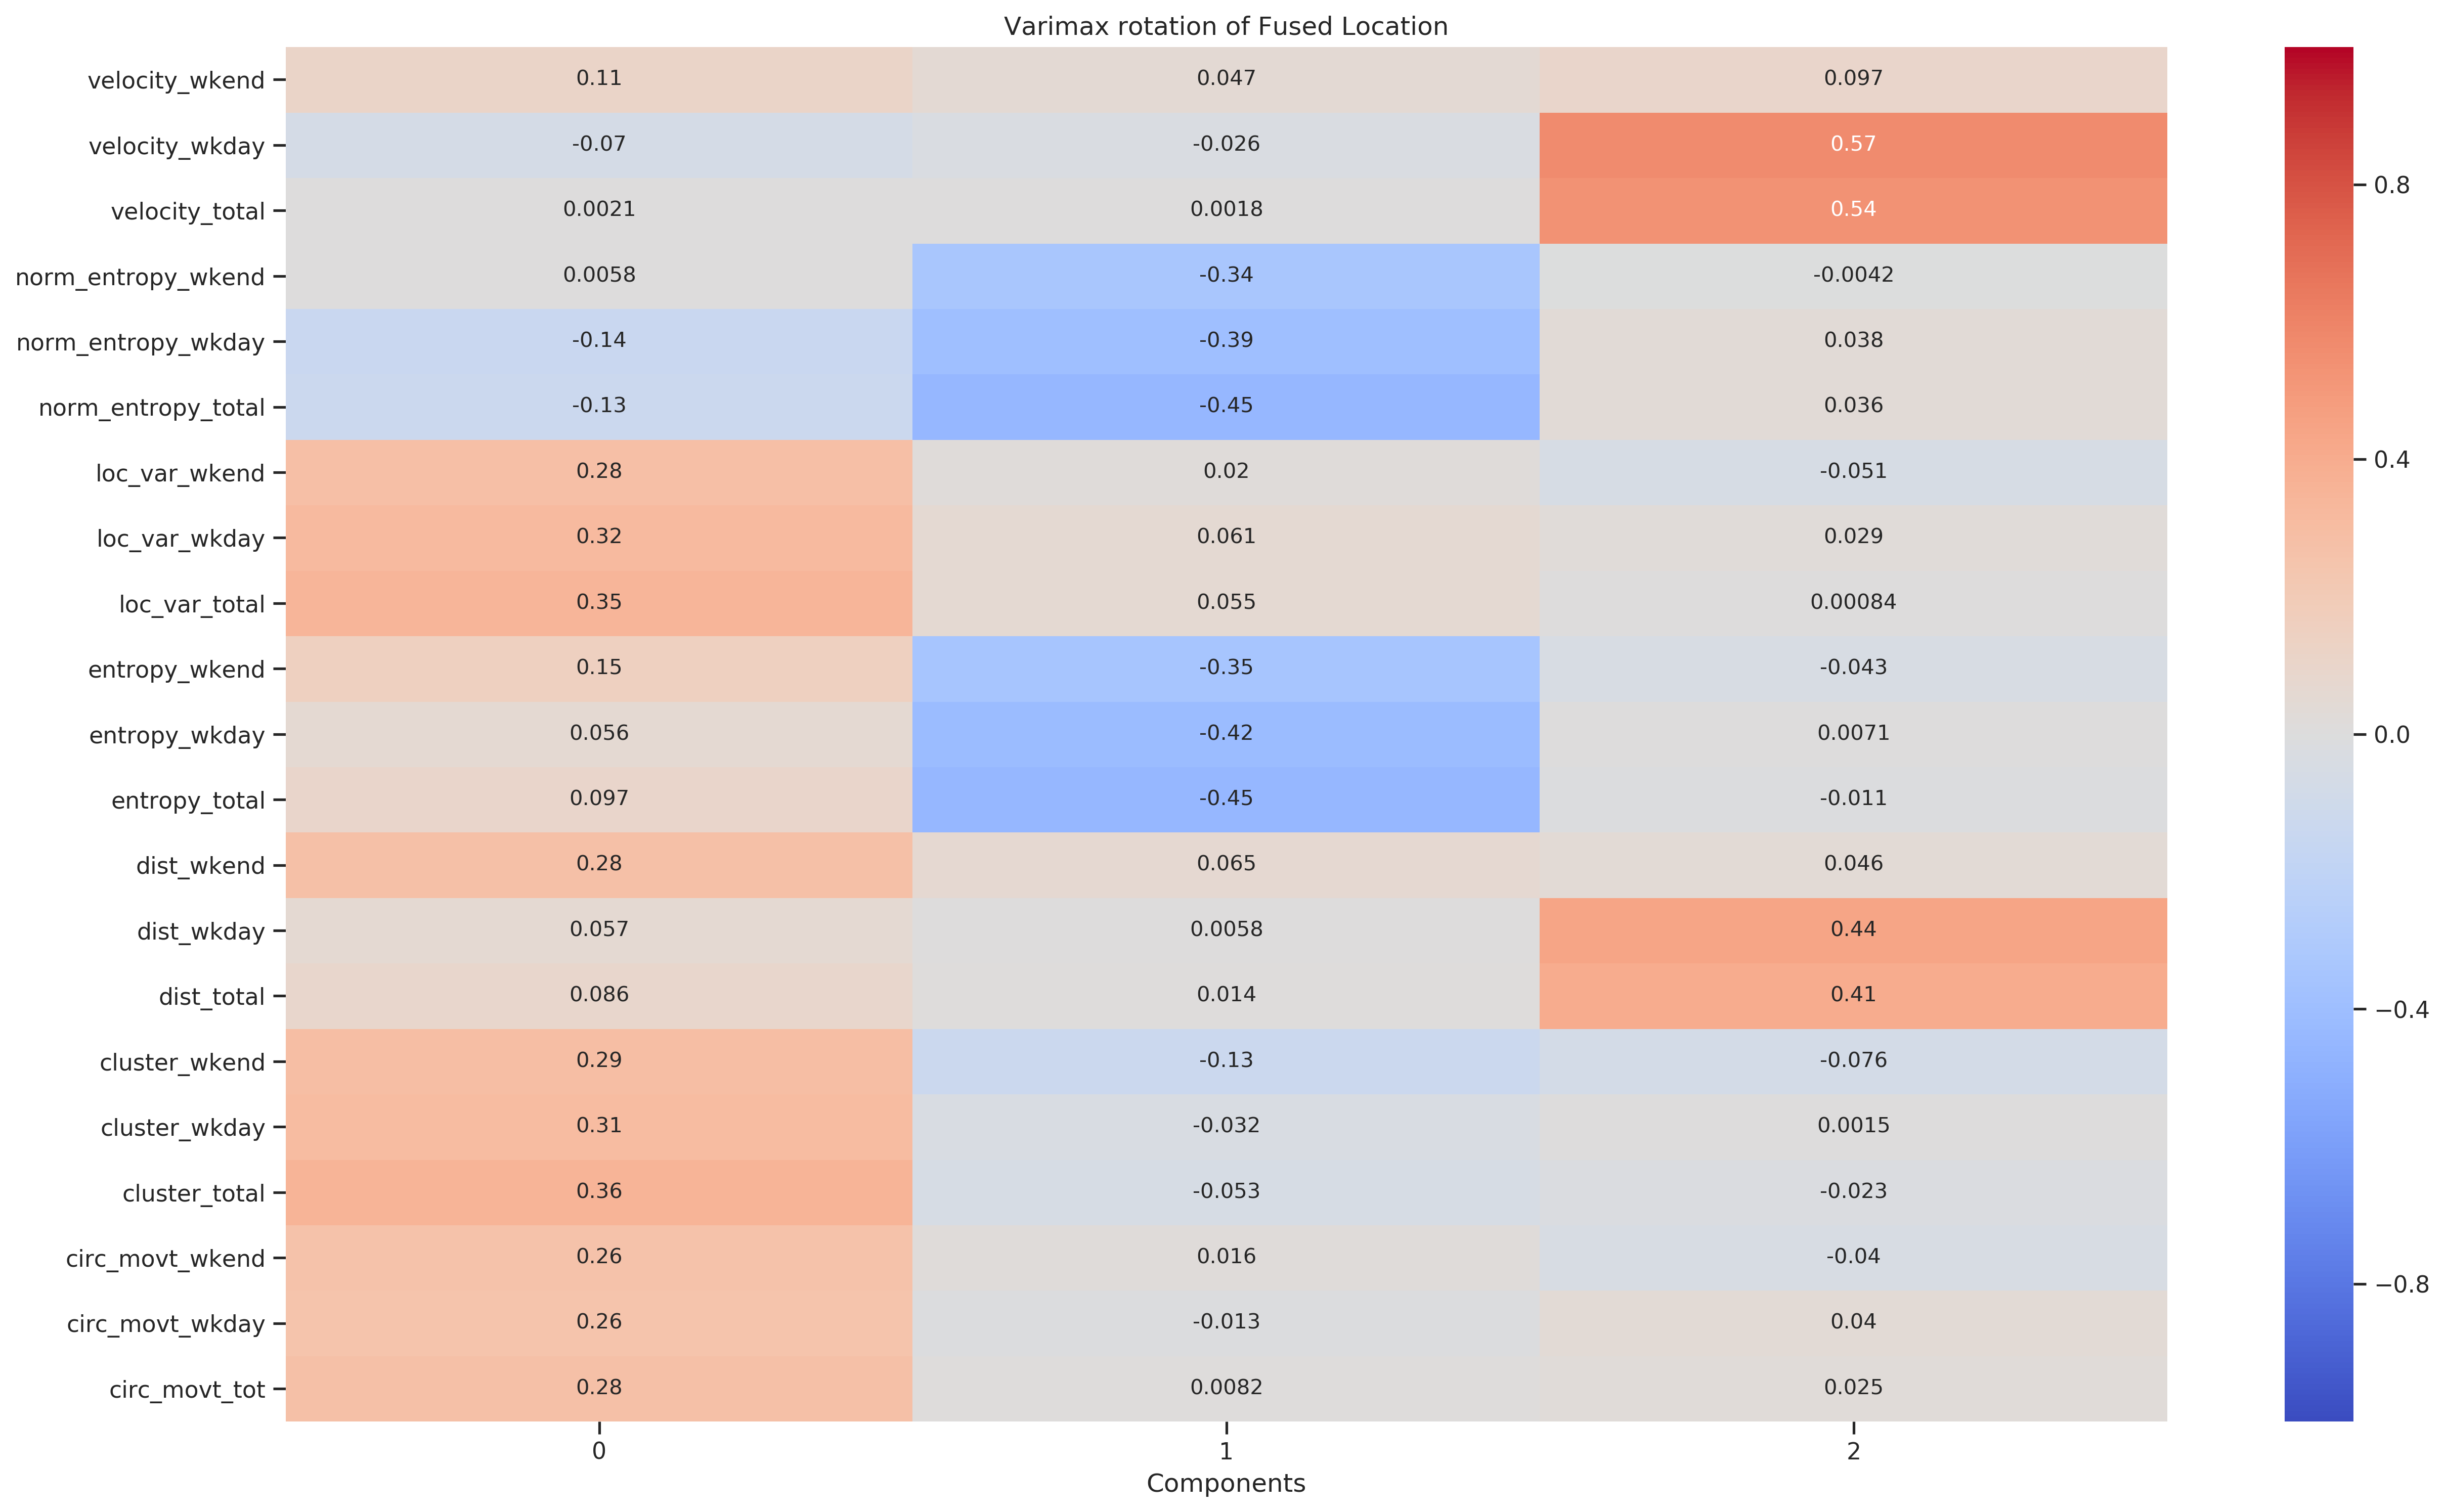

In [704]:
plot_varimax(loc_transformer, n_comps, loc_cols, "Varimax rotation of Fused Location")

In [705]:
pc_cols = ['loc_pc{}_agg'.format(i) for i in range(n_comps)]
loc_pc = pd.DataFrame(loc_transformed,
                      columns=pc_cols)
loc_pca_df = loc_pca_df.reset_index(drop=True)
loc_pca_df = pd.concat([loc_pca_df, loc_pc], axis=1)
agg_df = agg_df.merge(loc_pca_df[id_cols + pc_cols], how='left', on=id_cols)

# Change in Sensors

## Individual Sensors

In [511]:
all_sensors = sensor_cols + fus_cols

In [512]:
all_sensors_shift = [s + '_shift' for s in all_sensors]
all_sensors_change = [s + '_change' for s in all_sensors]

In [513]:
dig_state_df[all_sensors_shift] = dig_state_df.groupby('pid')[all_sensors].shift(1)

In [577]:
dig_state_df[['pid', 'study_wk', 'in_sms_count', 'in_sms_count_shift', 'phq_diff']].head(12)

pid  study_wk  in_sms_count  in_sms_count_shift  phq_diff
0   00746649         1     18.384615                 NaN       NaN
1   00746649         4     15.714286           18.384615       2.0
2   00746649         7     17.000000           15.714286      -2.0
3   00746649        10     23.923077           17.000000       2.0
4   00746649        13     21.923077           23.923077       5.0
5   00746649        16     26.000000           21.923077      -4.0
6   01225297         1      2.090909                 NaN       NaN
7   01225297         4           NaN            2.090909      -1.6
8   01225297         7           NaN                 NaN       0.0
9   01225297        10           NaN                 NaN      -1.4
10  01225297        13      1.083333                 NaN       0.0
11  01225297        16      0.818182            1.083333       1.0

In [515]:
#dig_state_df[all_sensors_change] = 
for cur, prev, change in zip(all_sensors, all_sensors_shift, all_sensors_change):
    dig_state_df[change] = dig_state_df[cur] - dig_state_df[prev]

## Aggregate Features

In [706]:
agg_cols = agg_df.columns[agg_df.columns.str.endswith("agg")]
agg_cols_shift = [s + '_shift' for s in agg_cols]
agg_cols_change = [s + '_change' for s in agg_cols]

In [707]:
agg_df[agg_cols_shift] = agg_df.groupby('pid')[agg_cols].shift(1)

In [708]:
for cur, prev, change in zip(agg_cols, agg_cols_shift, agg_cols_change):
    agg_df[change] = agg_df[cur] - agg_df[prev]

# Correlation with next time steps

## Individual Sensors

### Simple Correlation

#### Entire population

In [518]:
dig_state_df['phq_diff'].describe()

count    1025.000000
mean        0.008618
std         2.880980
min       -15.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max        16.000000
Name: phq_diff, dtype: float64

In [734]:
#pair_corr_df = pg.pairwise_corr(dig_state_df, columns=[all_sensors_change, ['phq_diff']], method='spearman', nan_policy='pairwise', padjust="none")
pair_corr_df = pg.pairwise_corr(dig_state_df, columns=[all_sensors_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
#pair_corr_df.sort_values(by='p-unc')[pair_corr_df['n'] > 200]
pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

X         Y    n      r    p-corr p-adjust
24   cluster_total_change  phq_diff  807 -0.111  0.019844   fdr_bh
25   cluster_wkday_change  phq_diff  805 -0.110  0.019844   fdr_bh
27      dist_total_change  phq_diff  807 -0.109  0.019844   fdr_bh
29      dist_wkend_change  phq_diff  792 -0.116  0.019844   fdr_bh
28      dist_wkday_change  phq_diff  805 -0.100  0.034911   fdr_bh
39  velocity_total_change  phq_diff  776 -0.099  0.034911   fdr_bh
40  velocity_wkday_change  phq_diff  781 -0.099  0.034911   fdr_bh
33   loc_var_total_change  phq_diff  807 -0.092  0.047737   fdr_bh
30   entropy_total_change  phq_diff  807 -0.086  0.062595   fdr_bh
32   entropy_wkend_change  phq_diff  792 -0.086  0.062595   fdr_bh
26   cluster_wkend_change  phq_diff  792 -0.081  0.085101   fdr_bh
14            maps_change  phq_diff  811 -0.078  0.089122   fdr_bh

#### no_symp

In [736]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'no_symp']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[all_sensors_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

X         Y    n      r    p-corr p-adjust
30       entropy_total_change  phq_diff  253 -0.197  0.034936   fdr_bh
36  norm_entropy_total_change  phq_diff  238 -0.207  0.034936   fdr_bh
31       entropy_wkday_change  phq_diff  252 -0.174  0.078550   fdr_bh
37  norm_entropy_wkday_change  phq_diff  235 -0.169  0.099735   fdr_bh

#### soc_anx

In [744]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'soc_anx']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[all_sensors_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

#### gen_anx

In [743]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'gen_anx']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[all_sensors_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
#pair_corr_df[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]
pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

#### dep_anx

In [742]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'dep_anx']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[all_sensors_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

X         Y    n      r    p-corr p-adjust
27      dist_total_change  phq_diff  147 -0.383  0.000072   fdr_bh
28      dist_wkday_change  phq_diff  147 -0.361  0.000099   fdr_bh
29      dist_wkend_change  phq_diff  147 -0.362  0.000099   fdr_bh
14            maps_change  phq_diff  148 -0.355  0.000102   fdr_bh
39  velocity_total_change  phq_diff  142 -0.351  0.000152   fdr_bh
40  velocity_wkday_change  phq_diff  146 -0.335  0.000246   fdr_bh
34   loc_var_wkday_change  phq_diff  147 -0.300  0.001349   fdr_bh
24   cluster_total_change  phq_diff  147 -0.272  0.003647   fdr_bh
25   cluster_wkday_change  phq_diff  147 -0.274  0.003647   fdr_bh
33   loc_var_total_change  phq_diff  147 -0.276  0.003647   fdr_bh
26   cluster_wkend_change  phq_diff  147 -0.202  0.054859   fdr_bh
12       instagram_change  phq_diff  148  0.198  0.055766   fdr_bh
9             orca_change  phq_diff  148  0.190  0.066931   fdr_bh
41  velocity_wkend_change  phq_diff  143 -0.190  0.068099   fdr_bh
32   entropy_wkend_change  phq_diff  147 -0.179  0.085309   fdr_bh

## Aggregate Features

### Simple Correlation

#### Entire population

In [709]:
agg_df['phq_diff'].describe()

count    1025.000000
mean        0.008618
std         2.880980
min       -15.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max        16.000000
Name: phq_diff, dtype: float64

In [741]:
#pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['phq_diff']], method='spearman', nan_policy='pairwise', padjust="none")
pair_corr_df = pg.pairwise_corr(agg_df, columns=[agg_cols_change, ['phq_diff']], padjust="fdr_bh")
#pair_corr_df.sort_values(by='p-unc')[pair_corr_df['n'] > 200]
pair_corr_df[pair_corr_df['p-corr'] < 0.1].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

X         Y    n      r    p-corr p-adjust
14  loc_pc0_agg_change  phq_diff  565 -0.180  0.000277   fdr_bh
5   fga_pc2_agg_change  phq_diff  811  0.096  0.053328   fdr_bh

#### no_symp

In [749]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'no_symp']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

X         Y    n      r    p-corr p-adjust
15  loc_pc1_agg_change  phq_diff  193  0.242  0.012066   fdr_bh

#### soc_anx

In [747]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'soc_anx']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

#### gen_anx

In [748]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'gen_anx']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], nan_policy='pairwise', padjust="fdr_bh")
#pair_corr_df[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]
pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

Empty DataFrame
Columns: [X, Y, n, r, p-corr, p-adjust]
Index: []

#### dep_anx

In [756]:
sel_state_df = agg_df[agg_df['baseline_cluster'] == 'dep_anx']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[agg_cols_change, ['phq_diff']], padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.1)].sort_values(by='p-corr')[['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

X         Y    n      r    p-corr p-adjust
14  loc_pc0_agg_change  phq_diff  115 -0.426  0.000035   fdr_bh
5   fga_pc2_agg_change  phq_diff  148  0.283  0.004268   fdr_bh
16  loc_pc2_agg_change  phq_diff  115 -0.225  0.087872   fdr_bh

In [755]:
sel_state_df.shape

(240, 234)

In [753]:
agg_df[agg_cols_change].isna().sum()

active_apps_agg_change      419
passive_apps_agg_change     419
social_apps_agg_change      419
fga_pc0_agg_change          419
fga_pc1_agg_change          419
fga_pc2_agg_change          419
fga_pc3_agg_change          419
fga_pc4_agg_change          419
sloc_pc0_agg_change        1093
sloc_pc1_agg_change        1093
sloc_pc2_agg_change        1093
sloc_pc3_agg_change        1093
sms_agg_change              444
cal_agg_change              431
loc_pc0_agg_change          665
loc_pc1_agg_change          665
loc_pc2_agg_change          665
dtype: int64

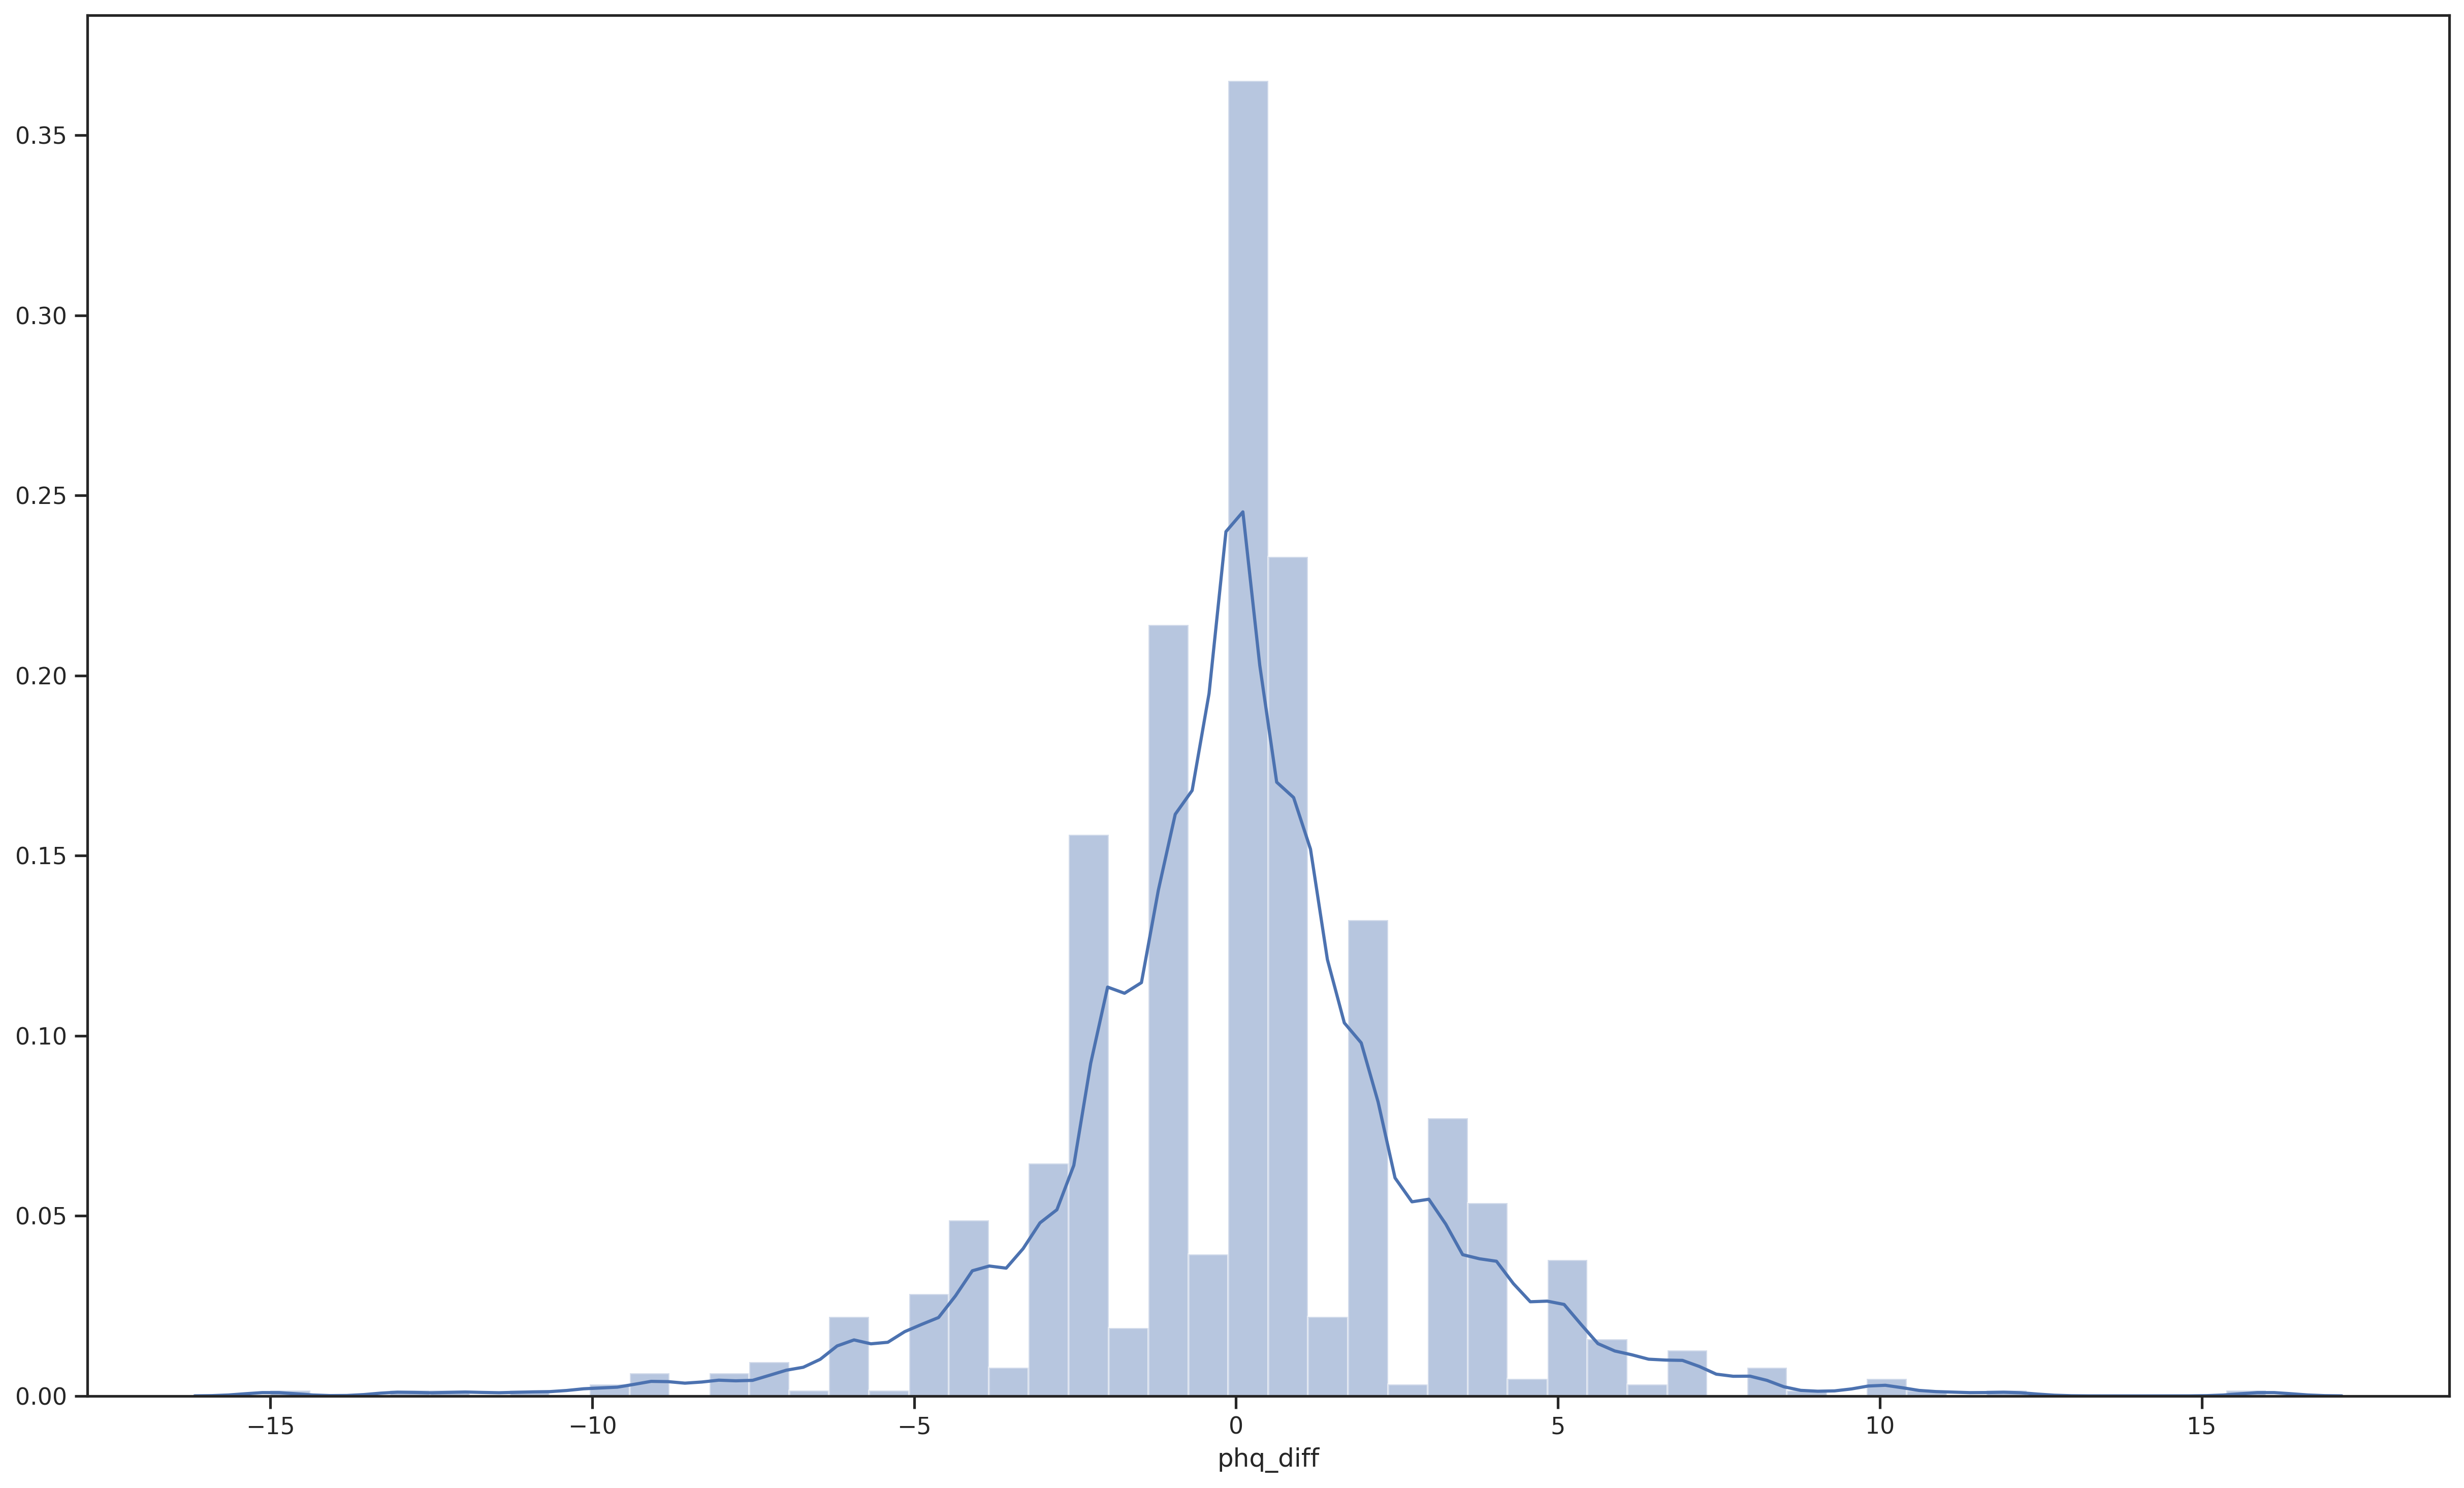

In [732]:
sns.distplot(dig_state_df['phq_diff'].dropna())

### Partial Correlation

In [164]:
def build_partial_corr(corr_df, target, covar, pval=0.05):
    """
    Builds partial correlation DataFrame from corr_df of the target survey, controlling for covar.
    """
    
    partial_corr = pg.pairwise_corr(data=corr_df, covar=[covar], method='pearson')
    partial_corr = partial_corr.loc[(partial_corr['p-unc'] < pval) & (partial_corr['X'].str.contains(target)) & (~partial_corr['Y'].str.contains(target))]
    partial_corr['r_ctl'] = partial_corr['r']
    partial_corr['p_ctl'] = partial_corr['p-unc']

    partial_corr = partial_corr[['X', 'Y', 'covar', 'r_ctl', 'p_ctl']]

    pairwise_corr = pg.pairwise_corr(data=corr_df, method='pearson')
    pairwise_corr['r_unctl'] = pairwise_corr['r']
    pairwise_corr['p_unctl'] = pairwise_corr['p-unc']

    partial_corr = partial_corr.merge(pairwise_corr[['X', 'Y', 'r_unctl', 'p_unctl']], on=['X', 'Y'], how='left')
    return partial_corr

In [156]:
dig_state_df['age'] = dig_state_df['pid'].map(age_dict)

#### All groups

In [165]:
build_partial_corr(dig_state_df, 'phq_tot', 'age')

X               Y    covar  r_ctl         p_ctl  r_unctl  \
0   phq_tot   tot_sms_count  ['age'] -0.104  1.400259e-05   -0.082   
1   phq_tot  tot_sms_length  ['age'] -0.079  9.726471e-04   -0.060   
2   phq_tot    in_sms_count  ['age'] -0.088  2.369961e-04   -0.066   
3   phq_tot   in_sms_length  ['age'] -0.058  1.613922e-02   -0.040   
4   phq_tot   out_sms_count  ['age'] -0.142  2.748486e-09   -0.120   
5   phq_tot  out_sms_length  ['age'] -0.113  2.222745e-06   -0.095   
6   phq_tot         cluster  ['age'] -0.179  2.681287e-13   -0.163   
7   phq_tot            dist  ['age'] -0.108  1.084205e-05   -0.102   
8   phq_tot         entropy  ['age'] -0.174  1.379103e-12   -0.147   
9   phq_tot         loc_var  ['age'] -0.143  9.193851e-03   -0.138   
10  phq_tot        velocity  ['age'] -0.050  4.313451e-02   -0.043   
11  phq_tot            orca  ['age']  0.125  1.008914e-07    0.133   
12  phq_tot       messaging  ['age'] -0.133  1.662732e-08   -0.135   
13  phq_tot        launcher  ['age'] -0.110  3.023451e-06   -0.120   
14  phq_tot       instagram  ['age'] -0.058  1.420130e-02   -0.014   
15  phq_tot            maps  ['age'] -0.078  9.066459e-04   -0.048   
16  phq_tot        snapchat  ['age'] -0.057  1.491489e-02   -0.005   
17  phq_tot     all_browser  ['age']  0.072  2.319680e-03    0.092   
18  phq_tot    exercise_dur  ['age'] -0.140  1.105581e-02   -0.132   
19  phq_tot        food_dur  ['age'] -0.111  4.304700e-02   -0.111   

         p_unctl  
0   6.386027e-04  
1   1.167994e-02  
2   6.029409e-03  
3   9.238305e-02  
4   5.582657e-07  
5   7.497166e-05  
6   2.944532e-11  
7   3.312560e-05  
8   1.970986e-09  
9   1.212484e-02  
10  8.561793e-02  
11  1.661323e-08  
12  8.355739e-09  
13  3.089457e-07  
14  5.492736e-01  
15  4.046466e-02  
16  8.241707e-01  
17  8.772990e-05  
18  1.626559e-02  
19  4.384411e-02

#### No symp

In [166]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'no_symp']
build_partial_corr(sel_state_df, 'phq_tot', 'age')

X              Y    covar  r_ctl         p_ctl  r_unctl  \
0   phq_tot  tot_sms_count  ['age'] -0.106  1.218915e-02   -0.122   
1   phq_tot   in_sms_count  ['age'] -0.129  2.365866e-03   -0.141   
2   phq_tot  out_sms_count  ['age'] -0.085  4.641181e-02   -0.102   
3   phq_tot        cluster  ['age'] -0.291  1.168984e-11   -0.294   
4   phq_tot           dist  ['age'] -0.209  1.389610e-06   -0.220   
5   phq_tot        entropy  ['age'] -0.343  6.655913e-16   -0.344   
6   phq_tot        loc_var  ['age'] -0.207  1.201982e-02   -0.207   
7   phq_tot   norm_entropy  ['age'] -0.318  1.100913e-02   -0.339   
8   phq_tot       velocity  ['age'] -0.215  7.930332e-07   -0.226   
9   phq_tot         katana  ['age']  0.123  3.085420e-03    0.133   
10  phq_tot           orca  ['age']  0.175  2.337664e-05    0.168   
11  phq_tot      messaging  ['age'] -0.157  1.548204e-04   -0.166   
12  phq_tot    all_browser  ['age']  0.189  4.892930e-06    0.180   

         p_unctl  
0   3.911196e-03  
1   8.321516e-04  
2   1.602380e-02  
3   6.606288e-12  
4   3.637732e-07  
5   5.376131e-16  
6   1.223849e-02  
7   6.512042e-03  
8   2.044899e-07  
9   1.427804e-03  
10  5.109897e-05  
11  6.221556e-05  
12  1.382917e-05

#### soc_anx

In [167]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'soc_anx']
build_partial_corr(sel_state_df, 'phq_tot', 'age')

X                  Y    covar  r_ctl     p_ctl  r_unctl   p_unctl
0  phq_tot      tot_sms_count  ['age']  0.154  0.000712    0.156  0.000621
1  phq_tot     tot_sms_length  ['age']  0.148  0.001157    0.150  0.001014
2  phq_tot       in_sms_count  ['age']  0.158  0.000524    0.159  0.000476
3  phq_tot      in_sms_length  ['age']  0.147  0.001320    0.148  0.001217
4  phq_tot     tot_call_count  ['age']  0.094  0.041459    0.094  0.041379
5  phq_tot  tot_call_duration  ['age']  0.184  0.000055    0.183  0.000059
6  phq_tot            entropy  ['age'] -0.119  0.012909   -0.109  0.022275
7  phq_tot             katana  ['age'] -0.139  0.002232   -0.141  0.001974
8  phq_tot              email  ['age'] -0.138  0.002471   -0.132  0.003704
9  phq_tot          instagram  ['age']  0.108  0.017806    0.113  0.013536

#### gen_anx

In [168]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'gen_anx']
build_partial_corr(sel_state_df, 'phq_tot', 'age')

X                  Y    covar  r_ctl     p_ctl  r_unctl   p_unctl
0  phq_tot     tot_call_count  ['age']  0.120  0.015314    0.129  0.009260
1  phq_tot  tot_call_duration  ['age']  0.116  0.018905    0.126  0.010926
2  phq_tot            loc_var  ['age'] -0.312  0.021664   -0.232  0.091601
3  phq_tot             katana  ['age'] -0.167  0.000659   -0.157  0.001404
4  phq_tot               orca  ['age'] -0.186  0.000143   -0.197  0.000057
5  phq_tot           launcher  ['age'] -0.124  0.011401   -0.124  0.011688
6  phq_tot              email  ['age'] -0.121  0.013604   -0.106  0.030767
7  phq_tot          instagram  ['age'] -0.188  0.000117   -0.204  0.000028
8  phq_tot           snapchat  ['age'] -0.191  0.000091   -0.208  0.000021
9  phq_tot       exercise_dur  ['age'] -0.272  0.022593   -0.240  0.045456

#### dep_anx

In [186]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'dep_anx']
sel_state_df = sel_state_df[list(dep_anx_feat) + ['phq_tot', 'age']]
build_partial_corr(sel_state_df, 'phq_tot', 'age', pval=np.inf)

Empty DataFrame
Columns: [covar, r_ctl, p_ctl, X, Y, r_unctl, p_unctl]
Index: []

### Repeated Measures Correlation

In [102]:
subset_sensors = sensor_cols = sms_cols + fus_cols + cal_cols + fga_cols #+ sloc_cols

def build_rmcorr_df(seq_df, cols, target='phq_diff'):
    rm_corr_df = pd.DataFrame()
    for col in cols:
        df = pg.rm_corr(data=seq_df, x=col, y=target, subject='pid')
        df['feat'] = col
        rm_corr_df = rm_corr_df.append(df)
        
    return rm_corr_df

#### All groups

In [103]:
rm_corr_df = build_rmcorr_df(dig_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c

AssertionError: 

#### no_symp

In [104]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'no_symp']
rm_corr_df = build_rmcorr_df(sel_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

AssertionError: 

#### soc_anx

In [105]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'soc_anx']
rm_corr_df = build_rmcorr_df(sel_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

AssertionError: 

#### gen_anx

In [137]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'gen_anx']
rm_corr_df = build_rmcorr_df(sel_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/parametric.py:1658: RuntimeWarning: divide by zero encountered in double_scalars
  ms_w = ss_w / df_w
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/effsize.py:146: RuntimeWarning: invalid value encountered in sqrt
  se = 1 / np.sqrt(nx - 3)


r  dof      pval           CI95%  power      feat
rm_corr -0.140  332  0.010197  [-0.24, -0.03]  0.731   cluster
rm_corr -0.163  332  0.002855  [-0.27, -0.06]  0.849      dist
rm_corr -0.165  320  0.002997  [-0.27, -0.06]  0.845  velocity

#### dep_anx

In [138]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'dep_anx']
rm_corr_df = build_rmcorr_df(sel_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/parametric.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror


AssertionError: 

## Fixed Effects Model

In [727]:
dig_state_df['zphq'] = dig_state_df.groupby("pid")['phq_tot'].apply(lambda x: (x - x.mean()) / x.std())


In [736]:
from linearmodels import PanelOLS

fe_data = dig_state_df.set_index(['pid', 'survey_idx'])
formula = """phq_tot ~ 1 + tot_sms_count + out_sms_count + out_sms_length + orca + messaging + launcher + chrome + browser + dist + entropy + EntityEffects"""
model = PanelOLS.from_formula(formula, data=fe_data)
print(model.fit(cov_type='robust'))

                          PanelOLS Estimation Summary                           
Dep. Variable:                phq_tot   R-squared:                        0.0282
Estimator:                   PanelOLS   R-squared (Between):             -0.0129
No. Observations:                2104   R-squared (Within):               0.0282
Date:                Tue, Dec 17 2019   R-squared (Overall):             -0.0077
Time:                        21:44:42   Log-likelihood                   -4795.8
Cov. Estimator:                Robust                                           
                                        F-statistic:                      5.3021
Entities:                         267   P-value                           0.0000
Avg Obs:                       7.8801   Distribution:                 F(10,1827)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             4.7064
                            

In [733]:
formula = """zphq ~ 1 + dist + TimeEffects + EntityEffects"""
model = PanelOLS.from_formula(formula, data=fe_data)
print(model.fit(cov_type='robust'))

                          PanelOLS Estimation Summary                           
Dep. Variable:                   zphq   R-squared:                        0.0158
Estimator:                   PanelOLS   R-squared (Between):             -0.6208
No. Observations:                2135   R-squared (Within):               0.0159
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.0008
Time:                        21:38:35   Log-likelihood                   -2835.6
Cov. Estimator:                Robust                                           
                                        F-statistic:                      30.013
Entities:                         256   P-value                           0.0000
Avg Obs:                       8.3398   Distribution:                  F(1,1867)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             28.931
                            

## Treatment Relationship to Digital Markers

In [782]:
def build_col_dict_general(cols, feat_df, target, seq_df, transform_log=True, pre_days=3, post_days=3):
    """Builds a (col, [vals]) dictionary for the given features
    
    Currently looks at a 7 day window around each survey
    """
    col_dict = {}


    for col in cols:
        col_dict[col] = []

    for idx, row in seq_df.iterrows():
        if pd.isna(row[target]):
            for col in cols:
                col_dict[col].append(np.nan)
            continue
        else:
            date = row['date']
            pid = row['pid']
            sel_df =  feat_df[(feat_df['pid'] == pid) &
                              # TODO double check that this is the date range we want
                             (feat_df['date'] >= (date.floor('D') - pd.Timedelta(pre_days, unit='D'))) & 
                             (feat_df['date'] <= (date.floor('D') + pd.Timedelta(post_days, unit='D')))]
            sel_mean = sel_df.mean()
            
            if transform_log: sel_mean = np.log(sel_mean + 1)
            for col in cols:
                col_dict[col].append(sel_mean[col])
                
    return col_dict

In [778]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 2,
   "week_7_arm_1": 3,
   "week_10_arm_1": 4,
   "week_13_arm_1": 5,
   "week_16_arm_1": 6
}

state_df['study_wk'] = state_df['redcap_event_name'].map(event_dict)

last_phq_df = phq_df.drop_duplicates(subset=['pid', 'redcap_event_name'], keep='first')
last_phq_df['study_wk'] = last_phq_df['redcap_event_name'].map(event_dict)
all_state_df = state_df.merge(last_phq_df, on=['pid', 'study_wk', 'redcap_event_name'], how='left')

# replace 99s with nans, TODO better way to handle this?
all_state_df = all_state_df.replace(to_replace=99, value=np.nan)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


pid redcap_event_name            gad_start  gad01  gad02  gad03  \
0  00746649      week_0_arm_1           2019-07-22    1.0    1.0    1.0   
1  00746649      week_4_arm_1  2019-08-23 19:04:16    3.0    3.0    3.0   
2  00746649      week_7_arm_1  2019-09-14 15:19:45    2.0    2.0    2.0   
3  00746649     week_10_arm_1  2019-10-04 16:25:27    3.0    3.0    3.0   
4  00746649     week_13_arm_1  2019-10-25 22:38:25    3.0    2.0    2.0   

   gad04  gad05  gad06  gad07  ...  phq02_sc phq03_sc  phq04_sc  phq05_sc  \
0    1.0    2.0    2.0    2.0  ...         1        3         1         1   
1    3.0    3.0    3.0    2.0  ...         2        2         2         0   
2    2.0    2.0    2.0    2.0  ...         1        1         2         2   
3    3.0    3.0    3.0    3.0  ...         1        1         1         0   
4    2.0    2.0    3.0    3.0  ...         1        1         2         0   

  phq06_sc  phq07_sc  phq08_sc  phq_total_sc  phq10_sc            phq_start  
0        1         1         2          12.0         3           2019-07-22  
1        1         1         0           9.0         2  2019-08-26 19:04:10  
2        3         2         0          12.0         2  2019-09-10 14:28:31  
3        1         1         0           6.0         1  2019-10-01 10:53:03  
4        1         2         0           9.0         2  2019-10-22 13:02:22  

[5 rows x 80 columns]

In [791]:
treat_seq_df = all_state_df[['pid', 'study_wk', 'psytxhx_psychother_3wk', 'phq_total_sc', 'psytxhx_curr_meds_fu']]

treat_seq_df['date'] = all_state_df['txhx_start_fu']

treat_seq_df['date'] = pd.to_datetime(treat_seq_df['date'])

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [792]:
%%time

sms_dict = build_col_dict_general(sms_cols, sms_daily, 'psytxhx_curr_meds_fu', treat_seq_df, pre_days=14, post_days=-1)
cal_dict = build_col_dict_general(cal_cols, cal_daily, 'psytxhx_curr_meds_fu', treat_seq_df, pre_days=14, post_days=-1)
fus_dict = build_col_dict_general(fus_cols, fus_daily, 'psytxhx_curr_meds_fu', treat_seq_df, pre_days=14, post_days=-1)
fga_dict = build_col_dict_general(fga_cols, fga_daily, 'psytxhx_curr_meds_fu', treat_seq_df, pre_days=14, post_days=-1)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


CPU times: user 33.2 s, sys: 40.1 ms, total: 33.3 s
Wall time: 33.3 s


In [795]:
dig_treat_df = treat_seq_df.copy()

sensor_dicts = [sms_dict, cal_dict, fus_dict, fga_dict]

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        dig_treat_df[col] = vals
    
dig_treat_df = dig_treat_df.replace([np.inf, -np.inf], np.nan)

dig_treat_df.head()
dig_treat_df = dig_treat_df[dig_treat_df['study_wk'] != 0]

## Simple Correlations

In [797]:
pair_corr_df = pg.pairwise_corr(dig_treat_df, columns=[sensor_cols, ['psytxhx_psychother_3wk', 'psytxhx_curr_meds_fu']], padjust="fdr_bh")
pair_corr_df[pair_corr_df['p-corr'] < 0.01][['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

X                       Y     n      r        p-corr p-adjust
29  instagram    psytxhx_curr_meds_fu  1292 -0.192  1.839496e-10   fdr_bh
31    youtube    psytxhx_curr_meds_fu  1292 -0.158  2.696404e-07   fdr_bh
36    browser  psytxhx_psychother_3wk  1289 -0.101  4.462703e-03   fdr_bh

## Repeated Measures Correlation

In [809]:
rm_corr_df = pd.DataFrame()
for col in sms_cols + fga_cols:
    df = pg.rm_corr(data=dig_treat_df, y='psytxhx_psychother_3wk', x=col, subject='pid')
    df['X'] = col
    df['Y'] = 'psytxhx_psychother_3wk'
    rm_corr_df = rm_corr_df.append(df)

In [810]:
rm_corr_df[(rm_corr_df['pval'] < 0.1) & (rm_corr_df['Y'] != 'loc_var')]

r   dof      pval          CI95%  power      X  \
rm_corr  0.055  1021  0.080826  [-0.01, 0.12]  0.416   orca   
rm_corr  0.052  1021  0.098899  [-0.01, 0.11]  0.379  email   
rm_corr  0.055  1021  0.077312  [-0.01, 0.12]  0.424   maps   

                              Y  
rm_corr  psytxhx_psychother_3wk  
rm_corr  psytxhx_psychother_3wk  
rm_corr  psytxhx_psychother_3wk

In [807]:
rm_corr_df = pd.DataFrame()
for col in sms_cols + fga_cols:
    df = pg.rm_corr(data=dig_treat_df, y='psytxhx_curr_meds_fu', x=col, subject='pid')
    df['X'] = col
    df['Y'] = 'psytxhx_curr_meds_fu'
    rm_corr_df = rm_corr_df.append(df)

In [808]:
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['Y'] != 'loc_var')]

r   dof     pval           CI95%  power        X  \
rm_corr -0.073  1024  0.02002  [-0.13, -0.01]  0.643  browser   

                            Y  
rm_corr  psytxhx_curr_meds_fu

## Panel Regression

In [812]:
fe_data = dig_treat_df.set_index(['pid', 'study_wk'])
formula = """psytxhx_curr_meds_fu ~ 1 + tot_sms_count + out_sms_count + out_sms_length + orca + messaging + launcher + chrome + browser + dist + entropy + EntityEffects"""
model = PanelOLS.from_formula(formula, data=fe_data)
print(model.fit(cov_type='robust'))

                           PanelOLS Estimation Summary                            
Dep. Variable:     psytxhx_curr_meds_fu   R-squared:                        0.0191
Estimator:                     PanelOLS   R-squared (Between):             -0.0025
No. Observations:                  1255   R-squared (Within):               0.0191
Date:                  Wed, Dec 18 2019   R-squared (Overall):             -0.0024
Time:                          07:55:41   Log-likelihood                    814.20
Cov. Estimator:                  Robust                                           
                                          F-statistic:                      1.9148
Entities:                           263   P-value                           0.0397
Avg Obs:                         4.7719   Distribution:                  F(10,982)
Min Obs:                         1.0000                                           
Max Obs:                         5.0000   F-statistic (robust):             1.1883
    

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/linearmodels/utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [813]:
fe_data = dig_treat_df.set_index(['pid', 'study_wk'])
formula = """psytxhx_psychother_3wk ~ 1 + tot_sms_count + out_sms_count + out_sms_length + orca + messaging + launcher + chrome + browser + dist + entropy + EntityEffects"""
model = PanelOLS.from_formula(formula, data=fe_data)
print(model.fit(cov_type='robust'))

                            PanelOLS Estimation Summary                             
Dep. Variable:     psytxhx_psychother_3wk   R-squared:                        0.0083
Estimator:                       PanelOLS   R-squared (Between):             -0.0158
No. Observations:                    1252   R-squared (Within):               0.0083
Date:                    Wed, Dec 18 2019   R-squared (Overall):             -0.0105
Time:                            07:56:36   Log-likelihood                    115.13
Cov. Estimator:                    Robust                                           
                                            F-statistic:                      0.8184
Entities:                             263   P-value                           0.6109
Avg Obs:                           4.7605   Distribution:                  F(10,979)
Min Obs:                           1.0000                                           
Max Obs:                           5.0000   F-statistic (robust):

## State to Digital Markers

In [703]:
%%time

sms_dict = build_col_dict(sms_cols, sms_daily, pre_days=-1, post_days=7)
cal_dict = build_col_dict(cal_cols, cal_daily, pre_days=-1, post_days=7)
fus_dict = build_col_dict(fus_cols, fus_daily, pre_days=-1, post_days=7)
fga_dict = build_col_dict(fga_cols, fga_daily, pre_days=-1, post_days=7)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


CPU times: user 58.1 s, sys: 53.7 ms, total: 58.2 s
Wall time: 58.2 s


In [704]:
state_dig_df = phq_seq_df.copy()

sensor_dicts = [sms_dict, cal_dict, fus_dict, fga_dict]

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        state_dig_df[col] = vals
    
state_dig_df = state_dig_df.replace([np.inf, -np.inf], np.nan)

state_dig_df.head()
state_dig_df = state_dig_df[state_dig_df['survey_idx'] != 0]

### Simple Correlation

In [708]:
pair_corr_df = pg.pairwise_corr(state_dig_df, columns=[['phq_tot'], sensor_cols], padjust="fdr_bh")
pair_corr_df[pair_corr_df['p-corr'] < 0.01][['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

X               Y     n      r        p-corr p-adjust
0   phq_tot   tot_sms_count  2291 -0.098  8.552909e-06   fdr_bh
1   phq_tot  tot_sms_length  2291 -0.075  6.895980e-04   fdr_bh
2   phq_tot    in_sms_count  2291 -0.077  5.264496e-04   fdr_bh
3   phq_tot   in_sms_length  2291 -0.062  5.671399e-03   fdr_bh
4   phq_tot   out_sms_count  2291 -0.144  1.264362e-10   fdr_bh
5   phq_tot  out_sms_length  2291 -0.109  6.908906e-07   fdr_bh
9   phq_tot            orca  2369  0.091  3.029036e-05   fdr_bh
10  phq_tot       messaging  2369 -0.111  3.304393e-07   fdr_bh
11  phq_tot        launcher  2368 -0.074  6.895980e-04   fdr_bh
12  phq_tot          chrome  2369  0.114  2.214918e-07   fdr_bh
18  phq_tot         browser  2369 -0.083  1.366927e-04   fdr_bh
19  phq_tot         cluster  2347 -0.132  1.754846e-09   fdr_bh
20  phq_tot            dist  2347 -0.062  5.237085e-03   fdr_bh
21  phq_tot         entropy  2346 -0.113  2.214918e-07   fdr_bh

### Repeated Measures Correlation

In [711]:
rm_corr_df = pd.DataFrame()
for col in sensor_cols:
    df = pg.rm_corr(data=state_dig_df, x='phq_tot', y=col, subject='pid')
    df['X'] = 'phq_tot'
    df['Y'] = col
    rm_corr_df = rm_corr_df.append(df)

In [714]:
rm_corr_df[(rm_corr_df['pval'] < 0.01) & (rm_corr_df['Y'] != 'loc_var')]

r   dof      pval           CI95%  power        X        Y
rm_corr -0.073  2076  0.000811  [-0.12, -0.03]  0.918  phq_tot  cluster

## Sandbox

In [737]:
def get_circadian_movement(fus_df):
    """Calculates the circadian movement based on GPS location for participants
    
    TODO need to verify the frequency is calculated correctly.
    
    """
    freq = np.linspace(86400-30*60, 86400+30*60, 2*30*60)
    try:
        energy_lat = sum(lombscargle(fus_df['timestamp'], fus_df['latitude'], freq, normalize=True))
        energy_long = sum(lombscargle(fus_df['timestamp'], fus_df['longitude'], freq, normalize=True))
    except ZeroDivisionError:
        return np.nan
    
    tot_energy = energy_lat + energy_long
    if tot_energy > 0:
        return np.log(energy_lat + energy_long)
    else:
        return np.nan

11.909807910147636

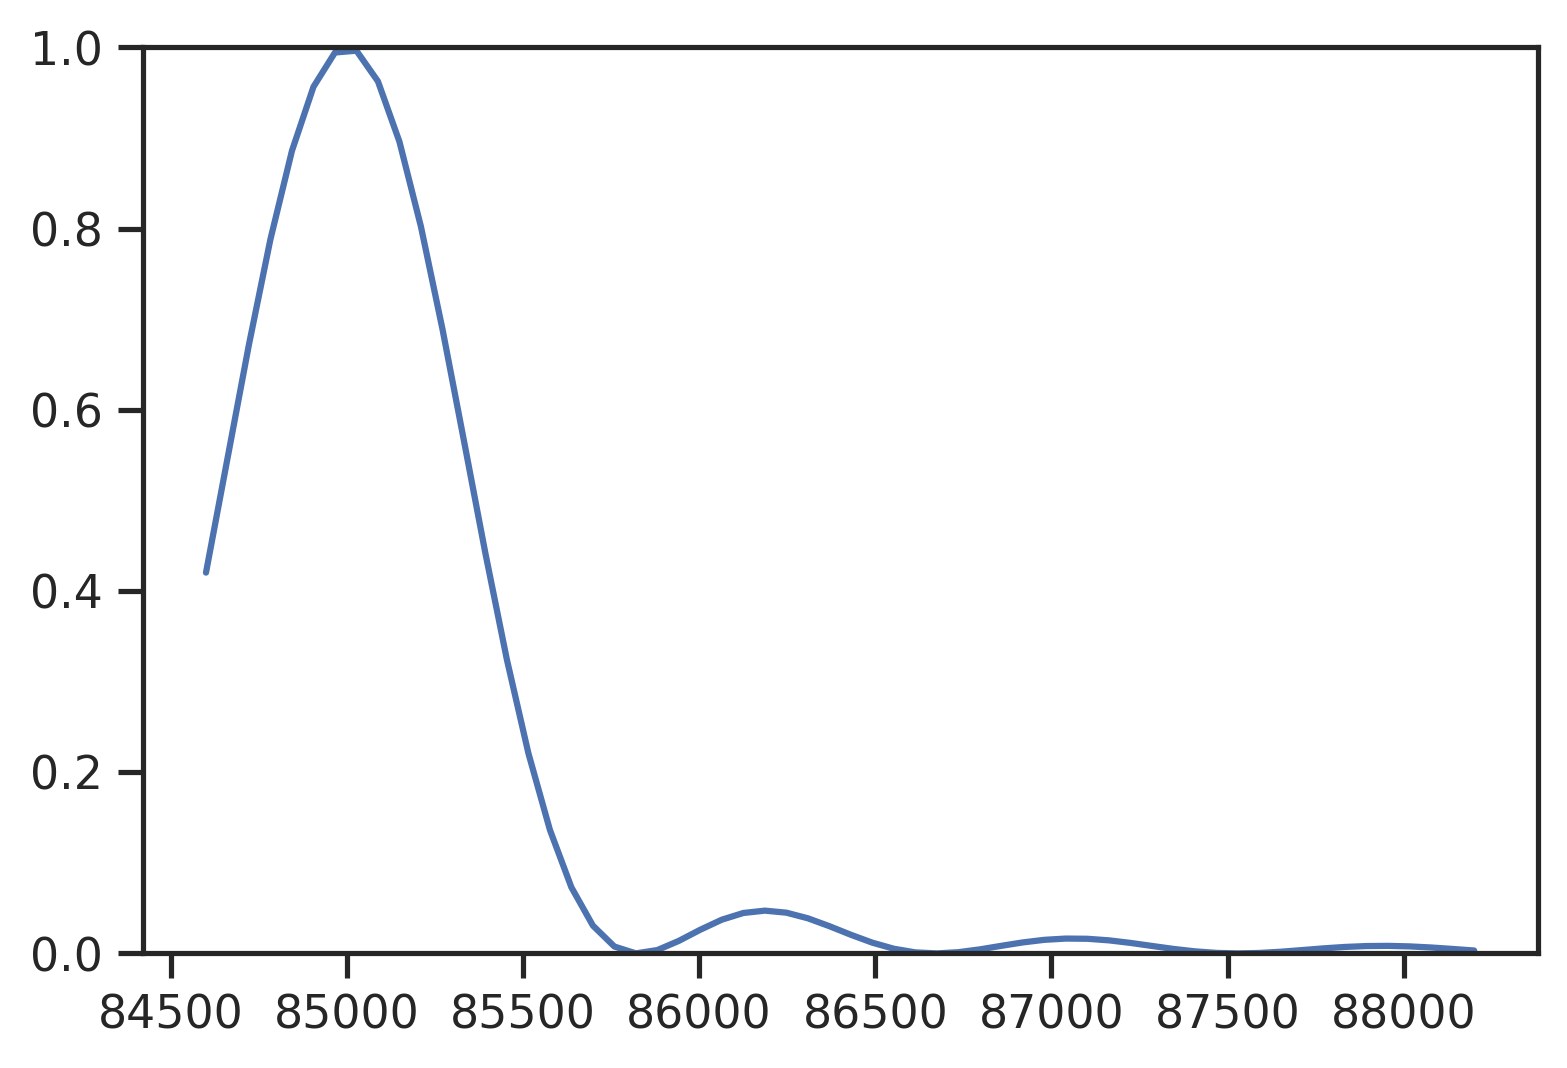

In [179]:
freq = np.linspace(86400-30*60, 86400+30*60, 60)
periods = 2 * np.pi / freq
x = np.linspace(0, 100*(86400+30*60), 2*30*60)
phi = 2*np.pi / (85000)

y = np.sin(phi*x)
pgram = lombscargle(x, y, periods, precenter=True, normalize=True)
plt.plot(freq, pgram)
plt.ylim(0,1)
sum(pgram)